# US Income dataset

This workbook explores the drivers of US income and develops competing models predicting whether a given individual would be earning below or above $50,000.


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
from sklearn.preprocessing import StandardScaler  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import model_selection, preprocessing, cluster, metrics

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


import time

## 1. Exploratory Data Analysis

### 1.1 First let's understand the dataset
- metadata claims there are 40 features plus the target variable
- from initial inspection of the data there are 41 features instead
- the discrepancy seems to arise from 'instance weight'
- the csv data comes without coplumn headers. 

When reading the metadata, I'll extract the following information:
    * list of 41 column names to append to the data, and ease analysis
    * list of unique variables for each features. This will then confirm column labels are correctly assigned

In [2]:
# Read metadata
# Save column names - will be helpful to analyse the dataset
colnames = []
unique = {}
col = False
content = False
with open('census_income_metadata.txt') as f:
    for line in f:
        print(line)
        if 'age:' in line:
            col = True
        if 'age: continuous.' in line:
            content = True
        # extract column names
        if col:
            name = line[:line.index(':')].replace(' ', '_')
            colnames.append(name)
        if content:
            key = line.split(':')[0].replace(' ', '_')
            vals = line.split(': ')[1].split('.')[0].split(', ')
            unique.update({key:vals})
            
# instance weight appears twice in the list, one needs to be ignored
colnames.remove('|_instance_weight')
# append target variable name to the list - the last column, not found in the metadata
colnames.append('income')

| This data was extracted from the census bureau database found at

| https://www.census.gov/data.html

| Donor: Terran Lane and Ronny Kohavi

|        Data Mining and Visualization

|        Silicon Graphics.

|        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.

|

| The data was split into train/test in approximately 2/3, 1/3

| proportions using MineSet's MIndUtil mineset-to-mlc.

|

| Prediction task is to determine the income level for the person

| represented by the record.  Incomes have been binned at the $50K

| level to present a binary classification problem, much like the

| original UCI/ADULT database.  The goal field of this data, however,

| was drawn from the "total person income" field rather than the

| "adjusted gross income" and may, therefore, behave differently than the

| original ADULT goal field.

|

| More information detailing the meaning of the attributes can be

| found in http://www.bls.census.gov/cps/cpsmain.htm

| To make use of the dat

In [3]:
# Confirm colnames has 42 entries (40 features)
print(len(colnames))

42


In [4]:
colnames

['age',
 'class_of_worker',
 'detailed_industry_recode',
 'detailed_occupation_recode',
 'education',
 'wage_per_hour',
 'enroll_in_edu_inst_last_wk',
 'marital_stat',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'tax_filer_stat',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'instance_weight',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'num_persons_worked_for_employer',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed',
 "fill_inc_questionnaire_for_veteran

#### Let's then explore the data itself

In [5]:
pd.set_option('max_colwidth',50)

# allow to read bnoth learn and train data
def read_census(file, colnames):
    """
    Load the subset of the census data in file - learn or the test subset
    
    Parameters
    ----------
    file : str
        path to data.
    colnames : list 
        list of column labels of the data to load.
        
    Returns
    -------
    A dataframe with the census data and its column labels
    """
    df = pd.read_csv(file, header = None, names = colnames)
    df['income'] = (df['income']==' 50000+.').astype(int)
    return df

In [6]:
#load learn dataset
data_learn = read_census('census_income_learn.csv', colnames)
#load test dataset
data_test = read_census('census_income_test.csv', colnames)
# inspect head of learn set
data_learn.head()

age                  class_of_worker  detailed_industry_recode  \
0   73                  Not in universe                         0   
1   58   Self-employed-not incorporated                         4   
2   18                  Not in universe                         0   
3    9                  Not in universe                         0   
4   10                  Not in universe                         0   

   detailed_occupation_recode                    education  wage_per_hour  \
0                           0         High school graduate              0   
1                          34   Some college but no degree              0   
2                           0                   10th grade              0   
3                           0                     Children              0   
4                           0                     Children              0   

  enroll_in_edu_inst_last_wk    marital_stat           major_industry_code  \
0            Not in universe         Widowed   Not in universe or children   
1            Not in universe        Divorced                  Construction   
2                High school   Never married   Not in universe or children   
3            Not in universe   Never married   Not in universe or children   
4            Not in universe   Never married   Not in universe or children   

                  major_occupation_code  ... country_of_birth_father  \
0                       Not in universe  ...           United-States   
1   Precision production craft & repair  ...           United-States   
2                       Not in universe  ...                 Vietnam   
3                       Not in universe  ...           United-States   
4                       Not in universe  ...           United-States   

  country_of_birth_mother country_of_birth_self  \
0           United-States         United-States   
1           United-States         United-States   
2                 Vietnam               Vietnam   
3           United-States         United-States   
4           United-States         United-States   

                            citizenship own_business_or_self_employed  \
0     Native- Born in the United States                             0   
1     Native- Born in the United States                             0   
2   Foreign born- Not a citizen of U S                              0   
3     Native- Born in the United States                             0   
4     Native- Born in the United States                             0   

  fill_inc_questionnaire_for_veteran's_admin  veterans_benefits  \
0                            Not in universe                  2   
1                            Not in universe                  2   
2                            Not in universe                  2   
3                            Not in universe                  0   
4                            Not in universe                  0   

   weeks_worked_in_year  year income  
0                     0    95      0  
1                    52    94      0  
2                     0    95      0  
3                     0    94      0  
4                     0    94      0  

[5 rows x 42 columns]

In [7]:
# confirm the labels correspond to the label content specified in the metadata
# need to edfine a helper to check the discrepancy if there is any
def non_present_elements(l1, l2):
    """
    Checks which elements from l1 are not present in l2
    
    Parameters
    ----------
    l1 : list
        list of elements to check if present in l2.
    l2 : list 
        reference list against which to check elements of l1.
        
    Returns
    -------
    A list of all elements from l1 not present in l2
    """
    non_present = []
    for i in l1:
        if i not in l2:
            non_present.append(i)
    return non_present


def check_colnames(data, unique):
    """
    Checks the unique entries of each column are found in the data.
    If a discrpancy is foundd, prints the name of the column and the
    discrepancy
    
    Parameters
    ----------
    data : pd.DataFrame
        list of elements to check if present in l2.
    unique : list 
        reference list against which to check elements of l1.
        
    Returns
    -------
    None
    """
    for col in data_learn.columns[:-1]:
        if unique[col]==['continuous']:
            if data_learn[col].dtypes != int and data_learn[col].dtypes != float:
                print(col)
        else:
            if data_learn[col].dtypes == int or data_learn[col].dtypes == float:
                if not all(str(i) in unique[col] for i in data_learn[col].unique()):
                    print(f'{col}: {non_present_elements([str(i) for i in data_learn[col].unique()], unique[col])}')
            else:
                if not all(i[1:] in unique[col] for i in data_learn[col].unique()):
                    print(f'{col}: {non_present_elements([i[1:] for i in data_learn[col].unique()], unique[col])}')
    return


In [8]:
print('Learn:')
check_colnames(data_learn, unique)
print('\nTest:')
check_colnames(data_test, unique)

Learn:
state_of_previous_residence: ['?']
migration_code-change_in_msa: ['?']
migration_code-change_in_reg: ['?']
migration_code-move_within_reg: ['?']
migration_prev_res_in_sunbelt: ['?']
country_of_birth_father: ['?']
country_of_birth_mother: ['?']
country_of_birth_self: ['?']

Test:
state_of_previous_residence: ['?']
migration_code-change_in_msa: ['?']
migration_code-change_in_reg: ['?']
migration_code-move_within_reg: ['?']
migration_prev_res_in_sunbelt: ['?']
country_of_birth_father: ['?']
country_of_birth_mother: ['?']
country_of_birth_self: ['?']


The data contains an unexpected entry, '?', for a reduced number of features. We may assume these correspond to missing data, NAs

In [9]:
# shape of dataset
print(f'The data has shape {data_learn.shape}')
# column headers and types
print(f'Column headers and data types: \n\n{data_learn.dtypes}')

The data has shape (199523, 42)
Column headers and data types: 

age                                             int64
class_of_worker                                object
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                      object
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                     object
marital_stat                                   object
major_industry_code                            object
major_occupation_code                          object
race                                           object
hispanic_origin                                object
sex                                            object
member_of_a_labor_union                        object
reason_for_unemployment                        object
full_or_part_time_employment_stat              object
capital_gains                                   int64
capital_losses   

In [10]:
# describe learn data 
data_learn.describe()

age  detailed_industry_recode  detailed_occupation_recode  \
count  199523.000000             199523.000000               199523.000000   
mean       34.494199                 15.352320                   11.306556   
std        22.310895                 18.067129                   14.454204   
min         0.000000                  0.000000                    0.000000   
25%        15.000000                  0.000000                    0.000000   
50%        33.000000                  0.000000                    0.000000   
75%        50.000000                 33.000000                   26.000000   
max        90.000000                 51.000000                   46.000000   

       wage_per_hour  capital_gains  capital_losses  dividends_from_stocks  \
count  199523.000000   199523.00000   199523.000000          199523.000000   
mean       55.426908      434.71899       37.313788             197.529533   
std       274.896454     4697.53128      271.896428            1984.163658   
min         0.000000        0.00000        0.000000               0.000000   
25%         0.000000        0.00000        0.000000               0.000000   
50%         0.000000        0.00000        0.000000               0.000000   
75%         0.000000        0.00000        0.000000               0.000000   
max      9999.000000    99999.00000     4608.000000           99999.000000   

       instance_weight  num_persons_worked_for_employer  \
count    199523.000000                    199523.000000   
mean       1740.380269                         1.956180   
std         993.768156                         2.365126   
min          37.870000                         0.000000   
25%        1061.615000                         0.000000   
50%        1618.310000                         1.000000   
75%        2188.610000                         4.000000   
max       18656.300000                         6.000000   

       own_business_or_self_employed  veterans_benefits  weeks_worked_in_year  \
count                  199523.000000      199523.000000         199523.000000   
mean                        0.175438           1.514833             23.174897   
std                         0.553694           0.851473             24.411488   
min                         0.000000           0.000000              0.000000   
25%                         0.000000           2.000000              0.000000   
50%                         0.000000           2.000000              8.000000   
75%                         0.000000           2.000000             52.000000   
max                         2.000000           2.000000             52.000000   

                year         income  
count  199523.000000  199523.000000  
mean       94.499672       0.062058  
std         0.500001       0.241261  
min        94.000000       0.000000  
25%        94.000000       0.000000  
50%        94.000000       0.000000  
75%        95.000000       0.000000  
max        95.000000       1.000000

In [11]:
# describe test data 
data_test.describe()

age  detailed_industry_recode  detailed_occupation_recode  \
count  99762.000000              99762.000000                99762.000000   
mean      34.628596                 15.332812                   11.331118   
std       22.333449                 18.026709                   14.459589   
min        0.000000                  0.000000                    0.000000   
25%       16.000000                  0.000000                    0.000000   
50%       33.000000                  0.000000                    0.000000   
75%       50.000000                 33.000000                   26.000000   
max       90.000000                 51.000000                   46.000000   

       wage_per_hour  capital_gains  capital_losses  dividends_from_stocks  \
count   99762.000000   99762.000000    99762.000000           99762.000000   
mean       54.461268     425.788577       35.919458             192.494727   
std       270.202643    4616.795578      265.525252            1841.728492   
min         0.000000       0.000000        0.000000               0.000000   
25%         0.000000       0.000000        0.000000               0.000000   
50%         0.000000       0.000000        0.000000               0.000000   
75%         0.000000       0.000000        0.000000               0.000000   
max      9900.000000   99999.000000     4608.000000           99999.000000   

       instance_weight  num_persons_worked_for_employer  \
count     99762.000000                     99762.000000   
mean       1739.542838                         1.956156   
std         994.900902                         2.364331   
min          43.260000                         0.000000   
25%        1058.050000                         0.000000   
50%        1615.395000                         1.000000   
75%        2187.277500                         4.000000   
max       16258.200000                         6.000000   

       own_business_or_self_employed  veterans_benefits  weeks_worked_in_year  \
count                   99762.000000       99762.000000          99762.000000   
mean                        0.178505           1.519827             23.185331   
std                         0.558316           0.848229             24.389184   
min                         0.000000           0.000000              0.000000   
25%                         0.000000           2.000000              0.000000   
50%                         0.000000           2.000000              8.000000   
75%                         0.000000           2.000000             52.000000   
max                         2.000000           2.000000             52.000000   

               year        income  
count  99762.000000  99762.000000  
mean      94.500652      0.062008  
std        0.500002      0.241171  
min       94.000000      0.000000  
25%       94.000000      0.000000  
50%       95.000000      0.000000  
75%       95.000000      0.000000  
max       95.000000      1.000000

In [12]:
printmd('##### Comments: \n \
Both training ant test sets have the same distribution across their features. This \
stratification of the split is very convenient for our subsequent implementation of \
learning algorithms. Since the test and training sets are similarly distributed')

##### Comments: 
 Both training ant test sets have the same distribution across their features. This stratification of the split is very convenient for our subsequent implementation of learning algorithms. Since the test and training sets are similarly distributed

#### Inspect the data to understand cleaning and transformation requirements

In [13]:
def plot_hist(feature, df):
    """
    Takes as input a dataframe df, one of its columns. Checks if columns has categorical
    or numerical data and plot the distribution accordingly.
    
    Parameters
    ----------
    featrue : str
        column name to plot.
    df : pd.DataFrame 
        Full dataframe where feature to be plotted is stored.
        
    Returns
    -------
    A graph plot of the desired feature of df. 
    """
    if df[feature].dtype in ['float64', 'int64']:
        print(f'Distribution of variable: {feature}')
        chart = sns.distplot(df[feature])
    else:
        print(f'Category frequency of variable: {feature}')
        chart = sns.countplot(x = feature, data = df)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
        chart
    return chart

Distribution of variable: age


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


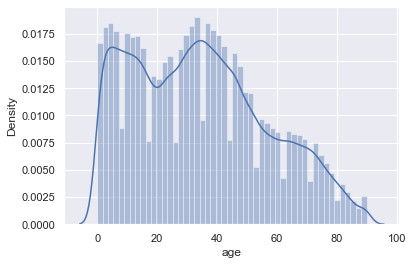

Category frequency of variable: class_of_worker


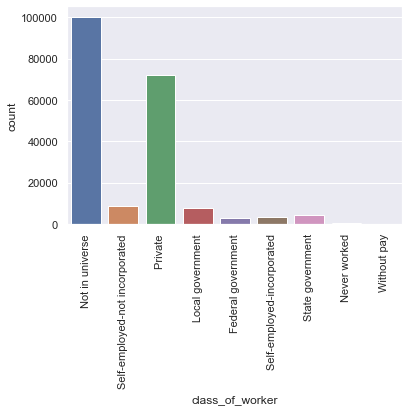

Distribution of variable: detailed_industry_recode


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


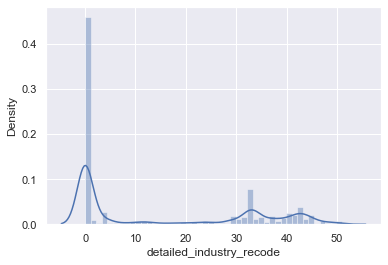

Distribution of variable: detailed_occupation_recode


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


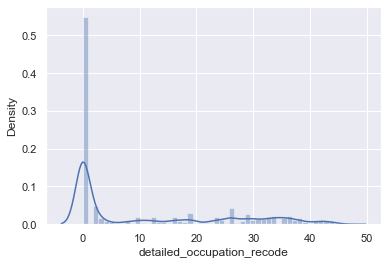

Category frequency of variable: education


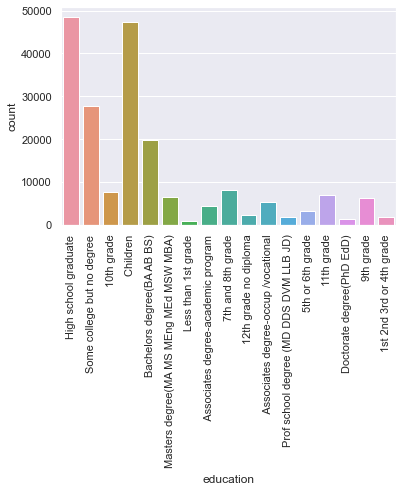

Distribution of variable: wage_per_hour


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


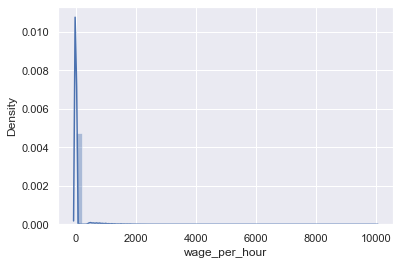

Category frequency of variable: enroll_in_edu_inst_last_wk


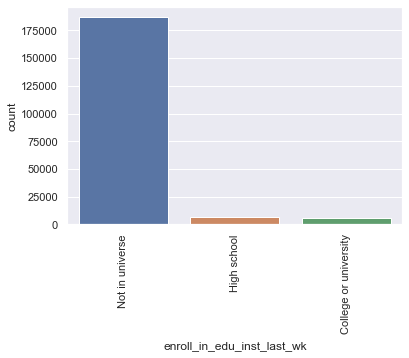

Category frequency of variable: marital_stat


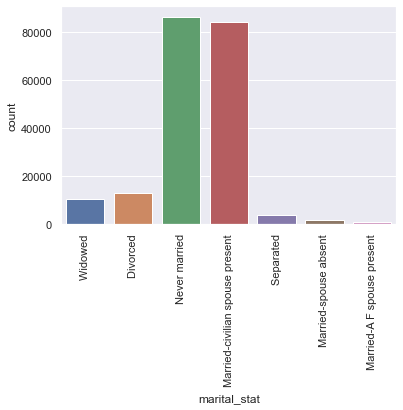

Category frequency of variable: major_industry_code


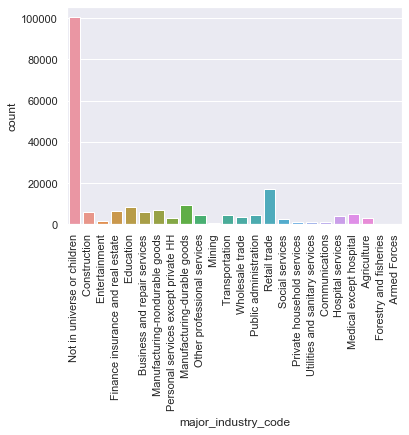

Category frequency of variable: major_occupation_code


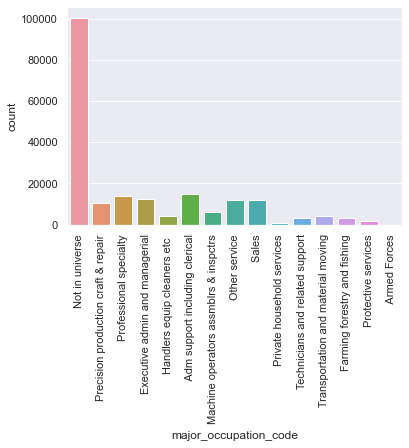

Category frequency of variable: race


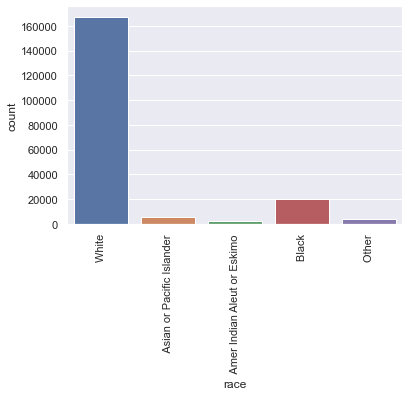

Category frequency of variable: hispanic_origin


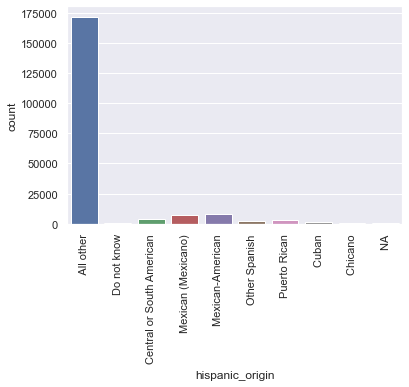

Category frequency of variable: sex


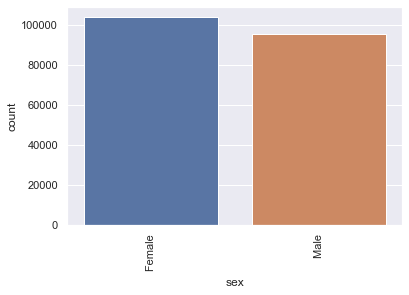

Category frequency of variable: member_of_a_labor_union


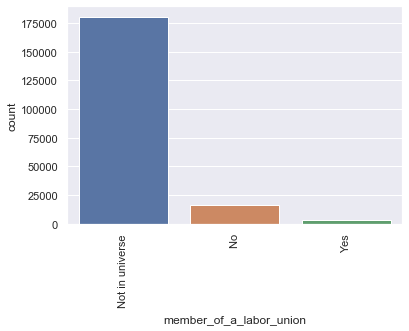

Category frequency of variable: reason_for_unemployment


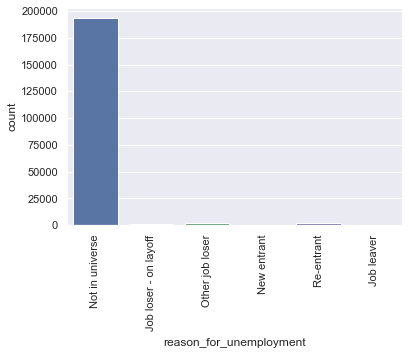

Category frequency of variable: full_or_part_time_employment_stat


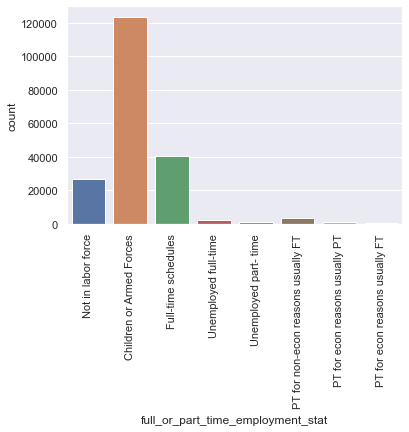

Distribution of variable: capital_gains


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


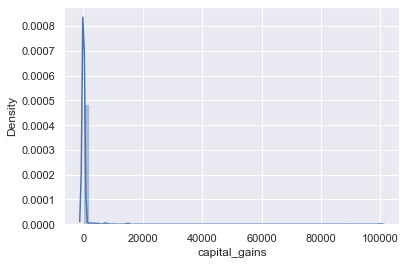

Distribution of variable: capital_losses


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


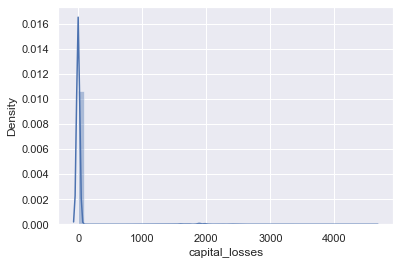

Distribution of variable: dividends_from_stocks


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


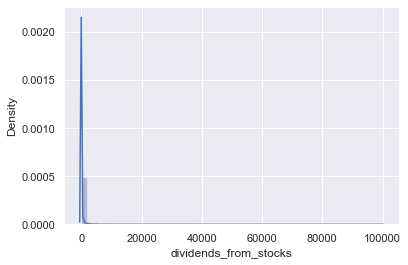

Category frequency of variable: tax_filer_stat


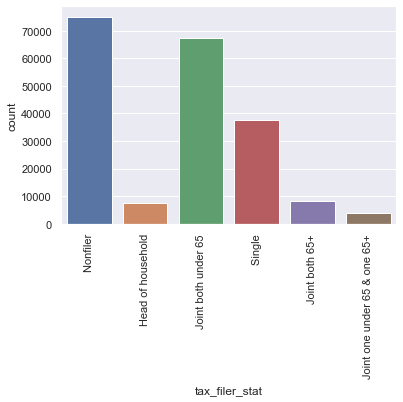

Category frequency of variable: region_of_previous_residence


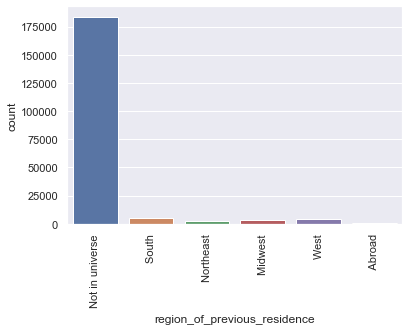

Category frequency of variable: state_of_previous_residence


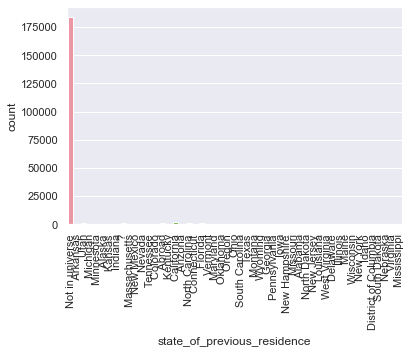

Category frequency of variable: detailed_household_and_family_stat


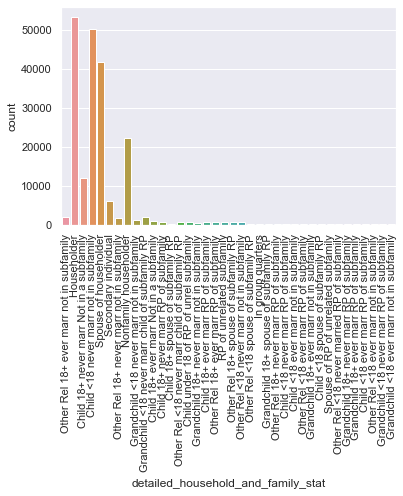

Category frequency of variable: detailed_household_summary_in_household


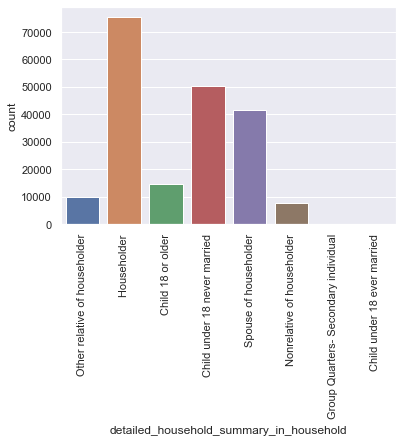

Distribution of variable: instance_weight


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


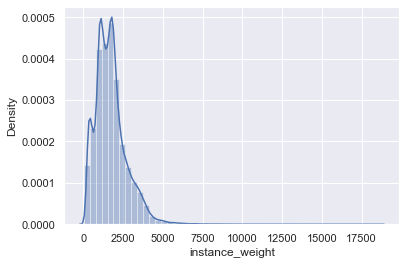

Category frequency of variable: migration_code-change_in_msa


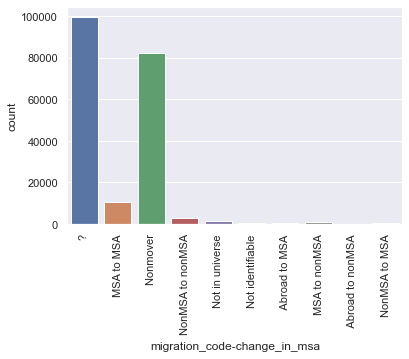

Category frequency of variable: migration_code-change_in_reg


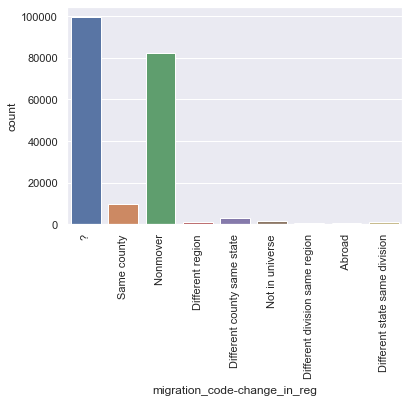

Category frequency of variable: migration_code-move_within_reg


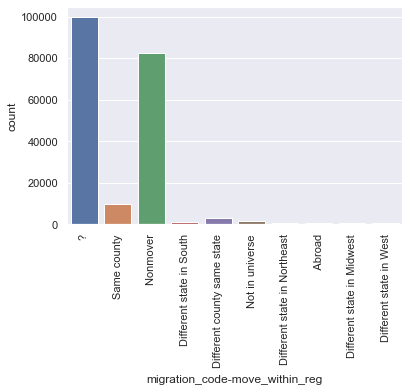

Category frequency of variable: live_in_this_house_1_year_ago


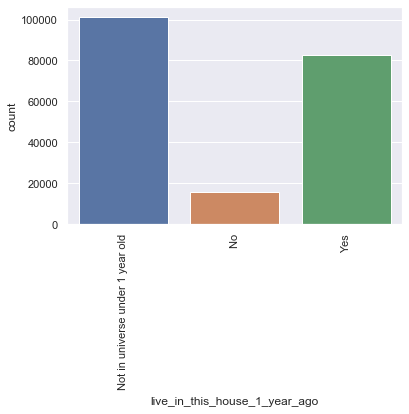

Category frequency of variable: migration_prev_res_in_sunbelt


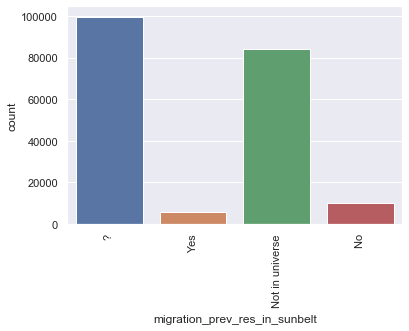

Distribution of variable: num_persons_worked_for_employer


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


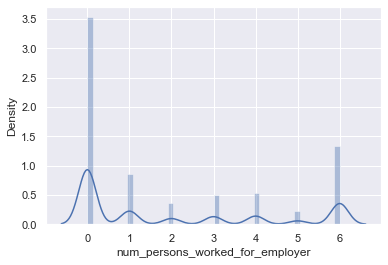

Category frequency of variable: family_members_under_18


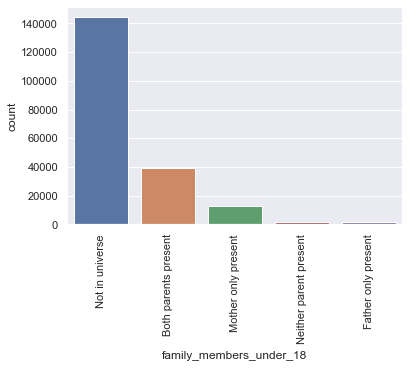

Category frequency of variable: country_of_birth_father


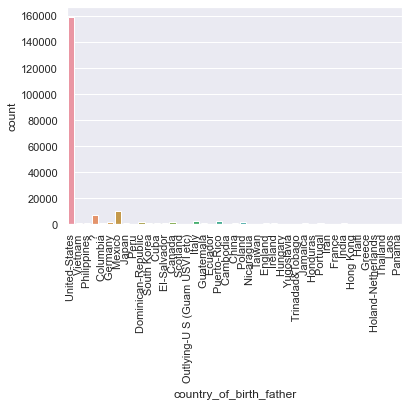

Category frequency of variable: country_of_birth_mother


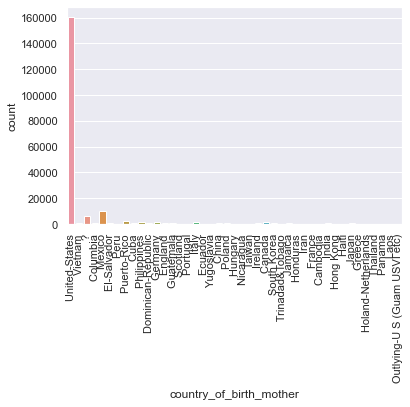

Category frequency of variable: country_of_birth_self


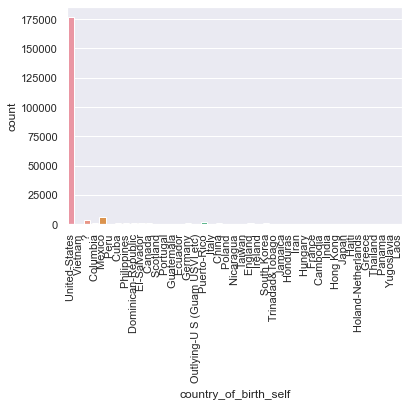

Category frequency of variable: citizenship


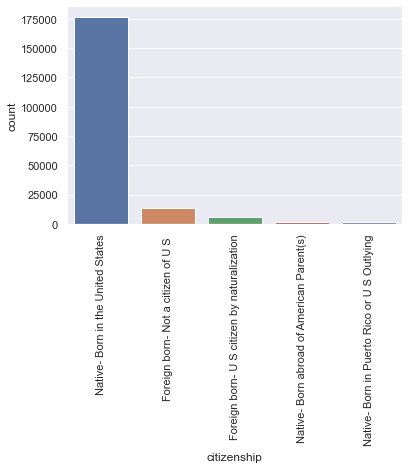

Distribution of variable: own_business_or_self_employed


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


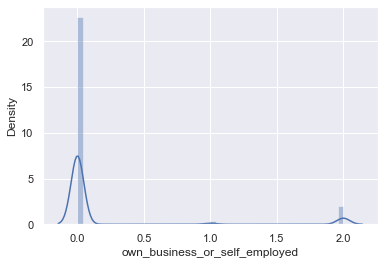

Category frequency of variable: fill_inc_questionnaire_for_veteran's_admin


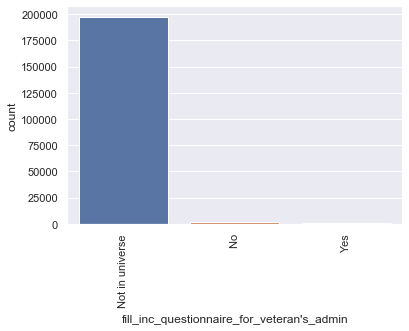

Distribution of variable: veterans_benefits


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


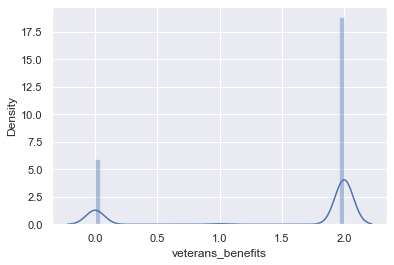

Distribution of variable: weeks_worked_in_year


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


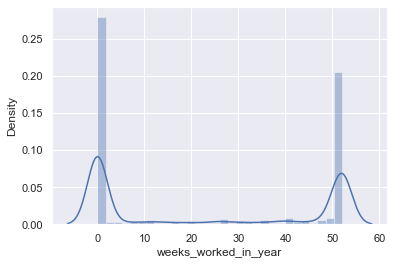

Distribution of variable: year


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


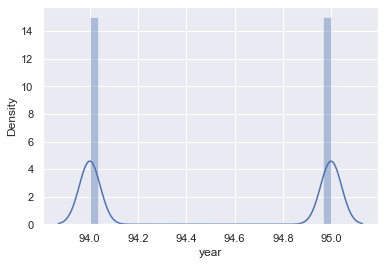

Distribution of variable: income


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


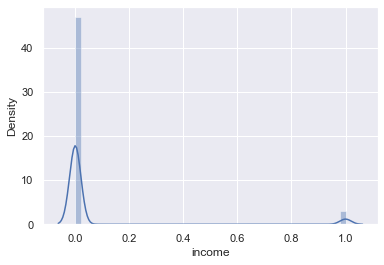

In [14]:
# Plot all data columns for inspections. This is a very simple visualisation to eyeball
# the data at hand, the different categories of each features and distribution of the 
# continous ones
sns.set(font_scale = 1)

for i,feat in enumerate(data_learn.columns):
    plt.figure(i)
    plot_hist(feat, data_learn)
    plt.show()

- Note that many features have high frequency of 'Not in Universe' entry . 
- Need to explore further: is this a NA or a valid entry. 
- Unfortunately the dataset metadata does not help to solve this. I'll treat these as valid 

#### Missing values

In [15]:
### Calculate missing values in each columns
def missing_values_table(df):
    """
    Takes as input a dataframe, checks which columns contain 
    missing values, returns their count and percentage.
    
    Parameters
    ----------
    df : pd.DataFrame 
        Full dataframe to check missing values.

    Returns
    -------
    A DataFrame with two columns containing the missing values
    and percentage of values missing for each affected variable.
    """
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)  
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [16]:
print('Learn:')
missing_values_table(data_learn)
print('\nTest:')
missing_values_table(data_test)

Learn:
The selected dataframe has 42 columns.
There are 0 columns that have missing values.

Test:
The selected dataframe has 42 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

##### Note:
There are no NAs in neither dataset

### 1.2 Numerical features
Let's explore here the relationship of each numerical feature to the income variable

In [17]:
numerical_cols = ['age',
            'wage_per_hour',
            'capital_gains',
            'capital_losses',
            'dividends_from_stocks',
            'num_persons_worked_for_employer',
            'weeks_worked_in_year']

In [18]:
data_learn[numerical_cols].describe()

age  wage_per_hour  capital_gains  capital_losses  \
count  199523.000000  199523.000000   199523.00000   199523.000000   
mean       34.494199      55.426908      434.71899       37.313788   
std        22.310895     274.896454     4697.53128      271.896428   
min         0.000000       0.000000        0.00000        0.000000   
25%        15.000000       0.000000        0.00000        0.000000   
50%        33.000000       0.000000        0.00000        0.000000   
75%        50.000000       0.000000        0.00000        0.000000   
max        90.000000    9999.000000    99999.00000     4608.000000   

       dividends_from_stocks  num_persons_worked_for_employer  \
count          199523.000000                    199523.000000   
mean              197.529533                         1.956180   
std              1984.163658                         2.365126   
min                 0.000000                         0.000000   
25%                 0.000000                         0.000000   
50%                 0.000000                         1.000000   
75%                 0.000000                         4.000000   
max             99999.000000                         6.000000   

       weeks_worked_in_year  
count         199523.000000  
mean              23.174897  
std               24.411488  
min                0.000000  
25%                0.000000  
50%                8.000000  
75%               52.000000  
max               52.000000

#### Correlation matrix

##### Comments: 
 wage_per_hour is the least correlated variable to the income category.capital_gains exhibits the highest correlation.

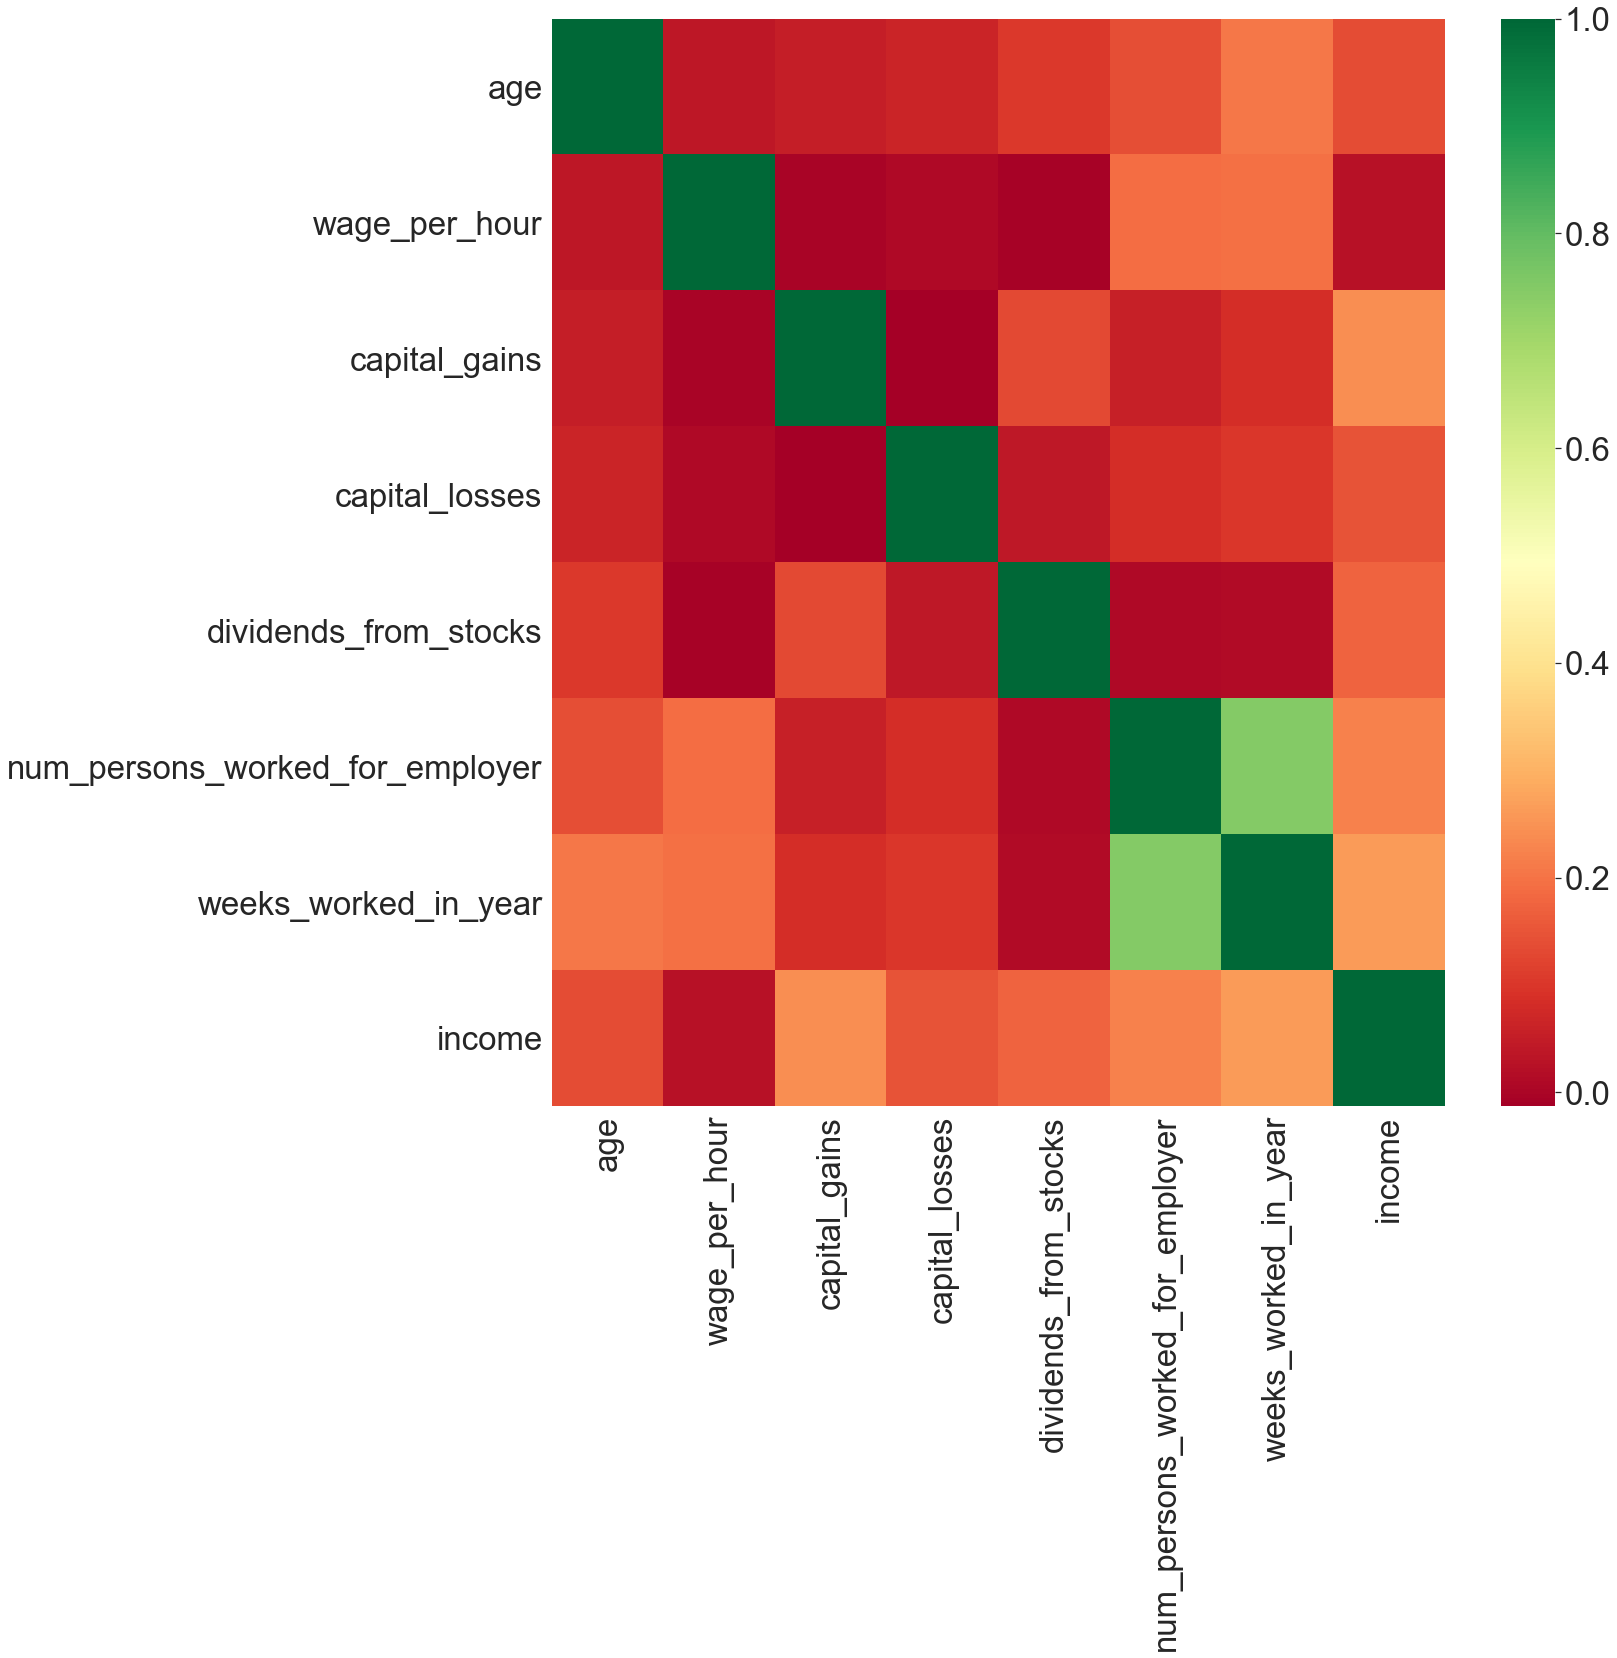

In [19]:
# correlation matrix
cor = data_learn[numerical_cols+['income']].corr()
# coliumns for display
col_disp = list(cor.index)
# display correlation matrix between numerical features as a heatmap
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
sns.heatmap(cor, cmap="RdYlGn",xticklabels=col_disp,yticklabels=col_disp)

printmd('##### Comments: \n \
wage_per_hour is the least correlated variable to the income category.\
capital_gains exhibits the highest correlation.')

#### Pairwise plot

/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


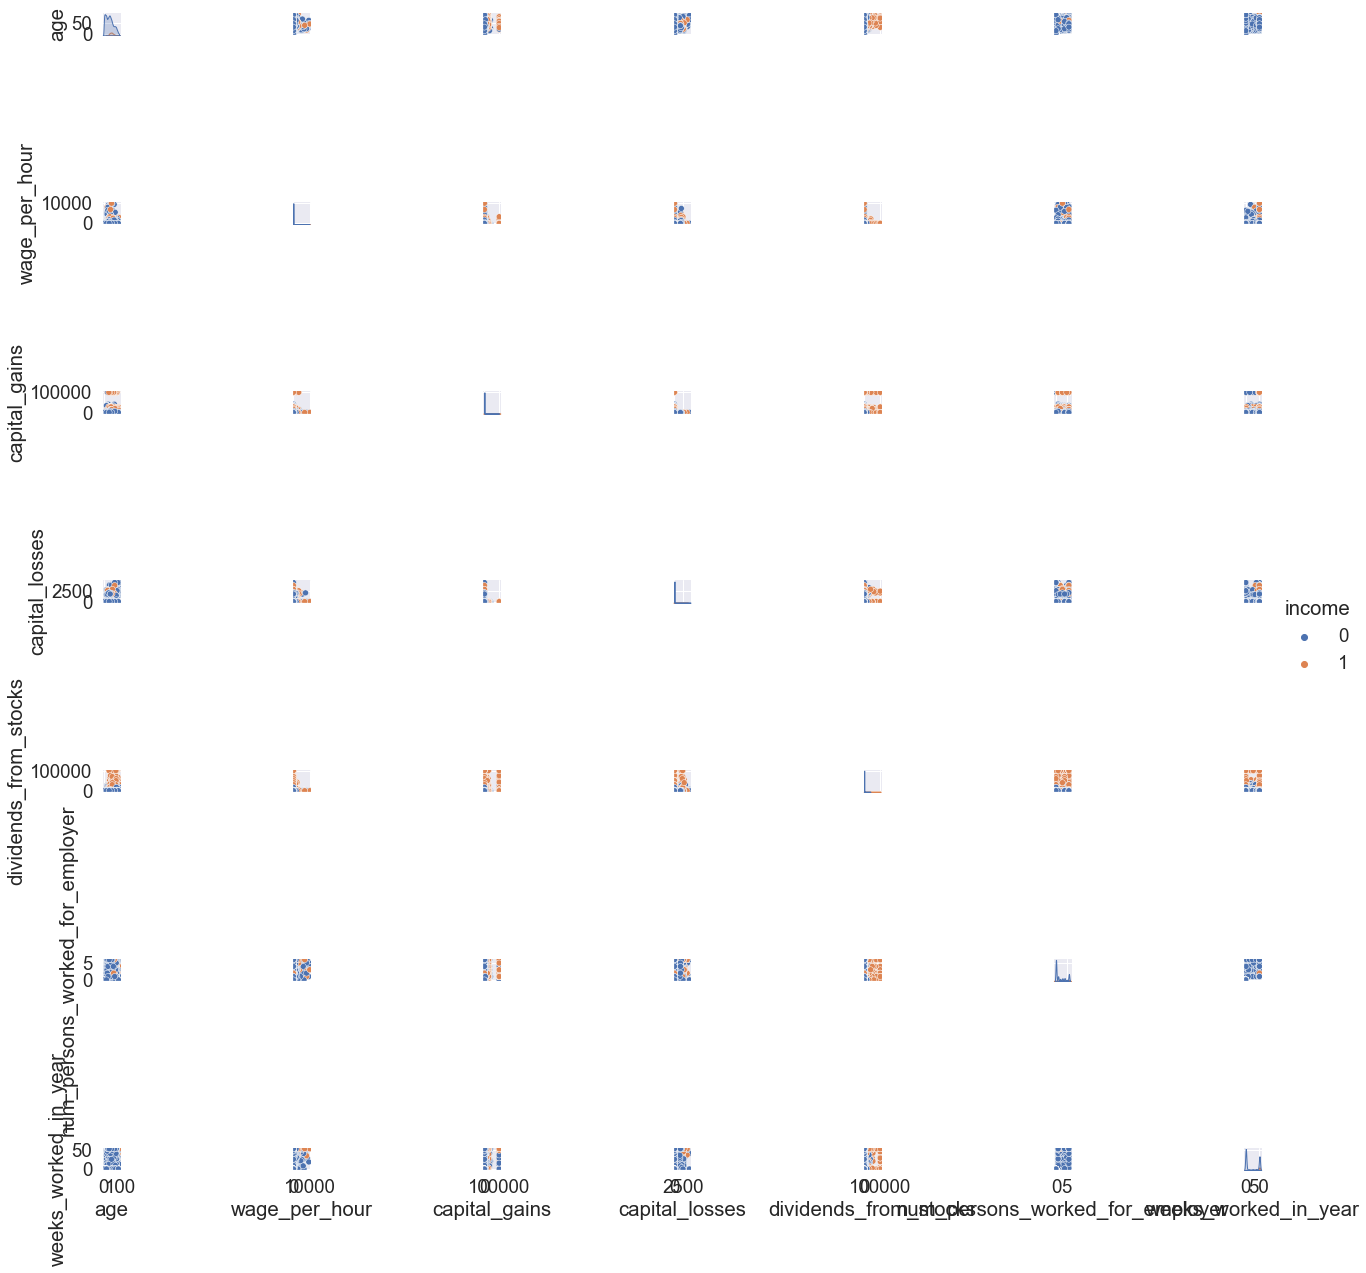

In [20]:
sns.set(font_scale = 1.7)
sns.pairplot(data_learn[numerical_cols+['income']], hue = 'income')

In [21]:
# create boxplots to visulaize the continuous features
def boxplot_by_income(col):
    """
    Produce a boxplot of the column 'col', for each income level (aboce and below $50k)
    
    Parameters
    ----------
    col : str
        Name of column to chart.
    Returns
    -------
    None
    """
    fig, chart = plt.subplots(figsize=(15,10))
    plt.title("Boxplots of feature %s depending on income level"%col,
             fontsize=18)
    sns.boxplot(x='income', 
                y=col,
                palette=["blue", "orange"],
                data=data_learn)
    return

#### 1.2.1 Age

##### Comments: 
 High income earners are older on average than low income earners. The first quartile falls at 38 years old (vs 16 in the low income), and the third quartile at 55 (vs 50).

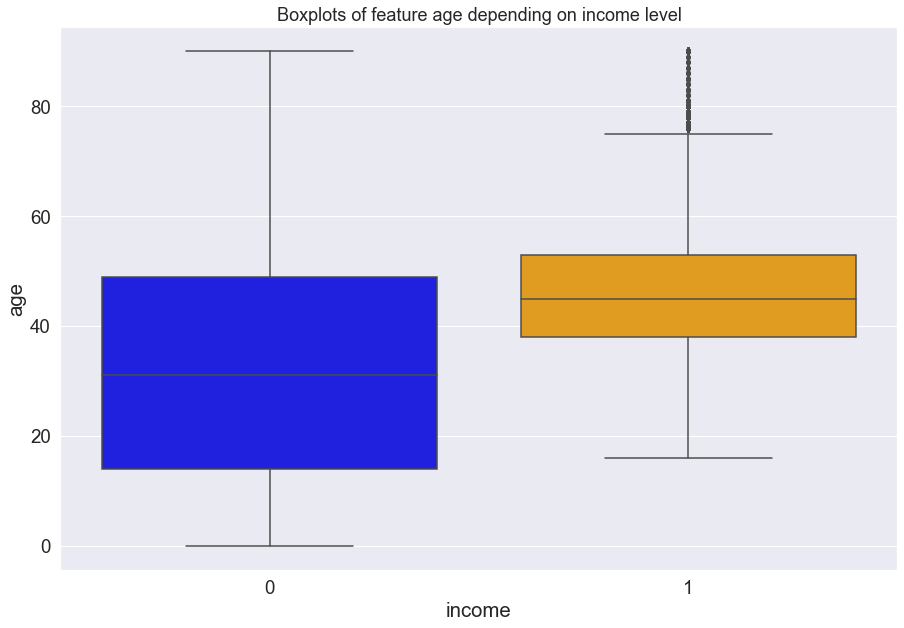

In [22]:
printmd('#### 1.2.1 Age')
printmd('##### Comments: \n \
High income earners are older on average than low income earners. The first quartile falls \
at 38 years old (vs 16 in the low income), and the third quartile at 55 (vs 50).')
boxplot_by_income('age')

#### 1.2.2 Wage per hour

##### Comments: 
 Unexpectedly the vast majority of the population have an hourly wage of 0. The 90th percentile is 0 for the low income category, and the 95th for the high income class. There may be a fault in this feature reporting

Summary:
       wage_per_hour                                                   
               count       mean         std  min  25%  50%  75%     max
income                                                                 
0           187141.0  53.692526  261.168380  0.0  0.0  0.0  0.0  9916.0
1            12382.0  81.640284  431.364773  0.0  0.0  0.0  0.0  9999.0


Percentiles 90th, 95th and 99th:
             wage_per_hour
income                    
0      0.90           0.00
       0.95         500.00
       0.99        1300.00
1      0.90           0.00
       0.95           0.00
       0.99        2303.23


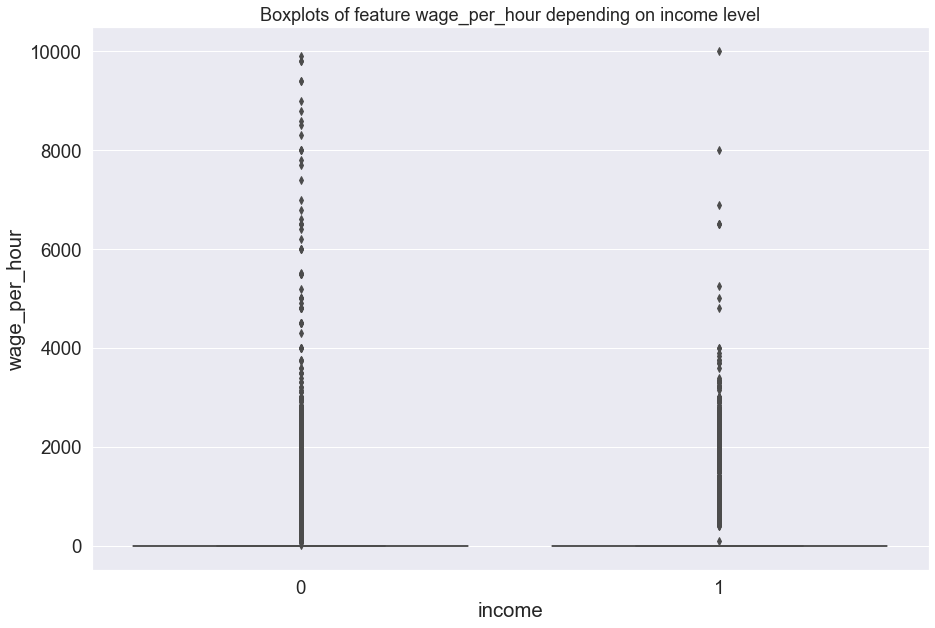

In [23]:
printmd('#### 1.2.2 Wage per hour')
printmd('##### Comments: \n \
Unexpectedly the vast majority of the population have an hourly wage of 0. The 90th \
percentile is 0 for the low income category, and the 95th for the high income class. \
There may be a fault in this feature reporting')
col ='wage_per_hour'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 90th, 95th and 99th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.9, 0.95, 0.99]))

#### 1.2.3 Capital gains

##### Comments: 
 Contrary to wage income, capital income is less frequent. For this feature, observing that the vast majority of the population in both income groups has no capital gains seems correct. Moreover, the high income class made on average 16,887 of gains, while the low income class only 1,800.

Summary:
       capital_gains                                                        
               count         mean           std  min  25%  50%  75%      max
income                                                                      
0           187141.0   143.848013   1815.343341  0.0  0.0  0.0  0.0  99999.0
1            12382.0  4830.930060  16887.627002  0.0  0.0  0.0  0.0  99999.0


Percentiles 80th, 90th and 95th:
             capital_gains
income                    
0      0.80            0.0
       0.90            0.0
       0.95            0.0
1      0.80            0.0
       0.90        15024.0
       0.95        15024.0


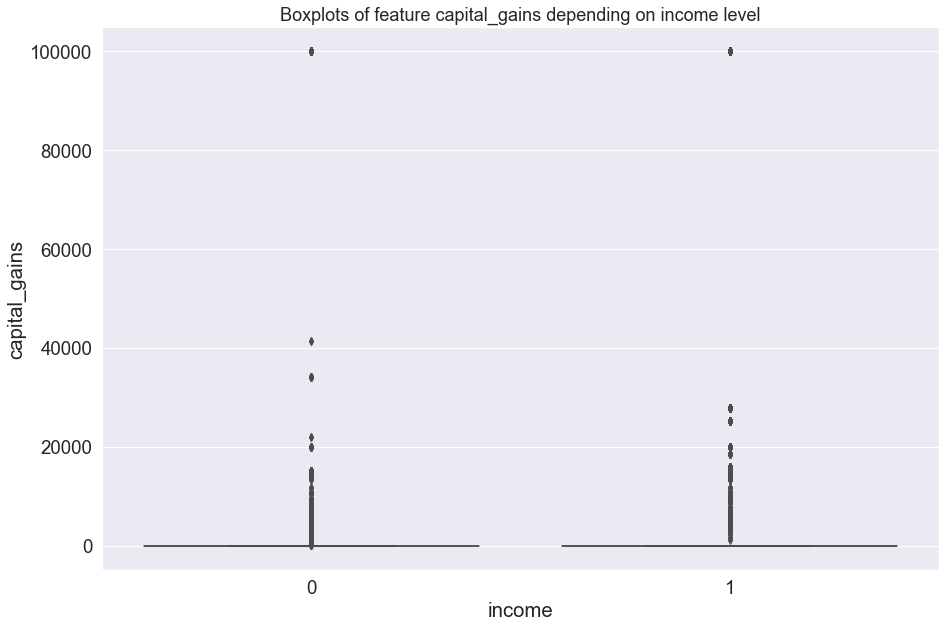

In [24]:
printmd('#### 1.2.3 Capital gains')
printmd('##### Comments: \n \
Contrary to wage income, capital income is less frequent. For this feature, \
observing that the vast majority of the population in both income groups has no \
capital gains seems correct. Moreover, the high income class made on average 16,887 \
of gains, while the low income class only 1,800.')
col = 'capital_gains'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 80th, 90th and 95th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.8, 0.9, 0.95]))

#### 1.2.4 Capital losses

##### Comments: 
 Similar interpretation to capital gains. The high income earners have lost more than the low income earners.

Summary:
       capital_losses                                                    
                count        mean         std  min  25%  50%  75%     max
income                                                                   
0            187141.0   27.003730  229.535067  0.0  0.0  0.0  0.0  4608.0
1             12382.0  193.139557  607.542507  0.0  0.0  0.0  0.0  3683.0


Percentiles 80th, 90th and 95th:
             capital_losses
income                     
0      0.80             0.0
       0.90             0.0
       0.95             0.0
1      0.80             0.0
       0.90             0.0
       0.95          1977.0


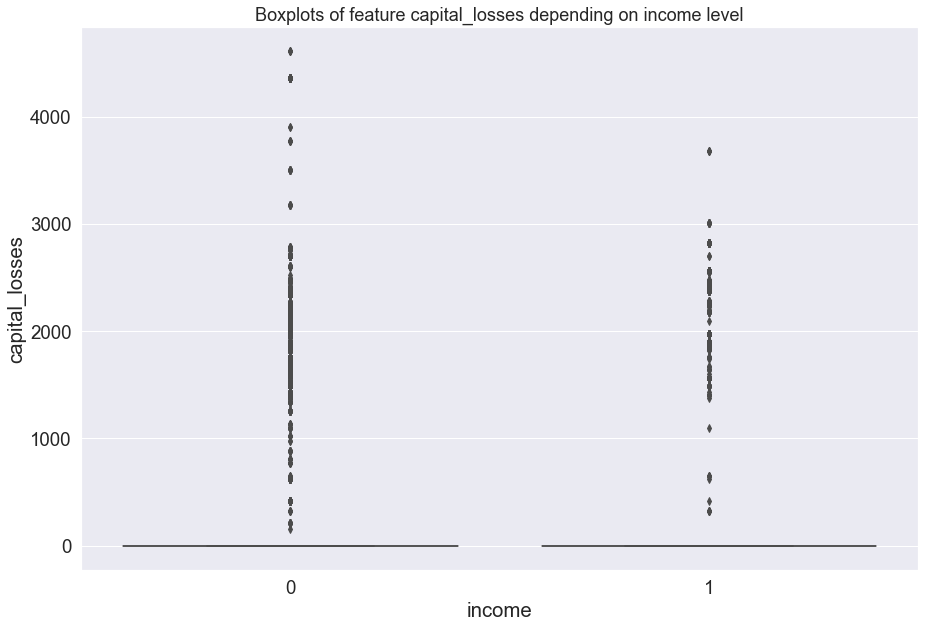

In [25]:
printmd('#### 1.2.4 Capital losses')
printmd('##### Comments: \n \
Similar interpretation to capital gains. The high income earners have lost more than \
the low income earners.')
col = 'capital_losses'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 80th, 90th and 95th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.8, 0.9, 0.95]))

#### 1.2.5 Dividends

##### Comments: 
 A larger share of the high income earners has had any revenue from dividends. The 60th perentile of high earners has received a dividenddt, while the 90th percentile of the low earners has not. On average, the high earners maded 6,998 while the low earners 909.

Summary:
       dividends_from_stocks                                                  \
                       count         mean          std  min  25%  50%    75%   
income                                                                         
0                   187141.0   107.816518   909.774217  0.0  0.0  0.0    0.0   
1                    12382.0  1553.448070  6998.071762  0.0  0.0  0.0  363.0   

                 
            max  
income           
0       39000.0  
1       99999.0  


Percentiles 60th, 80th and 90th:
            dividends_from_stocks
income                           
0      0.6                    0.0
       0.8                    0.0
       0.9                    0.0
1      0.6                   20.0
       0.8                  600.0
       0.9                 2500.0


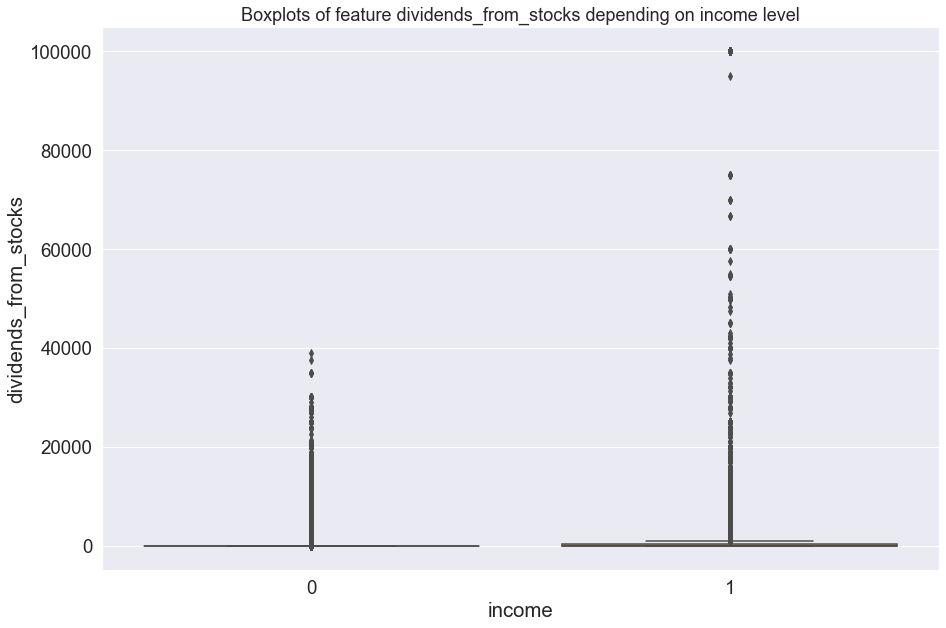

In [26]:
printmd('#### 1.2.5 Dividends')
printmd('##### Comments: \n \
A larger share of the high income earners has had any revenue from dividends. \
The 60th perentile of high earners has received a dividenddt, while the 90th \
percentile of the low earners has not. On average, the high earners maded 6,998 \
while the low earners 909.')
col = 'dividends_from_stocks'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 60th, 80th and 90th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.6, 0.8, 0.9]))


#### 1.2.6 Employer number of employees

##### Comments: 
 The population with an income lower than $50k tend to work in smaller companies, with an average of 1.8 employees, than people earning over 50k (at an average of 4.8 employees). When looking at the median, it is 0 for the low income category (i.e. at least 50% of the people are freelancers or unemployed), and 4 for the high income category.

Summary:
       num_persons_worked_for_employer                                     \
                                 count      mean       std  min  25%  50%   
income                                                                      
0                             187141.0  1.820707  2.317618  0.0  0.0  0.0   
1                              12382.0  4.003715  2.118183  0.0  2.0  4.0   

                  
        75%  max  
income            
0       4.0  6.0  
1       6.0  6.0  


Percentiles 60th, 80th and 90th:
            num_persons_worked_for_employer
income                                     
0      0.6                              1.0
       0.8                              4.0
       0.9                              6.0
1      0.6                              6.0
       0.8                              6.0
       0.9                              6.0


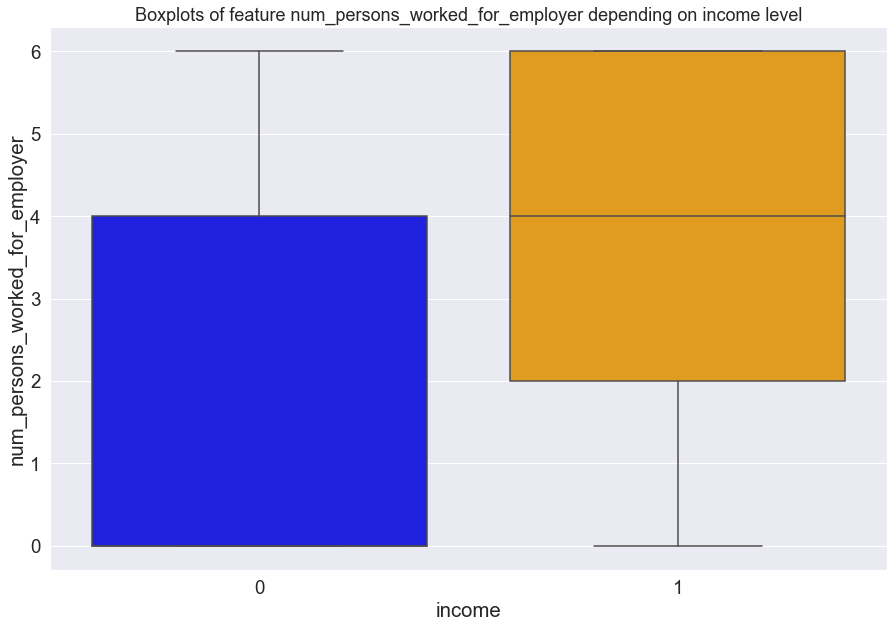

In [27]:
printmd('#### 1.2.6 Employer number of employees')
printmd('##### Comments: \n \
The population with an income lower than $50k tend to work in smaller companies, with an \
average of 1.8 employees, than people earning over 50k (at an average of 4.8 employees). \
When looking at the median, it is 0 for the low income category (i.e. at least 50% of the \
people are freelancers or unemployed), and 4 for the high income category.')
col = 'num_persons_worked_for_employer'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 60th, 80th and 90th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.6, 0.8, 0.9]))

#### 1.2.7 Weeks worked

##### Comments: 
 .

Summary:
       weeks_worked_in_year                                                   
                      count       mean        std  min   25%   50%   75%   max
income                                                                        
0                  187141.0  21.527762  24.118209  0.0   0.0   0.0  52.0  52.0
1                   12382.0  48.069617  12.259412  0.0  52.0  52.0  52.0  52.0


Percentiles 60th, 80th and 90th:
            weeks_worked_in_year
income                          
0      0.6                  30.0
       0.8                  52.0
       0.9                  52.0
1      0.6                  52.0
       0.8                  52.0
       0.9                  52.0


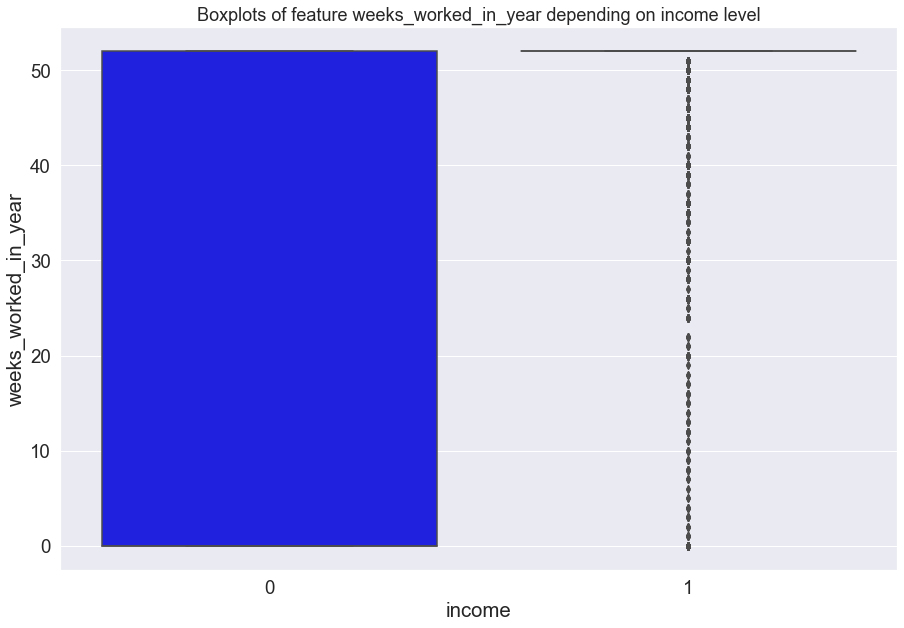

In [28]:
printmd('#### 1.2.7 Weeks worked')
printmd('##### Comments: \n \
.')
col = 'weeks_worked_in_year'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 60th, 80th and 90th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.6, 0.8, 0.9]))


#### 1.2.7 Weeks worked

##### Comments: 
 High income earners work more weeks, 48.06 vs 21.52 for low income earners. It could be that low earners tend to work part time more often than high earners, or that a substnatial amount of low earners do not work at all (i.e. children, unemployed...)

Summary:
       weeks_worked_in_year                                                   
                      count       mean        std  min   25%   50%   75%   max
income                                                                        
0                  187141.0  21.527762  24.118209  0.0   0.0   0.0  52.0  52.0
1                   12382.0  48.069617  12.259412  0.0  52.0  52.0  52.0  52.0


Percentiles 5th, 10th and 80th:
             weeks_worked_in_year
income                           
0      0.05                   0.0
       0.10                   0.0
       0.80                  52.0
1      0.05                   4.0
       0.10                  42.0
       0.80                  52.0


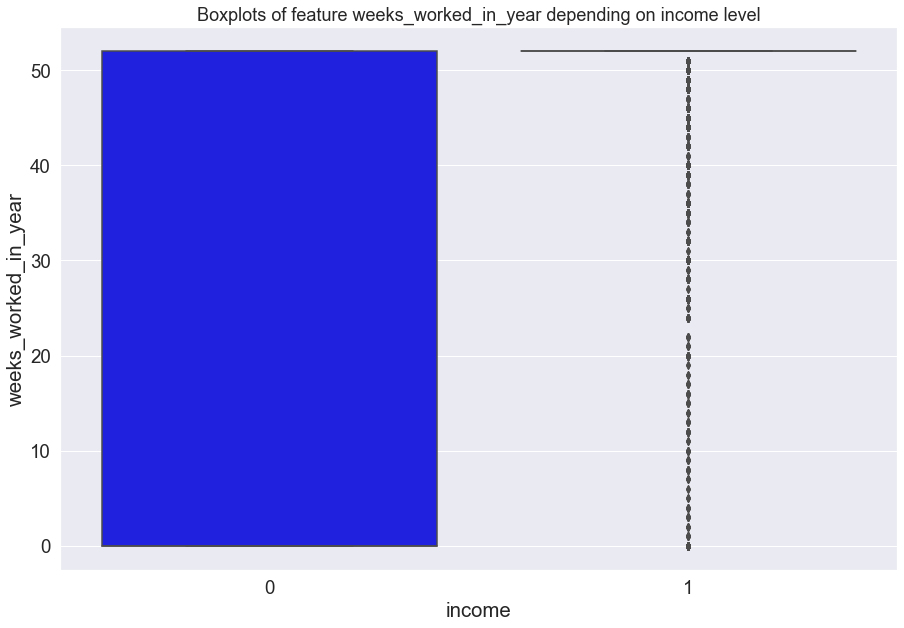

In [29]:
printmd('#### 1.2.7 Weeks worked')
printmd('##### Comments: \n \
High income earners work more weeks, 48.06 vs 21.52 for low income earners. It could be that \
low earners tend to work part time more often than high earners, or that a substnatial \
amount of low earners do not work at all (i.e. children, unemployed...)')
col = 'weeks_worked_in_year'
boxplot_by_income(col)
print('Summary:')
print(data_learn[[col, 'income']].groupby('income').describe())
print('\n\nPercentiles 5th, 10th and 80th:')

print(data_learn[[col, 'income']].groupby('income').quantile([0.05, 0.1, 0.8]))


### 1.3 Categorical features
Let's explore here the relationship of each categorical feature to the income variable

In [30]:
# Proportion distribution of each feature - helpers
sns.set(font_scale = 1.5)

def shape_for_prop_chart(data, feature):
    """
    Shape data to a cross table of feature and target variable 'income'
    
    Parameters
    ----------
    data : pd.DataFrame 
        dataframe from which to extract the cross tab.
    feature : str 
        feature on which to extract the cross table.

    Returns
    -------
    A DataFrame with two columns, one for each income category,
    with the proportion falling en each for all the categories in feature
    """
    df = round(pd.crosstab(data[feature], data['income']).div(pd.crosstab(data[feature], data['income']).apply(sum,1),0),2)
    df.sort_values(by = 1, inplace = True)
    return df

def chart_proportion(shaped_df, feature):
    """
    Produce a chart of the proportion of each category in feature falling either 
    above or below $50k
    
    Parameters
    ----------
    shaped_df : pd.DataFrame 
        dataframe, output of shape_for_prop_chart
    feature : str 
        feature to chart.

    Returns
    -------
    None
    """
    title = f'Poportion distribution across {feature}'
    #plt.figure(figsize=(15,10))
    fig, chart = plt.subplots(figsize=(15,10))
    plt.title(title,  fontsize=18)
    low_bars = list(shaped_df[0])

    high_bars = list(shaped_df[1]) 
    r = list(range(len(shaped_df.index)))

    names = list(shaped_df.index)
    barWidth = 1
    plt.bar(r, low_bars, edgecolor='white', width=barWidth, label='income < $50k')
    for p in chart.patches:
        height = p.get_height()
        if len(r)>20:
            rot = 90
            font = 12
        else:
            font = 14
            rot = 0
        formt = '{:.0%}'
        chart.text(p.get_x()+p.get_width()/2.,
                    height - 0.05,
                    formt.format(height),
                    ha="center",
                    fontsize = font,
                    rotation=rot,
                    color='white') 
    plt.bar(r, high_bars, bottom=low_bars, edgecolor='white', width=barWidth, label='income > $50k')

    plt.yticks(fontsize=14)
    plt.xticks(r, names, fontweight='bold', rotation='vertical', fontsize=14)
    plt.legend(fontsize=14, loc='lower left')
    



    
    
def bar_chart(data, feature, col_order):
    """
    Produce a bar chart of observations count of each category in feature
    
    Parameters
    ----------
    data : pd.DataFrame 
        dataframe with all features
    feature : str 
        feature to chart.
    col_order : list 
        order to follow when plotting the columns.

    Returns
    -------
    None
    """
    title = f'Distribution of the feature {feature}'
    plt.figure(figsize=(15,10))
    chart = sns.countplot(x = feature,
                          data = data,
                          order= col_order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize = 14)
    #chart.set_yticklabels(chart.get_yticklabels(), fontsize = 14)

    chart.set(xlabel='', ylabel='Count')
    chart.set_title(title, fontsize = 18)
    total = len(data)
    for p in chart.patches:
        height = p.get_height()
        if len(col_order)>20:
            rot = 90
            font = 12
            formt = '{:.0%}'
        else:
            font = 14
            rot = 0
            formt = '{:.2%}'
        chart.text(p.get_x()+p.get_width()/2.,
                    height + 2500,
                    formt.format(height/total),
                    ha="center",
                    va="center",
                    fontsize = font,
                    rotation=rot) 
    
def chart_driver(data, feature):
    """ Print both proportions and occurence charts for feature"""
    data_shaped= shape_for_prop_chart(data_learn, feature)
    chart_proportion(data_shaped, feature)
    bar_chart(data, feature, list(data_shaped.index))



#### 1.3.1 Class of worker

##### Comments: 
 The largest part of the sample has an undefined occupation. However, we observe that self employed and the federal government employees are most likely to reveinve an income higher than $50k.

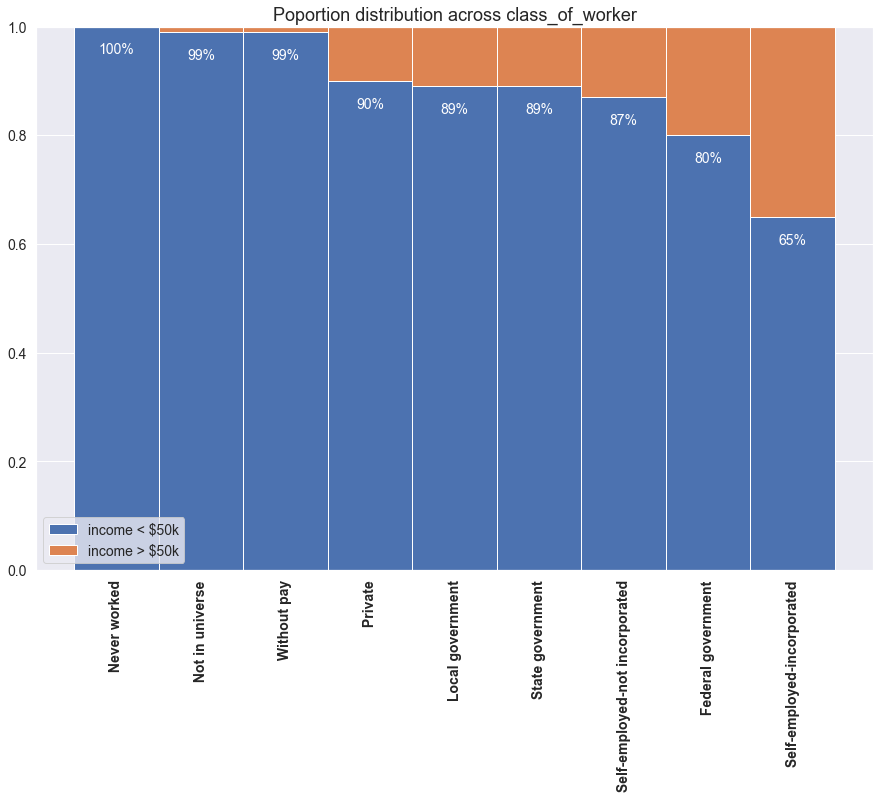

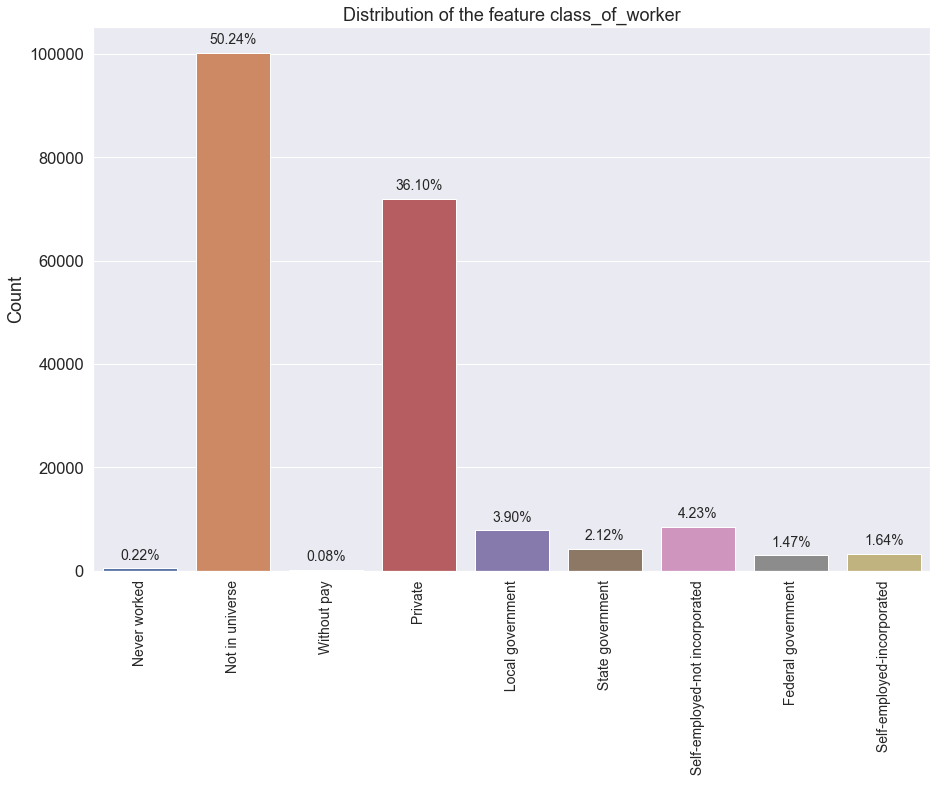

In [31]:
printmd('#### 1.3.1 Class of worker')
printmd('##### Comments: \n \
The largest part of the sample has an undefined occupation. \
However, we observe that self employed and the federal government \
employees are most likely to reveinve an income higher than $50k.')
chart_driver(data_learn, 'class_of_worker')

#### 1.3.2 Industry code

##### Comments: 
 About 50% of the sample is classified into industry 0, where 99% of its population is on the low income category. Top earners work in industries 25, 26 and 20.

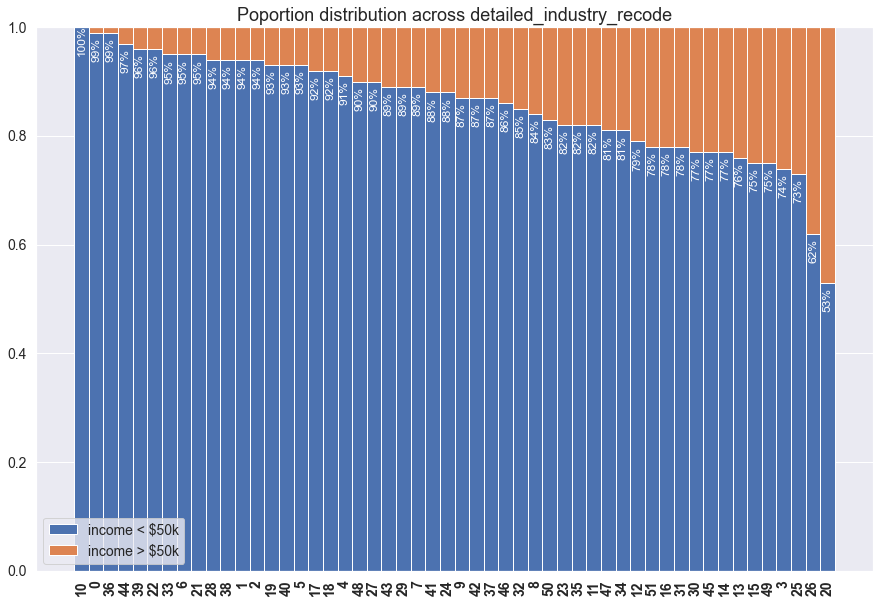

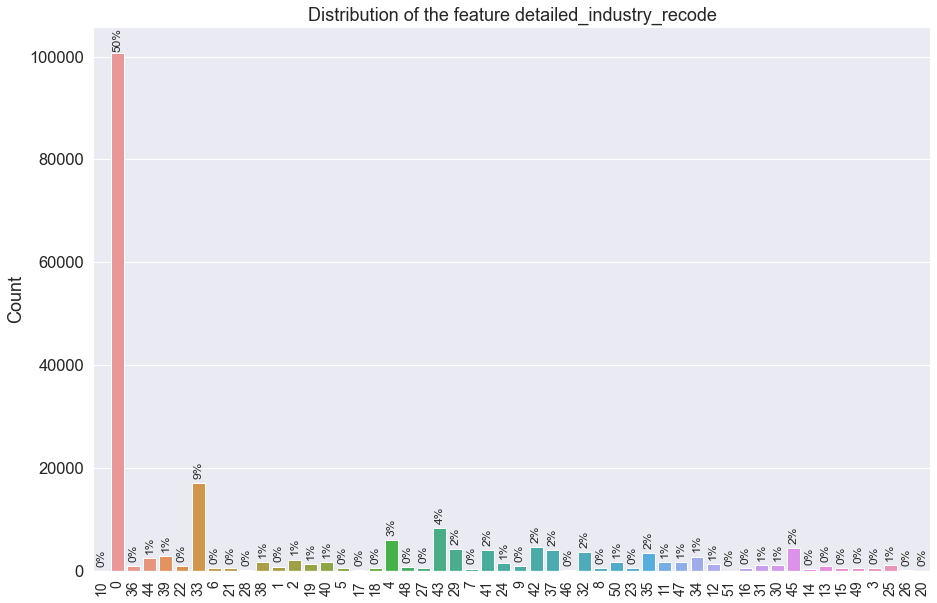

In [32]:
printmd('#### 1.3.2 Industry code')
printmd('##### Comments: \n \
About 50% of the sample is classified into industry 0, \
where 99% of its population is on the low income category. \
Top earners work in industries 25, 26 and 20.')
chart_driver(data_learn, 'detailed_industry_recode')

#### 1.3.3 Occupation code

##### Comments: 
 About 50% of the sample is classified into occupation 0, where 99% of its population is on the low income category. Occupations 4, 11 and 7 have the largest proportion of top earners, where more than 50% is in the high income category. Occupation 2 is also relevant  as it concentrates 5% of the population with 30% of high income earners

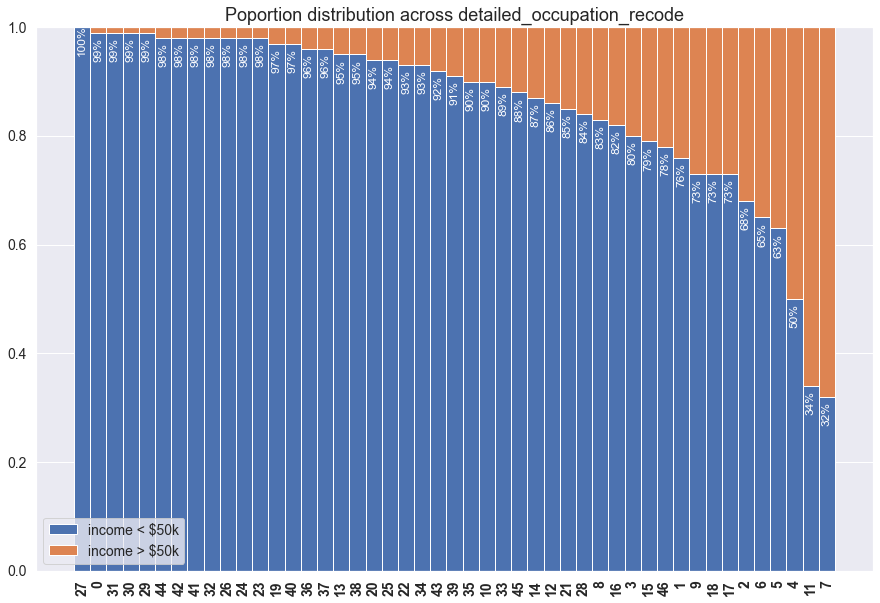

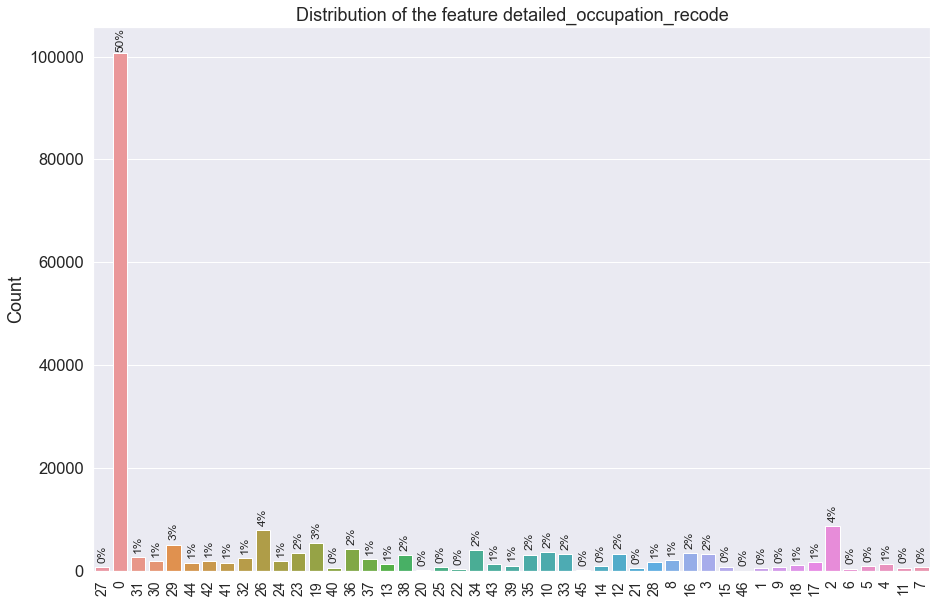

In [33]:
printmd('#### 1.3.3 Occupation code')
printmd('##### Comments: \n \
About 50% of the sample is classified into occupation 0, \
where 99% of its population is on the low income category. \
Occupations 4, 11 and 7 have the largest proportion of top earners, \
where more than 50% \
is in the high income category. Occupation 2 is also relevant  as it \
concentrates 5% of the population with 30% of high income earners')
chart_driver(data_learn, 'detailed_occupation_recode')

#### 1.3.4 Education

##### Comments: 
 23.7% of the sample is maded of children, where unexpectedly 100% earn less than $50K  The higher the educational level, the higher the proportion of high earners. Holders of a bachelor dedgree or higher (master, phd or professional qualification) all have at least 25% of high earners.

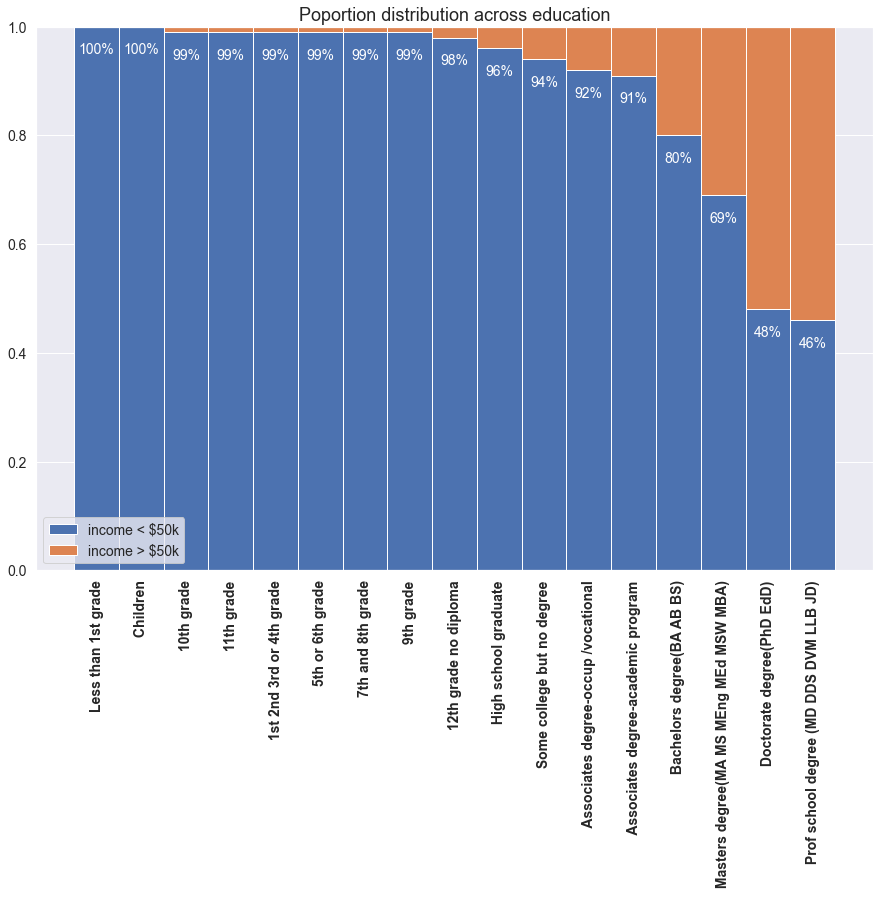

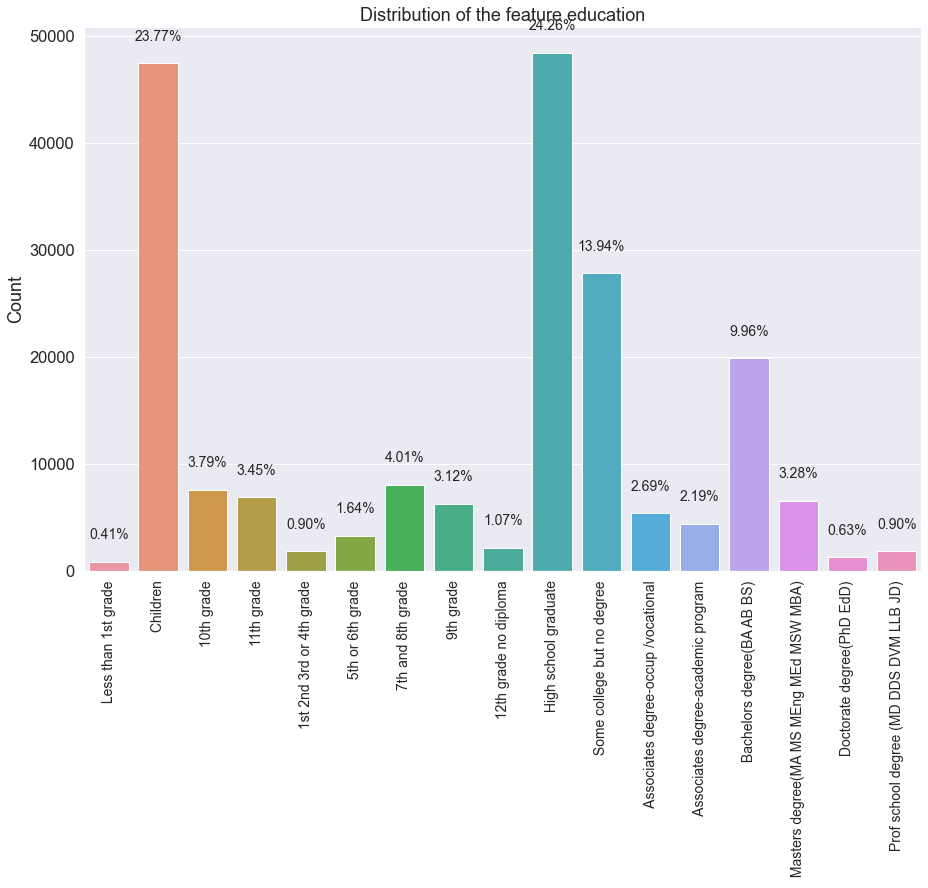

In [34]:
printmd('#### 1.3.4 Education')
printmd('##### Comments: \n \
23.7% of the sample is maded of children, where unexpectedly 100% earn less than $50K \
 \
The higher the educational level, the higher the proportion of high earners. \
Holders of a bachelor dedgree or higher (master, phd or professional qualification) \
all have at least 25% of high earners.')
chart_driver(data_learn, 'education')

#### 1.3.5 Enrolled in education

##### Comments: 
 93% of population was not enrolled in education last week. Of those who were, none is on the high income group

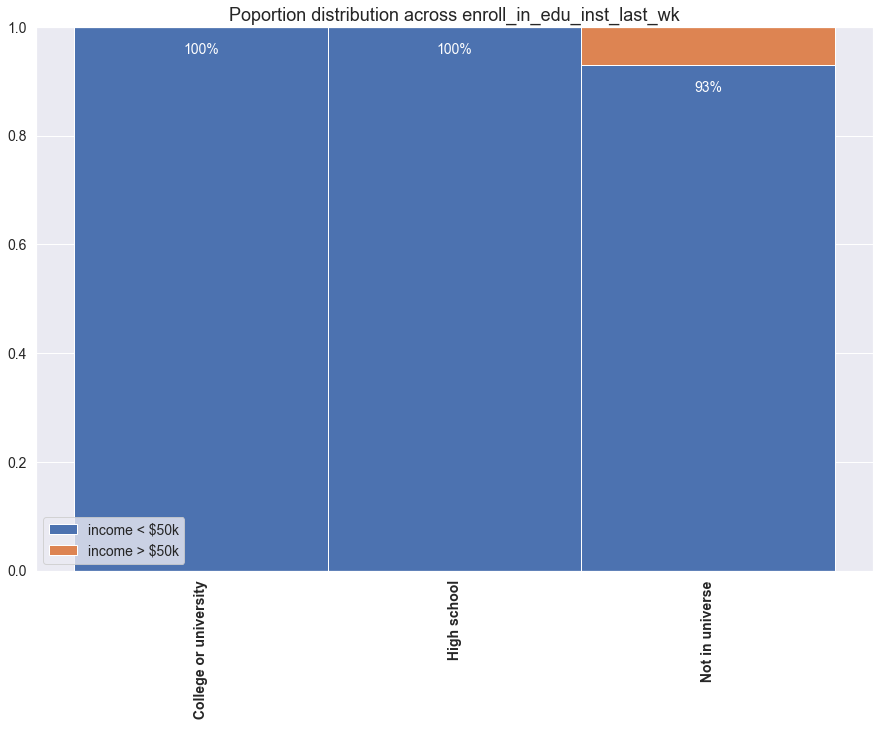

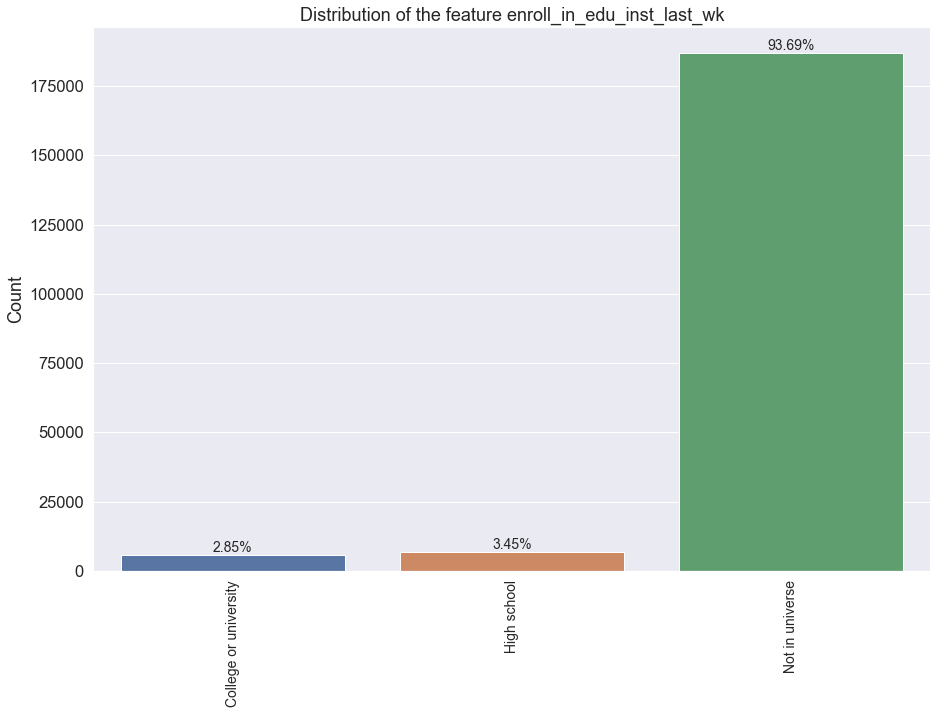

In [35]:
printmd('#### 1.3.5 Enrolled in education')
printmd('##### Comments: \n \
93% of population was not enrolled in education last week. Of those who were, \
none is on the high income group')
chart_driver(data_learn, 'enroll_in_edu_inst_last_wk')

#### 1.3.6 Marital status

##### Comments: 
 Married people have the largest share of high earners, while those who never married the lowest. There could be a strong correlation here with age, as marriage is expected to be found more widely in older individuals

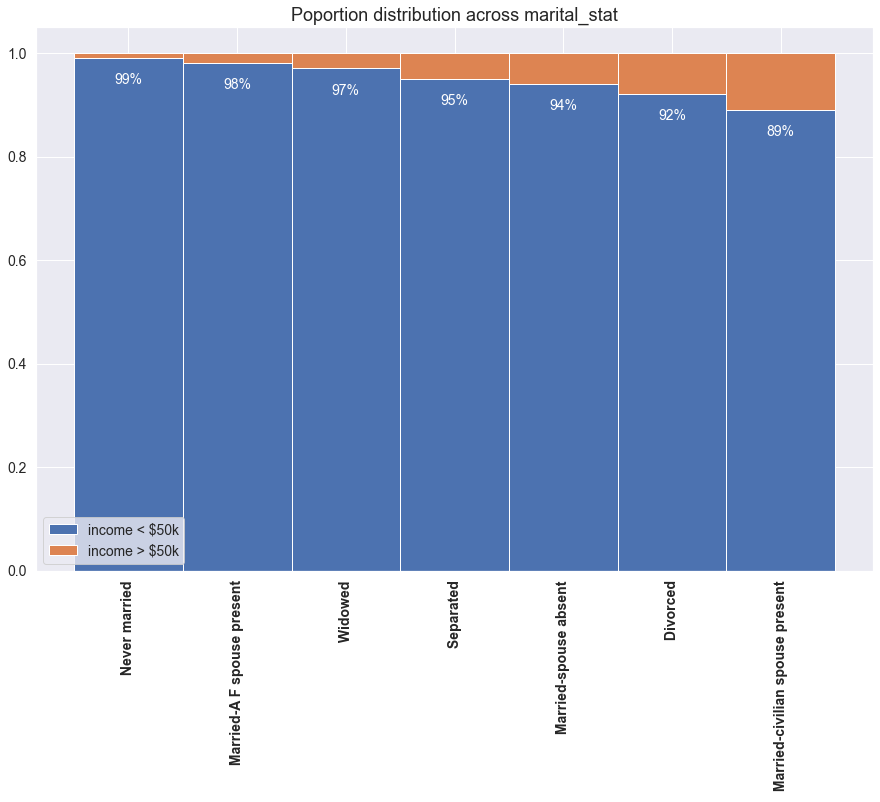

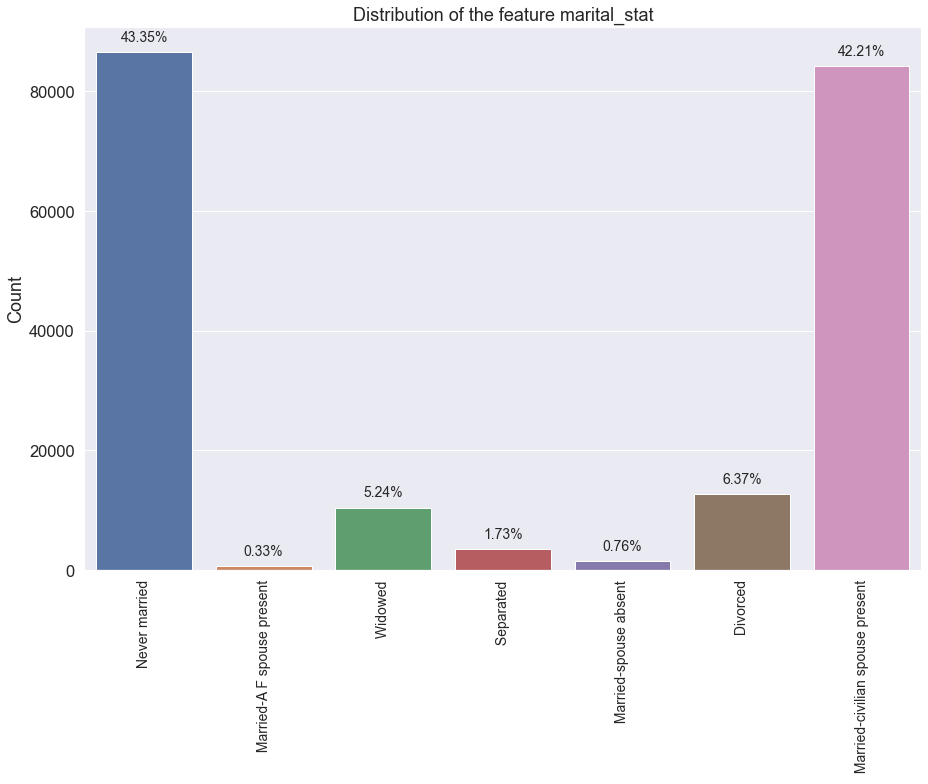

In [36]:
printmd('#### 1.3.6 Marital status')
printmd('##### Comments: \n \
Married people have the largest share of high earners, \
while those who never married the lowest. There could be a strong \
correlation here with age, as marriage is expected to be found more \
widely in older individuals')
chart_driver(data_learn, 'marital_stat')

#### 1.3.7 Major industry code

##### Comments: 
 This feature confirms that about 50% of the sample are children. The most lucrative industries professional services, communications and mining. Yet, the later two amount each to 1% of the population or less - so quite marginal

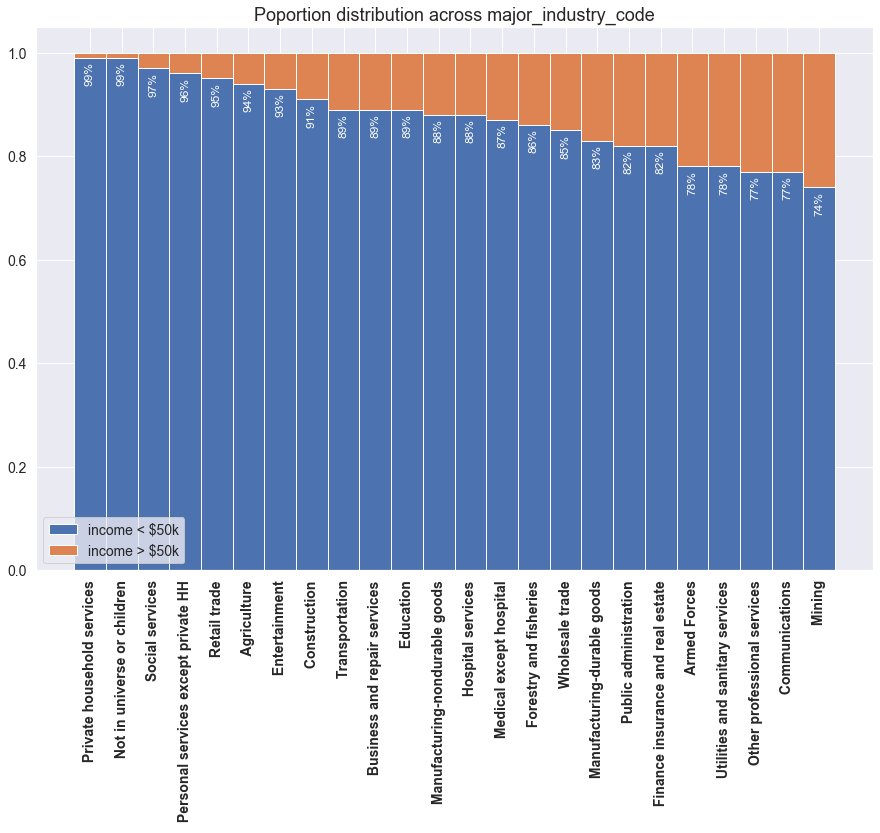

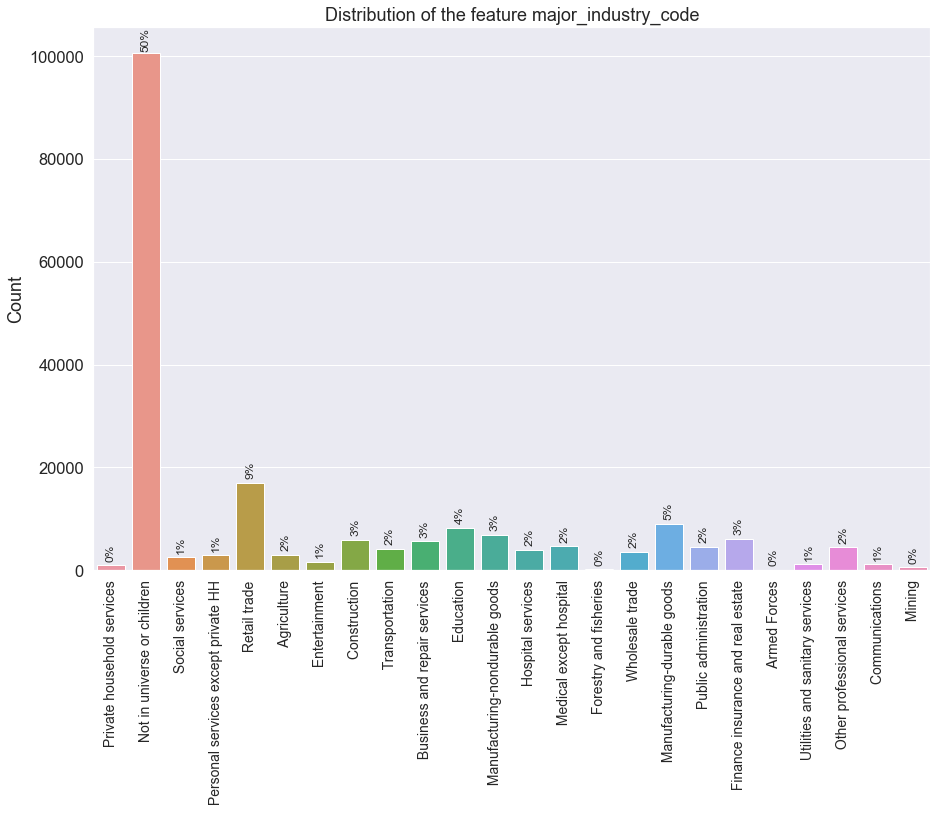

In [37]:
printmd('#### 1.3.7 Major industry code')
printmd('##### Comments: \n \
This feature confirms that about 50% of the sample are children. The most \
lucrative industries professional services, communications and mining. \
Yet, the later two amount each to 1% of the population or less - so quite marginal')
chart_driver(data_learn, 'major_industry_code')

#### 1.3.8 Major occupation code

##### Comments: 
 About 50% of the sample is classified in an undefined occupation, - the children category most likely where 99% of its population is on the low income category. Top earners work as executives, specialised professionals or the armed forces (though only 0.02% of the population).

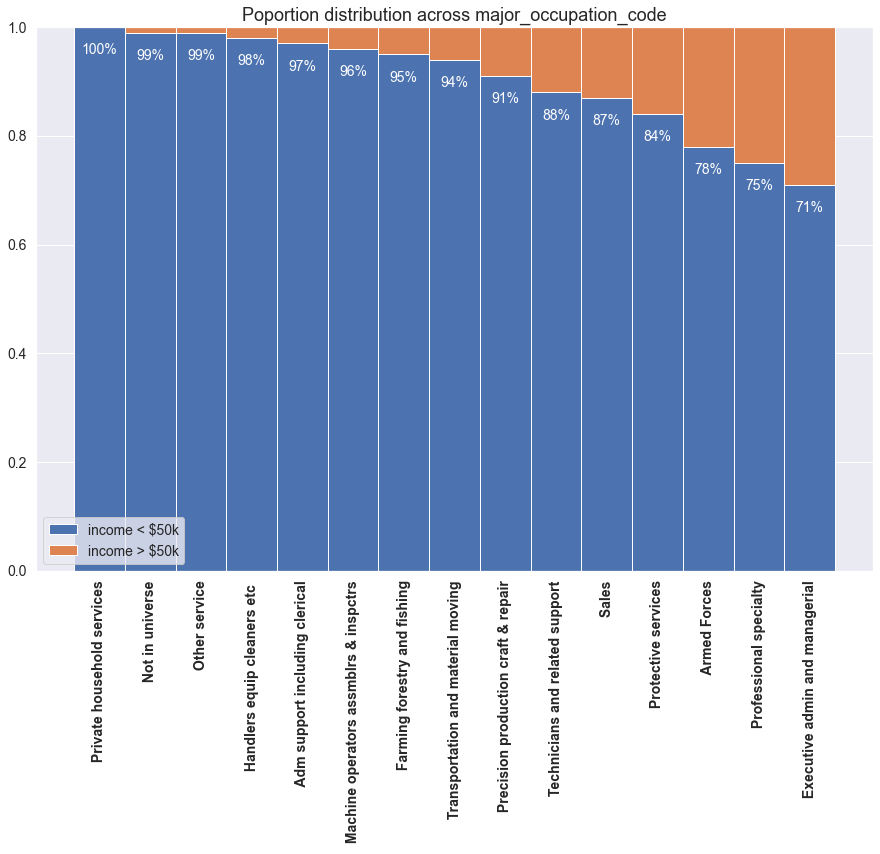

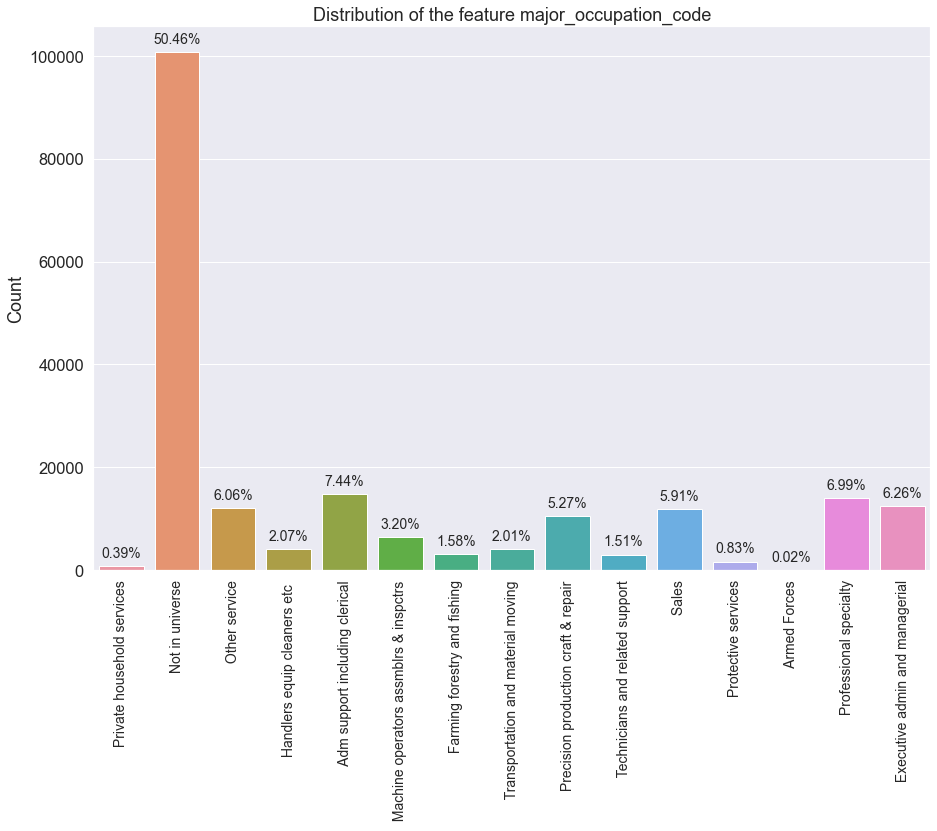

In [38]:
printmd('#### 1.3.8 Major occupation code')
printmd('##### Comments: \n \
About 50% of the sample is classified in an undefined occupation, \
- the children category most likely \
where 99% of its population is on the low income category. \
Top earners work as executives, specialised professionals or the armed forces \
(though only 0.02% of the population).')
chart_driver(data_learn, 'major_occupation_code')

#### 1.3.9 Race

##### Comments: 
 The population is predominantly white (83%). Together with Asians (2.9%) it is the group with largest proportion of high earners. The racial group with the lower earners are the Amerindians.

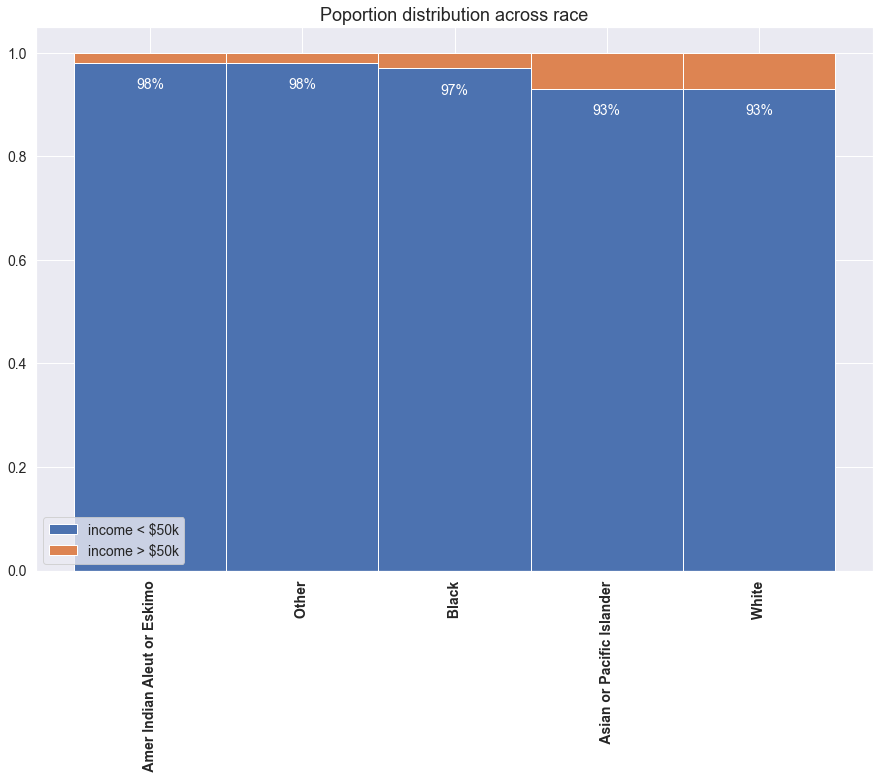

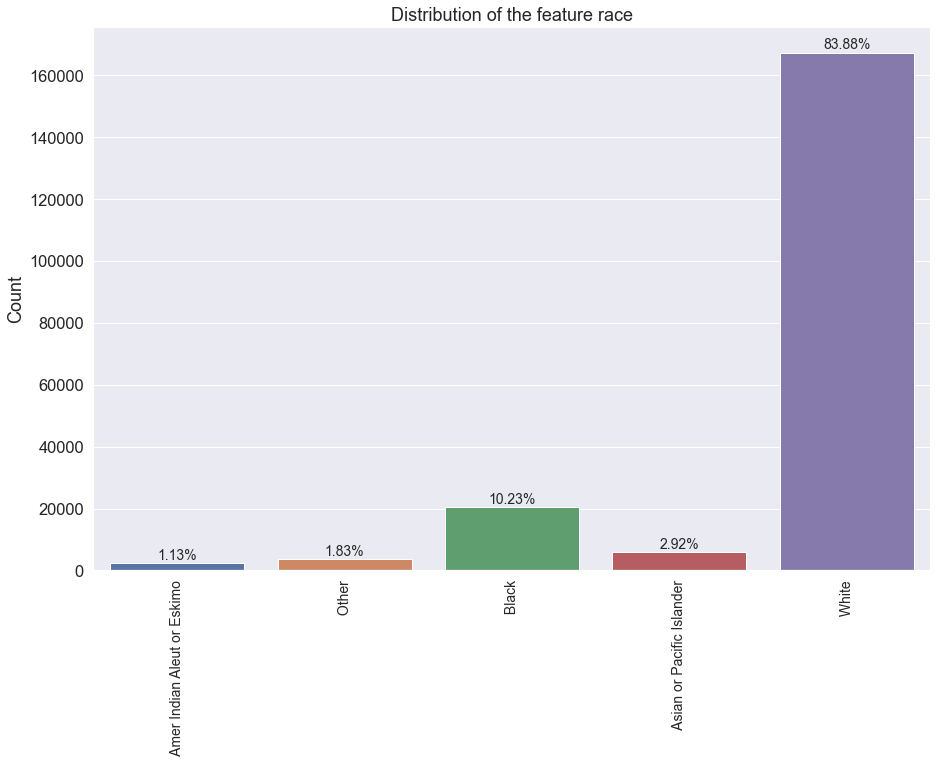

In [39]:
printmd('#### 1.3.9 Race')
printmd('##### Comments: \n \
The population is predominantly white (83%). Together with Asians (2.9%) \
it is the group with largest proportion of high earners. The racial group with the \
lower earners are the Amerindians.')
chart_driver(data_learn, 'race')

#### 1.3.10 Hispanic origin

##### Comments: 
 Being of any hispanic origin is correlated with lower incomes. However, Cubans are the origin with largest share of high earners. Most of the sample is not hispanic at all (86%).

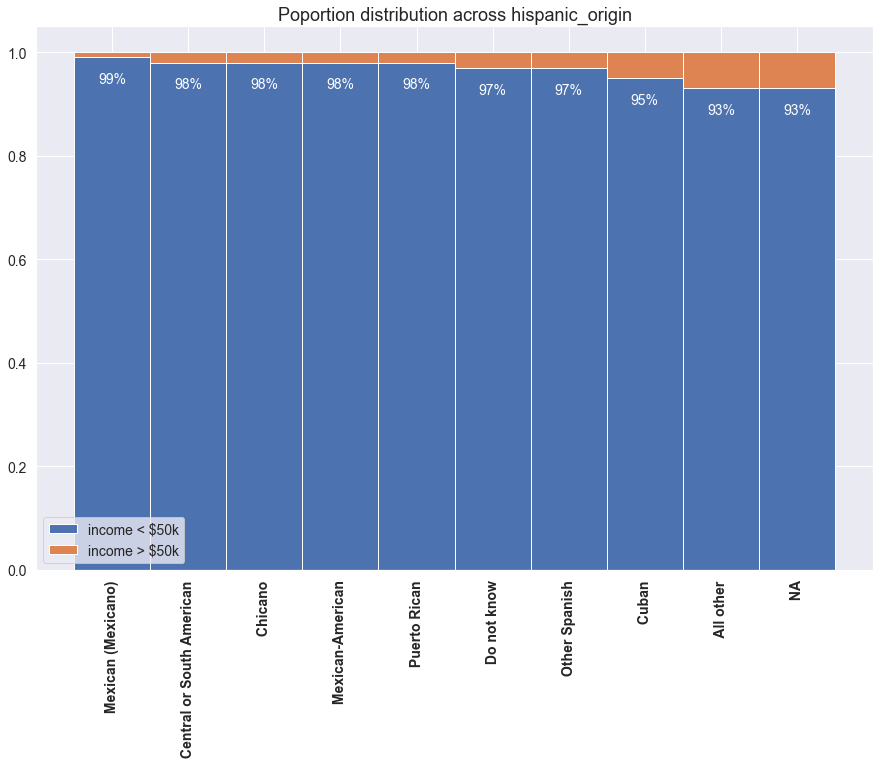

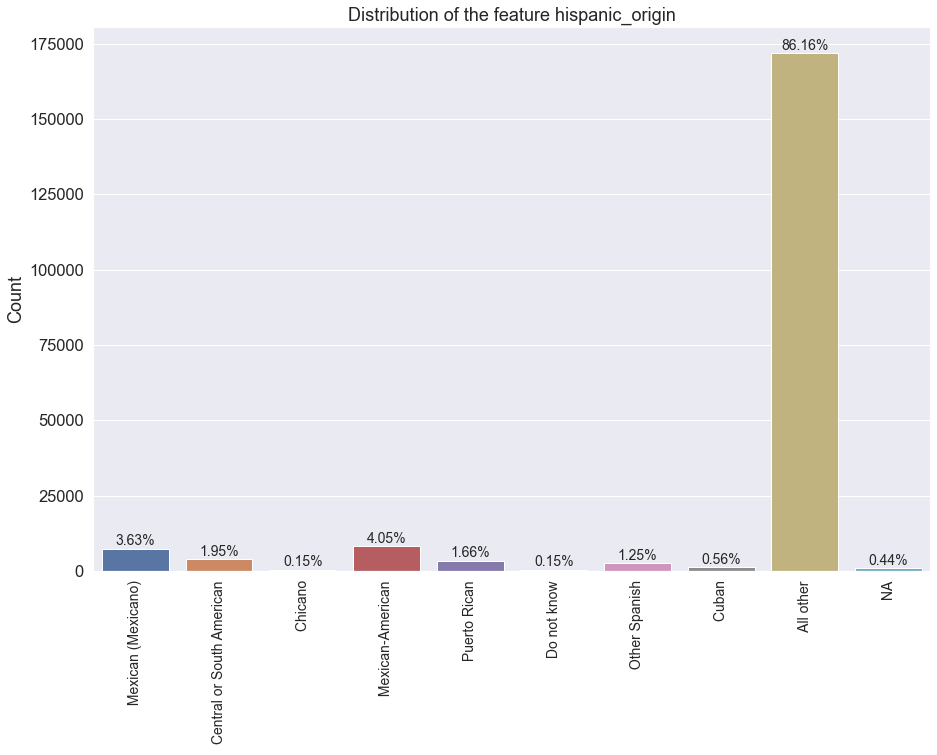

In [40]:
printmd('#### 1.3.10 Hispanic origin')
printmd('##### Comments: \n \
Being of any hispanic origin is correlated with lower incomes. However, \
Cubans are the origin with largest share of high earners. Most of the sample \
is not hispanic at all (86%).')
chart_driver(data_learn, 'hispanic_origin')

#### 1.3.11 Gender

##### Comments: 
 While only 3% of the female population (52% of the sample) earns more than $50k, for males the share goes up to 10%

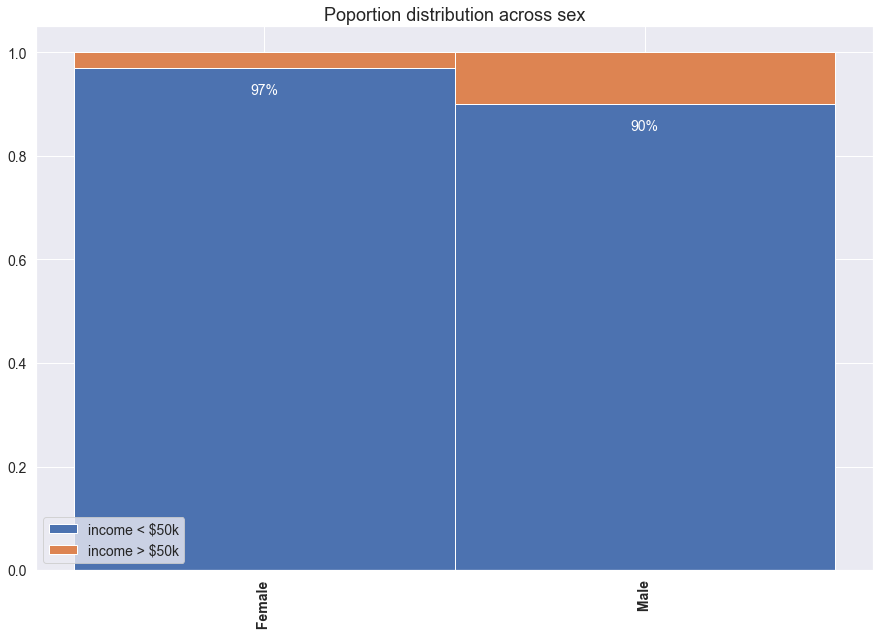

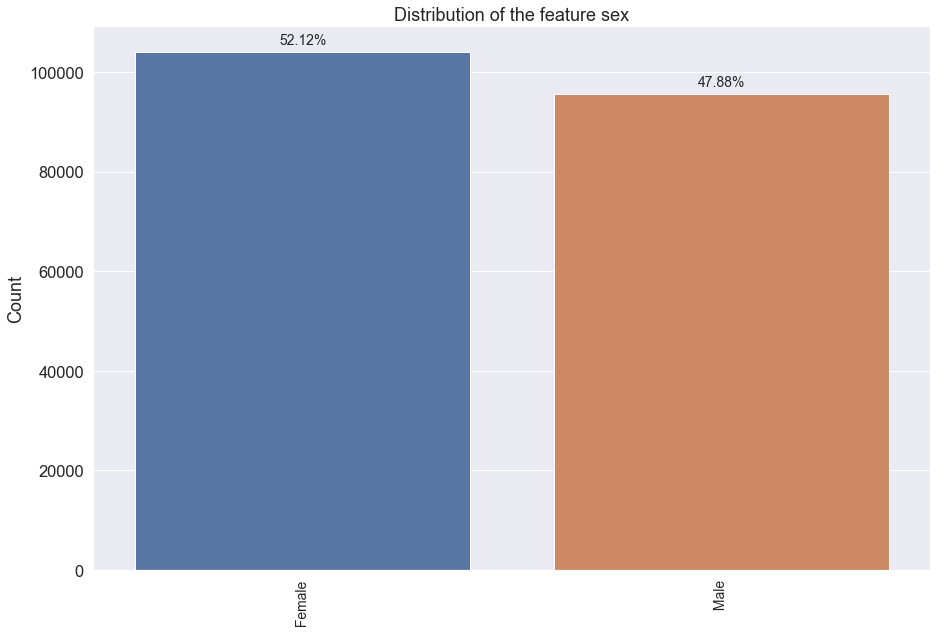

In [41]:
printmd('#### 1.3.11 Gender')
printmd('##### Comments: \n \
While only 3% of the female population (52% of the sample) earns more than \
$50k, for males the share goes up to 10%')
chart_driver(data_learn, 'sex')

#### 1.3.12 Member of labour union

##### Comments: 
 Only 1.5% of the population is a member of a labour union, 8% is not and 90% is not in the universe (NAs or children presumably). Being part of a union seems to be associated with a marginally higher proportion of large incomes (14% vs 11%) - though would need a significance test for additional confidence.

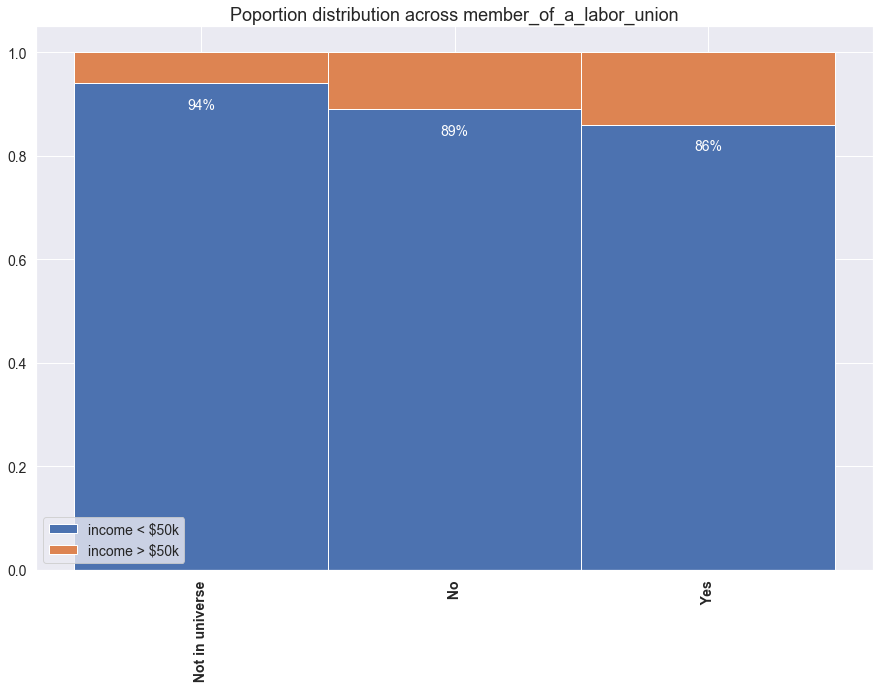

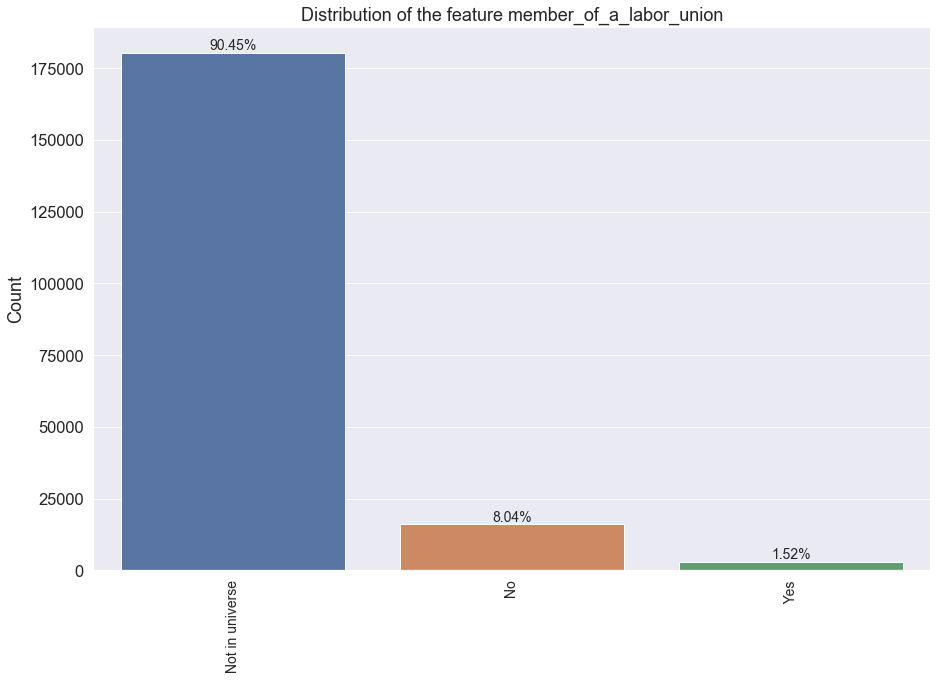

In [42]:
printmd('#### 1.3.12 Member of labour union')
printmd('##### Comments: \n \
Only 1.5% of the population is a member of a labour union, 8% is not and 90% \
is not in the universe (NAs or children presumably). Being part of a union \
seems to be associated with a marginally higher proportion of large incomes \
(14% vs 11%) - though would need a significance test for additional confidence.')
chart_driver(data_learn, 'member_of_a_labor_union')

#### 1.3.13 Reason for unemployment

##### Comments: 
 Close to 97% of the sample is not consideredd unemployed (includes children) and employed).

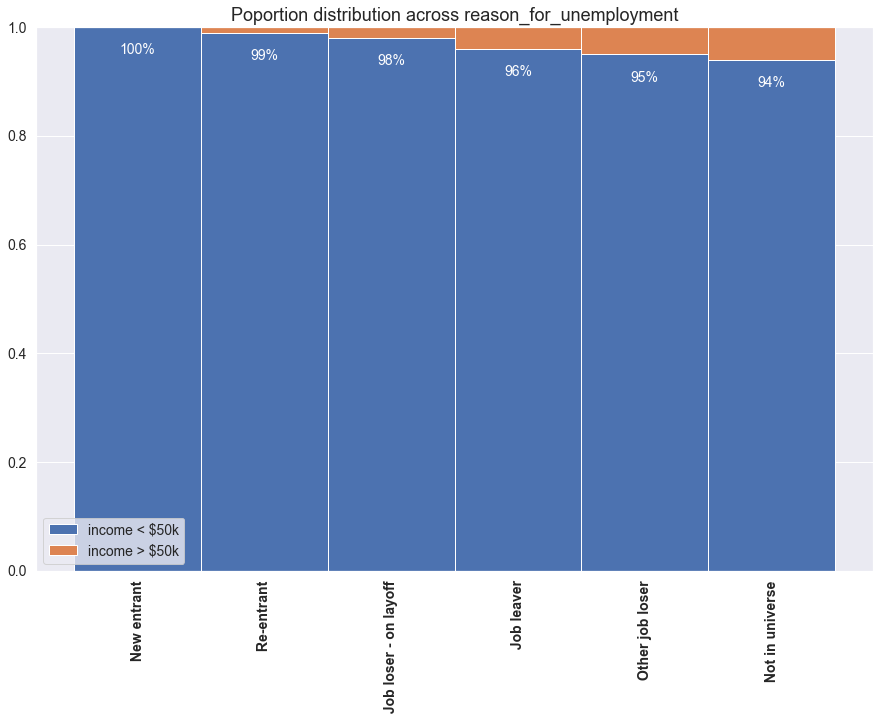

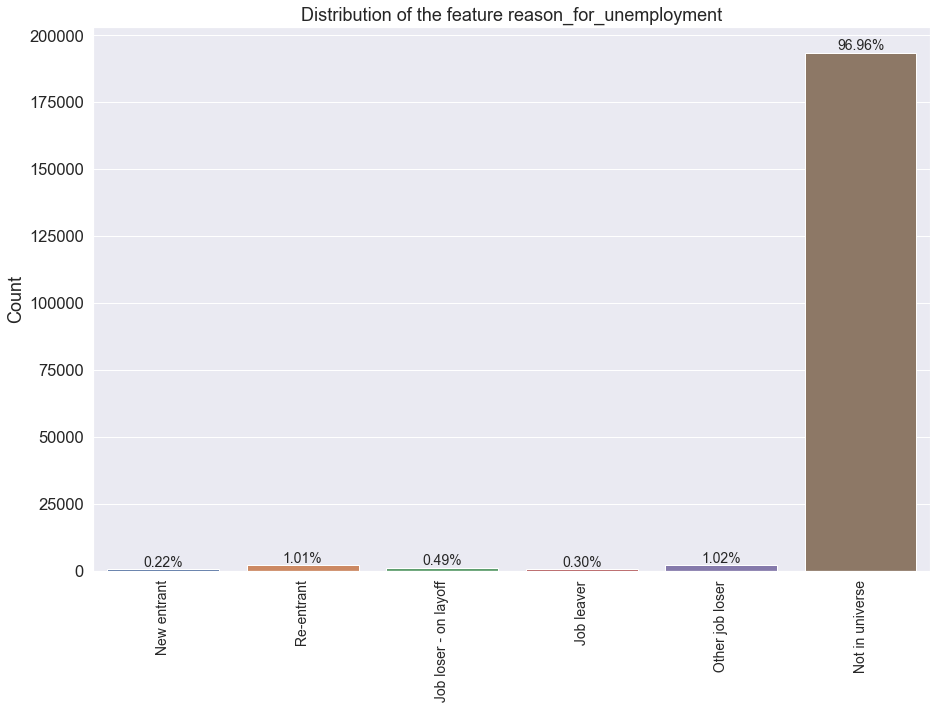

In [43]:
printmd('#### 1.3.13 Reason for unemployment')
printmd('##### Comments: \n \
Close to 97% of the sample is not consideredd unemployed (includes children) \
and employed).')
chart_driver(data_learn, 'reason_for_unemployment')

#### 1.3.14 Full time employment

##### Comments: 
 The attributes "PT for non-econ reasons usually FT", "Full-time schedules" and "PT for econ reasons usually PT" have around 13% of high income earners, while less than 6% for the other forms of employment

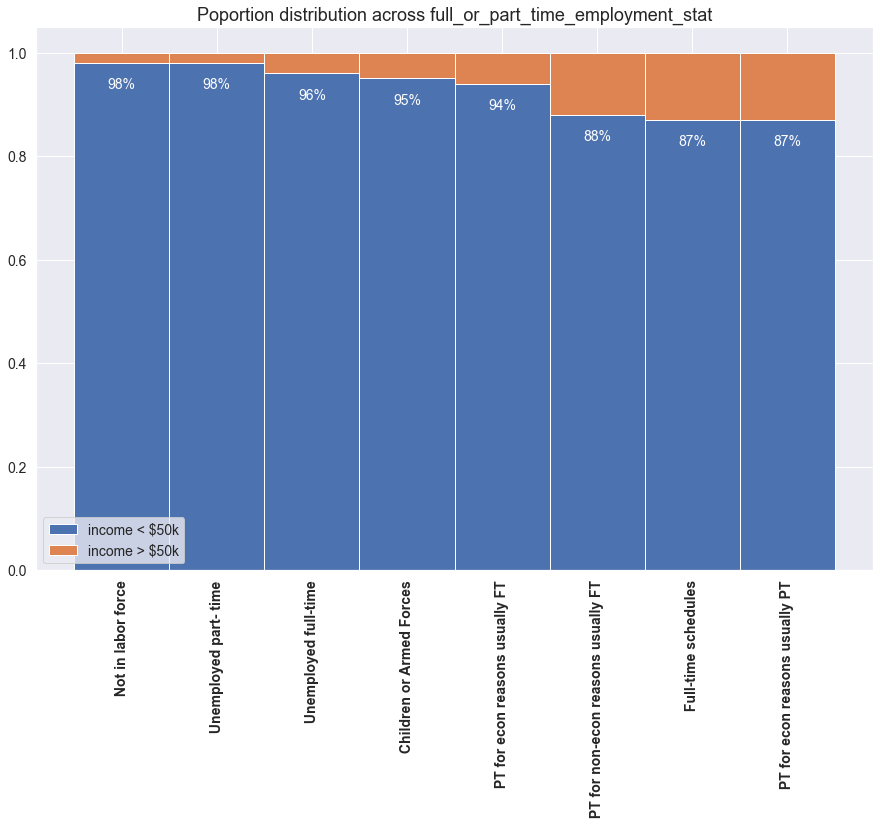

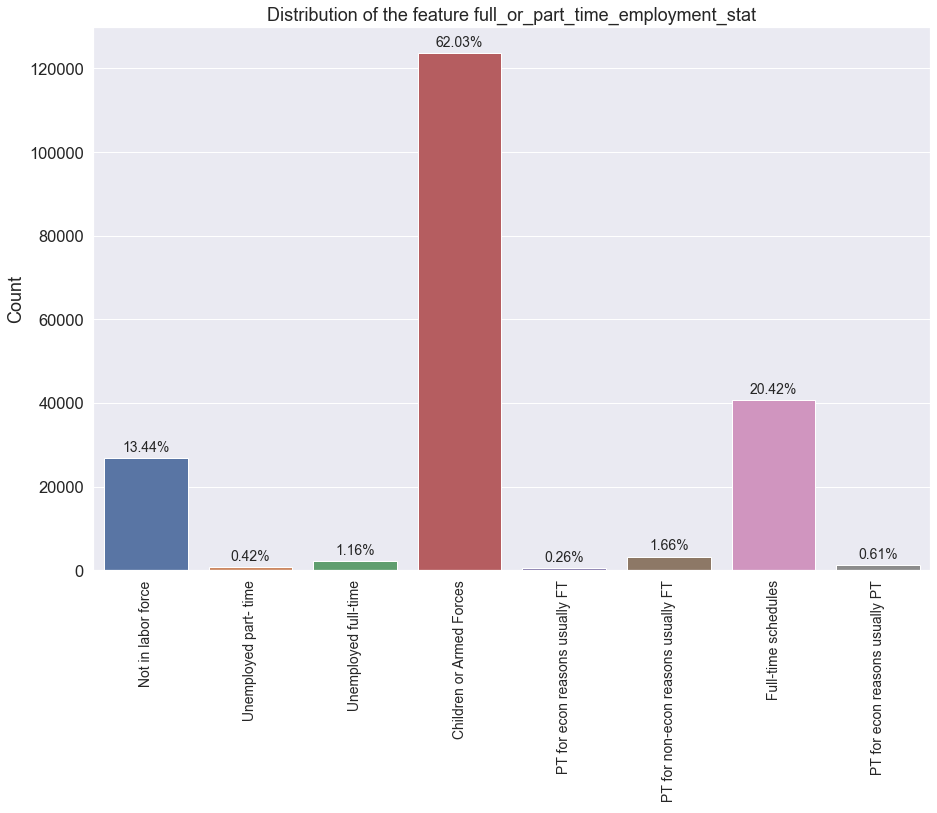

In [44]:
printmd('#### 1.3.14 Full time employment')
printmd('##### Comments: \n \
The attributes "PT for non-econ reasons usually FT", \
"Full-time schedules" and "PT for econ reasons usually PT" \
have around 13% of high income earners, while less than 6% for the other \
forms of employment')
chart_driver(data_learn, 'full_or_part_time_employment_stat')

#### 1.3.15 tax filer stat

##### Comments: 
 The "non-filer" category affects 37.64% of the population, while non of them are in the high income category.

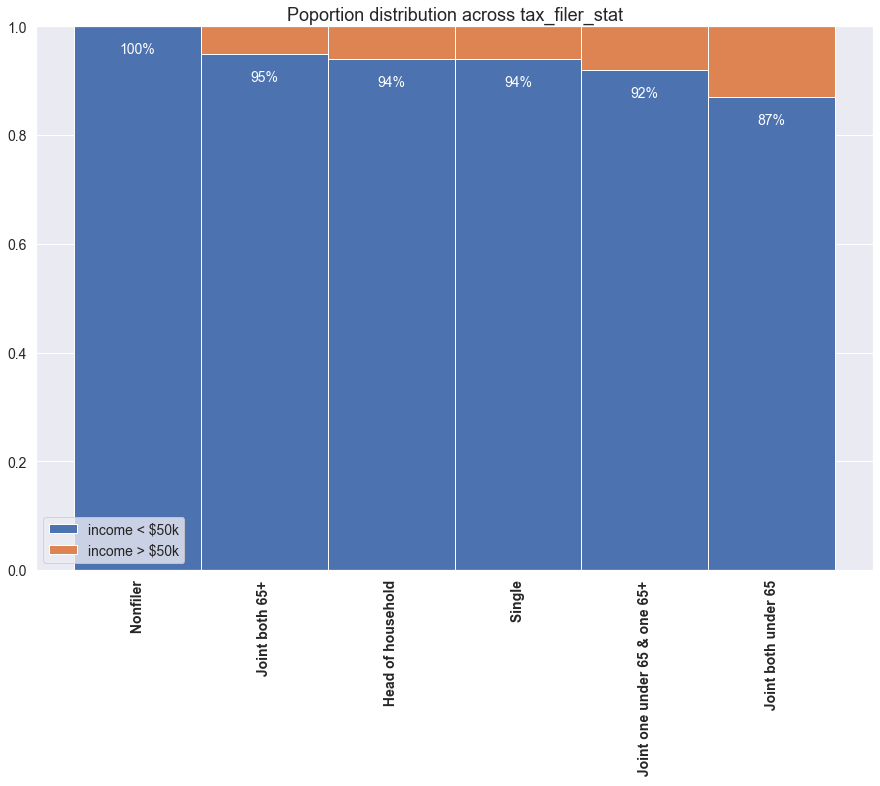

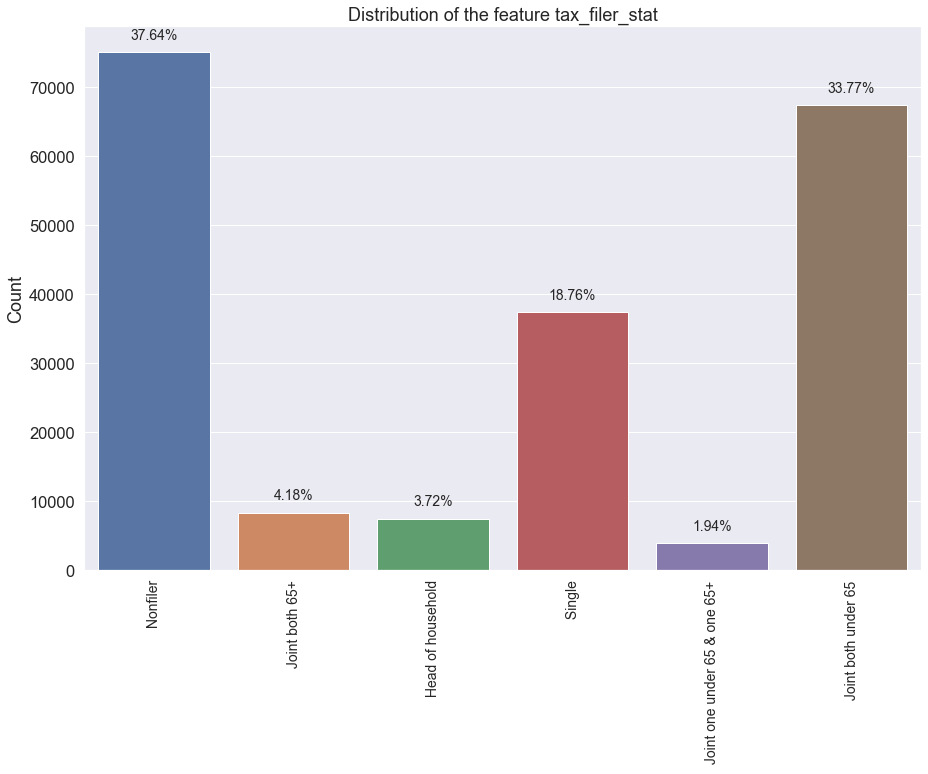

In [45]:
printmd('#### 1.3.15 tax filer stat')
printmd('##### Comments: \n \
The "non-filer" category affects 37.64% of the population, while non of them \
are in the high income category.')
chart_driver(data_learn, 'tax_filer_stat')

#### 1.3.16 Region of previous residence

##### Comments: 
 There is very little variation in the share of high income earnersbetween categories of this feature. 92% of the sample is also "not in universe". May consider dropping

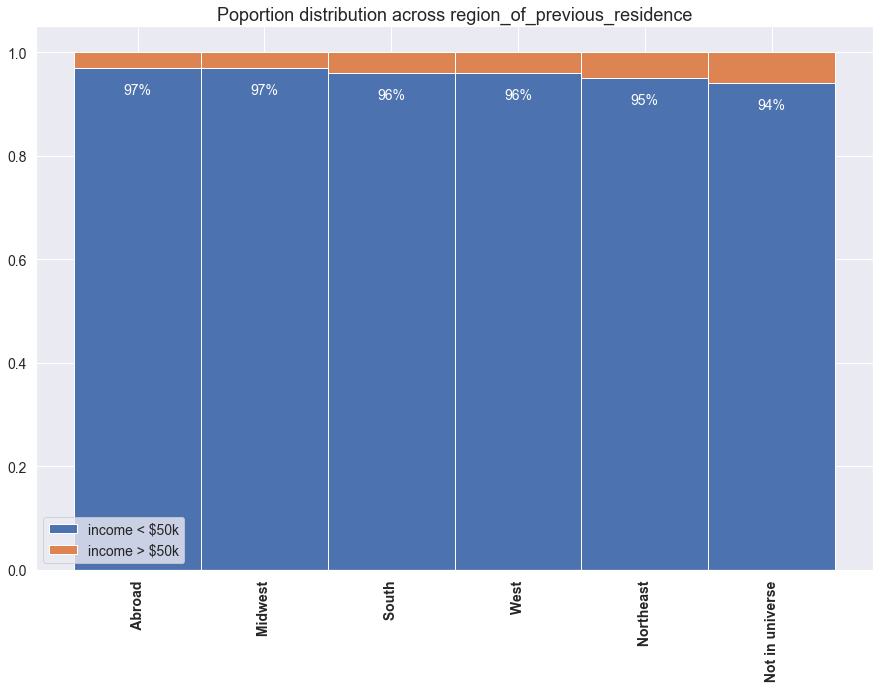

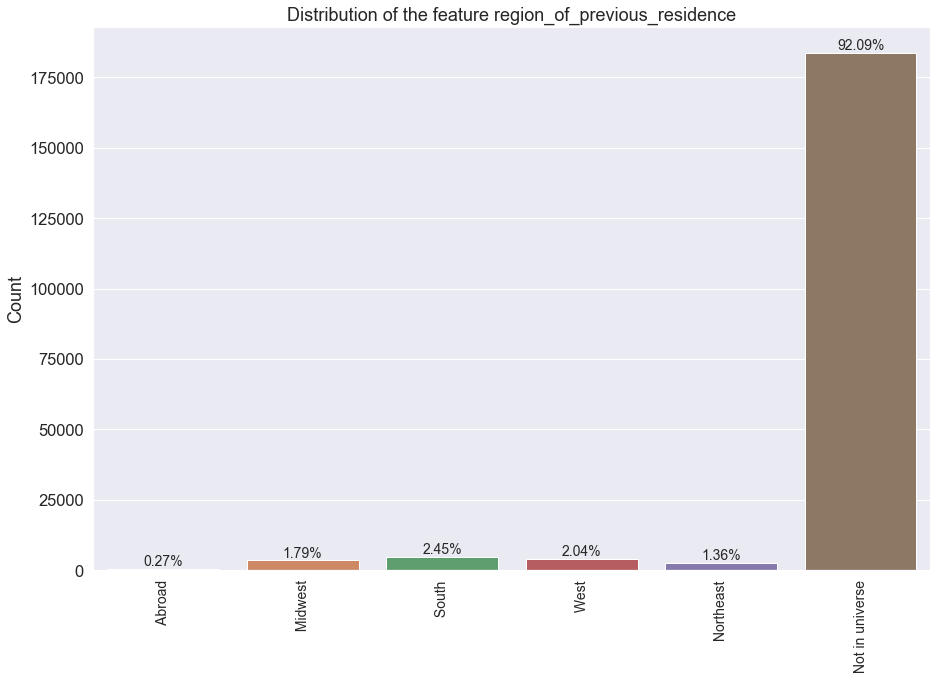

In [46]:
printmd('#### 1.3.16 Region of previous residence')
printmd('##### Comments: \n \
There is very little variation in the share of high income earners\
between categories of this feature. 92% of the sample is also \
"not in universe". May consider dropping')
chart_driver(data_learn, 'region_of_previous_residence')

#### 1.3.17 State of previous residence

##### Comments: 
 Similarly to the region of previous residence, the state brings little information. May also drop.

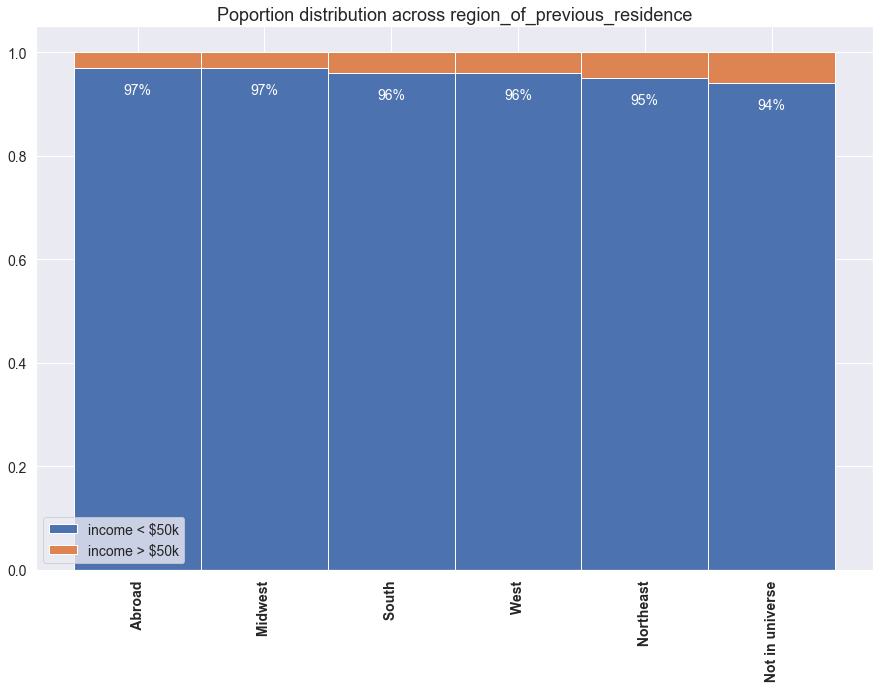

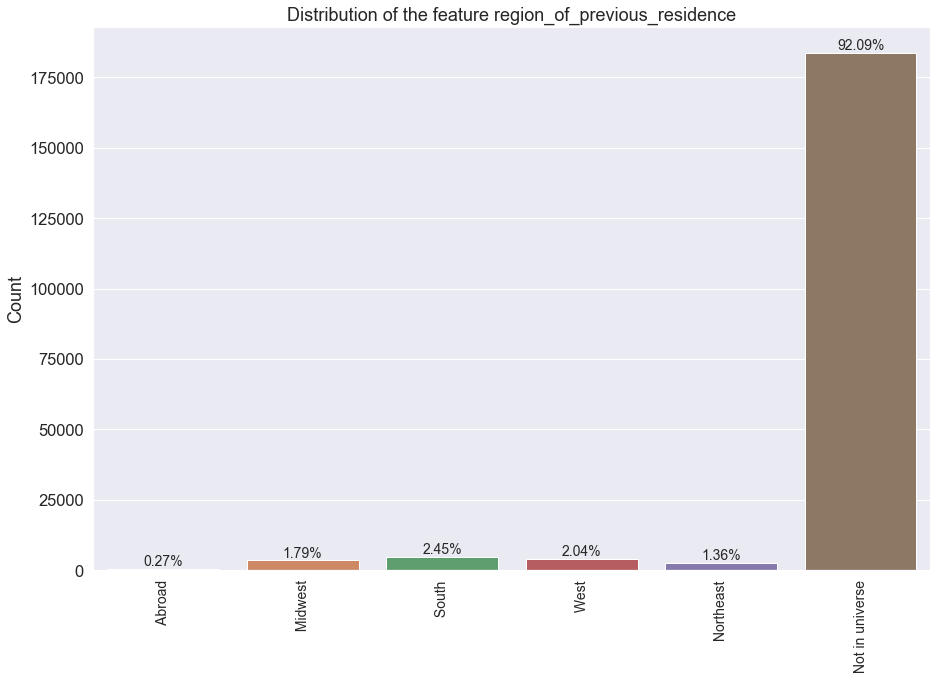

In [47]:
printmd('#### 1.3.17 State of previous residence')
printmd('##### Comments: \n \
Similarly to the region of previous residence, the state brings \
little information. May also drop.')
chart_driver(data_learn, 'region_of_previous_residence')

#### 1.3.18 detailed_household_and_family_stat

##### Comments: 
 We get confirmation here that 25% of the sample is made of children.Of the "householder" category, 15% are high income earners.

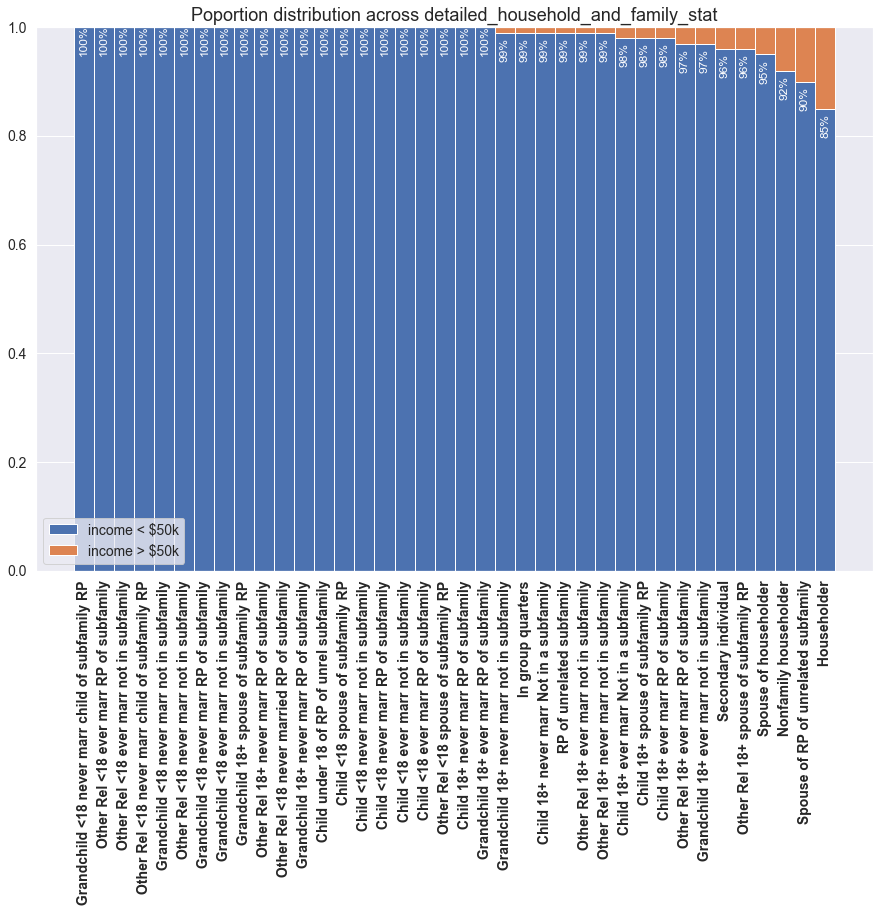

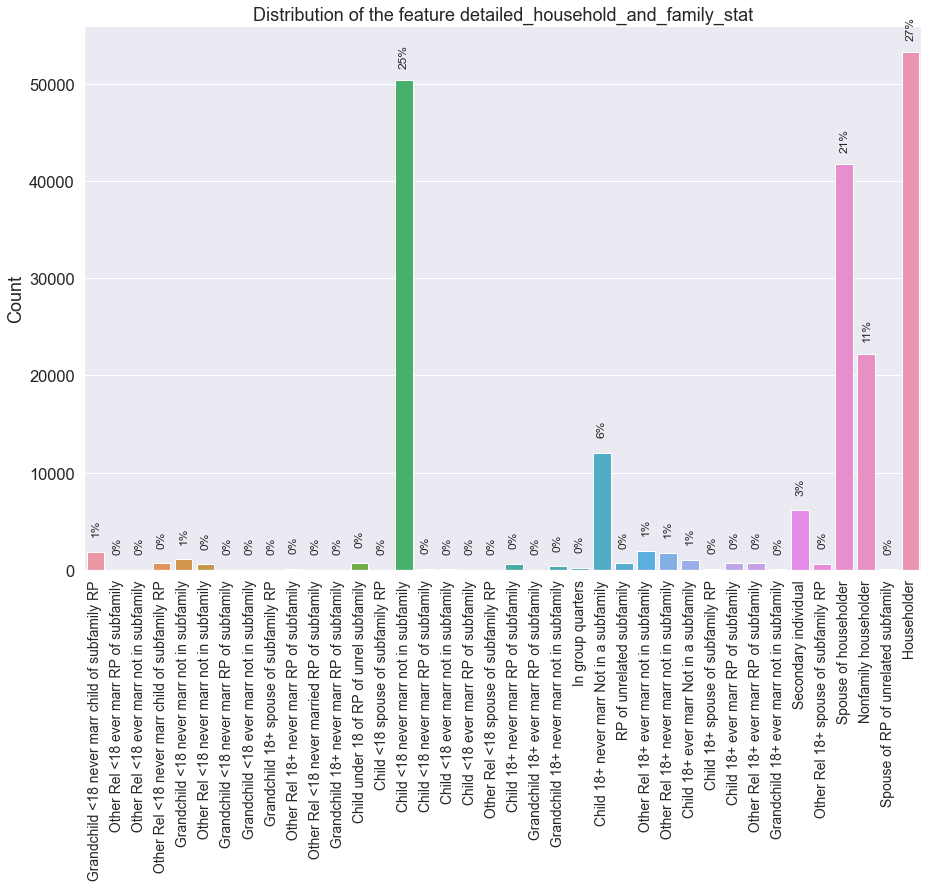

In [48]:
printmd('#### 1.3.18 detailed_household_and_family_stat')
printmd('##### Comments: \n \
We get confirmation here that 25% of the sample is made of children.\
Of the "householder" category, 15% are high income earners.')
chart_driver(data_learn, 'detailed_household_and_family_stat')

#### 1.3.19 detailed_household_summary_in_household

##### Comments: 
 As with the feature "detailed_household_and_family_stat", here the category "householder" is associated with the largest share of high income earners (13%). The presvious feature may as weel be dropped as seems to carry the same information as the one below.

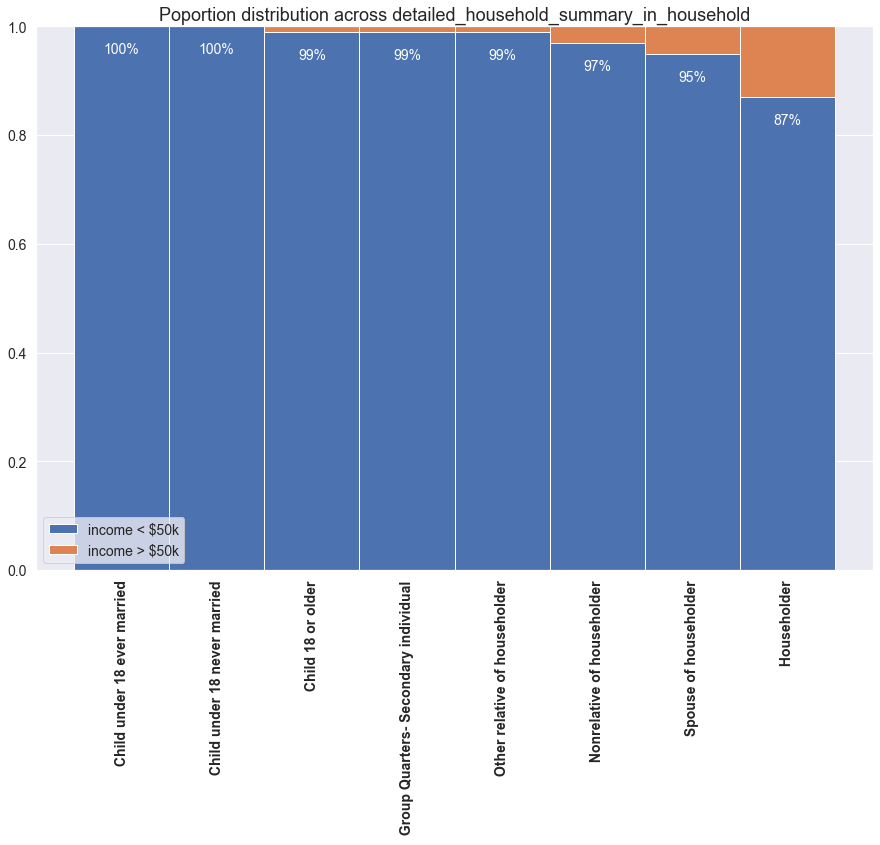

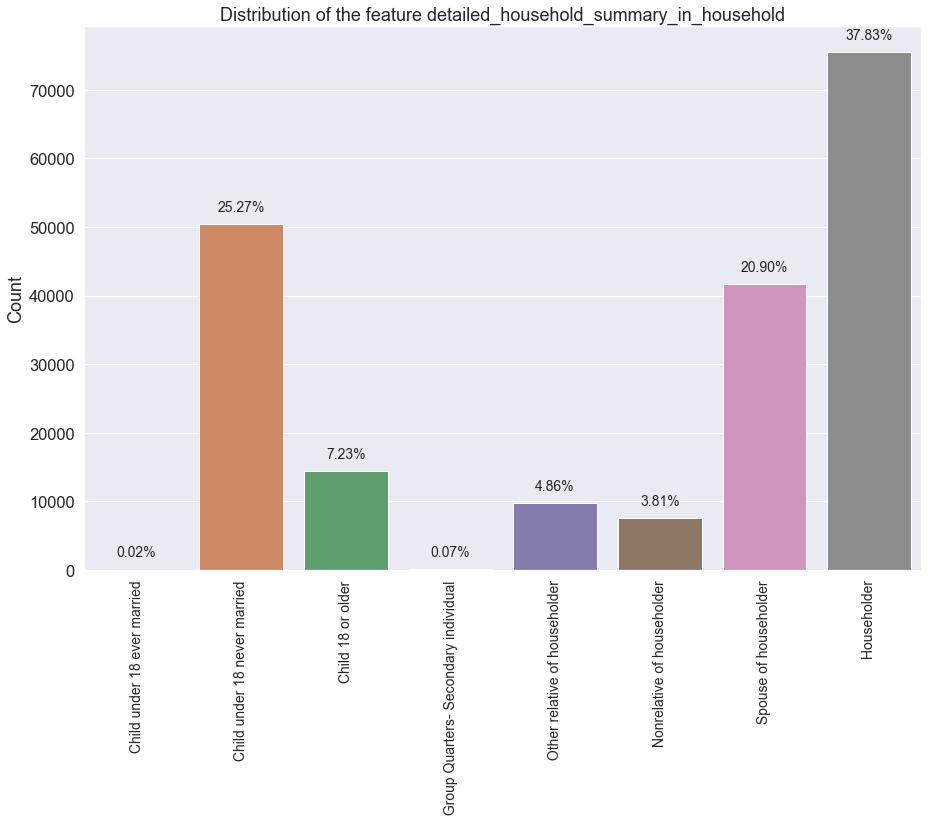

In [49]:
printmd('#### 1.3.19 detailed_household_summary_in_household')
printmd('##### Comments: \n \
As with the feature "detailed_household_and_family_stat", here the category \
"householder" is associated with the largest share of high income earners (13%). \
The presvious feature may as weel be dropped as seems to carry the same information as the one below.')
chart_driver(data_learn, 'detailed_household_summary_in_household')

#### 1.3.20 migration_code-change_in_msa 

##### Comments: 
 About 50% of the sample did not understand the question properly.

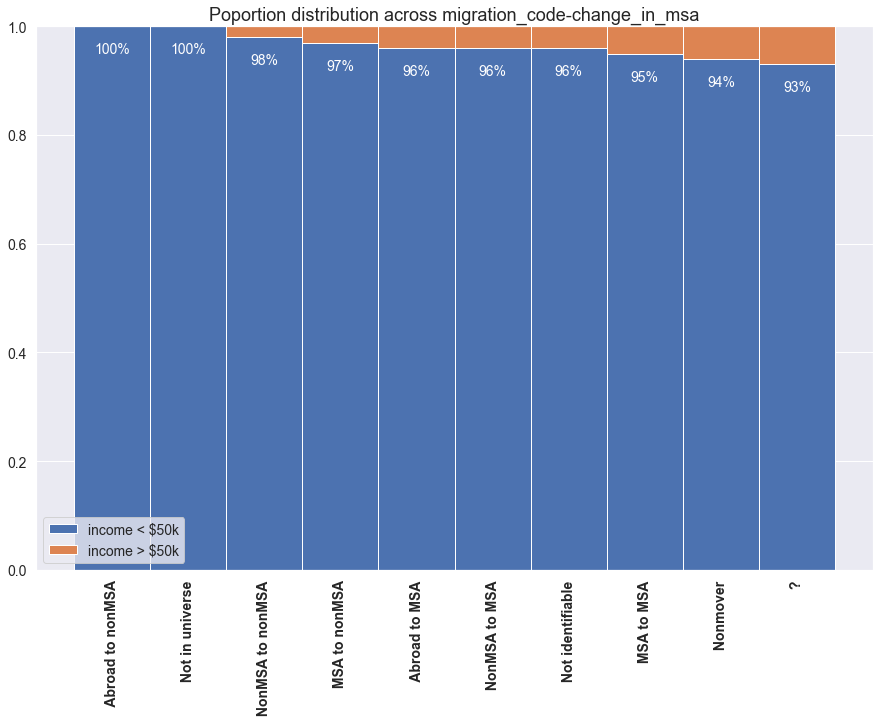

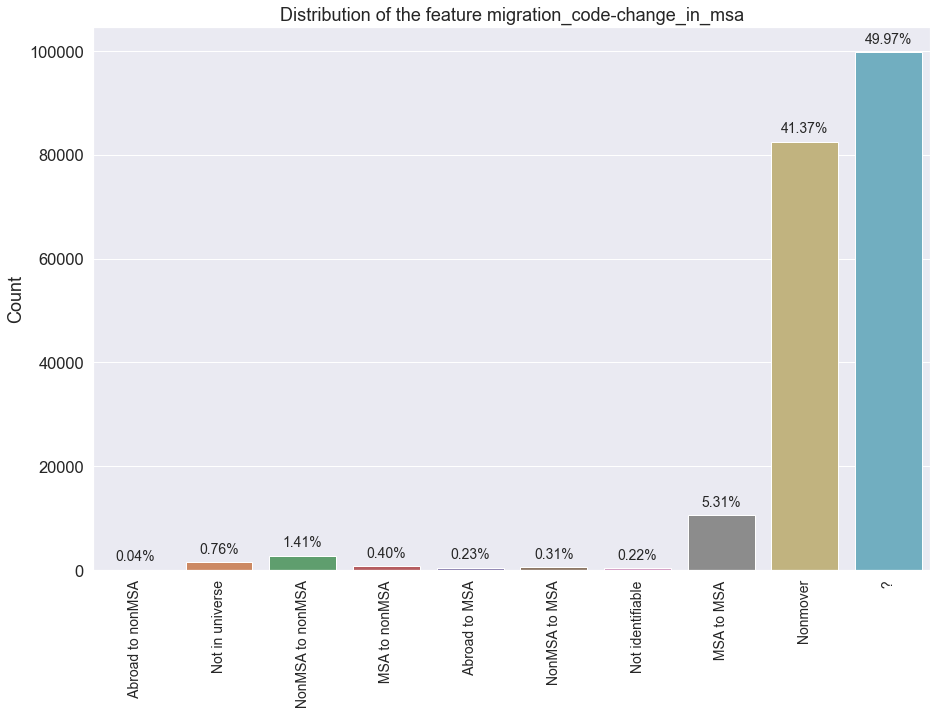

In [50]:
printmd('#### 1.3.20 migration_code-change_in_msa ')
printmd('##### Comments: \n \
About 50% of the sample did not understand the question properly.')
chart_driver(data_learn, 'migration_code-change_in_msa')

#### 1.3.21 migration_code-change_in_reg

##### Comments: 
 Carries very similar information to the MSA feature analysed before

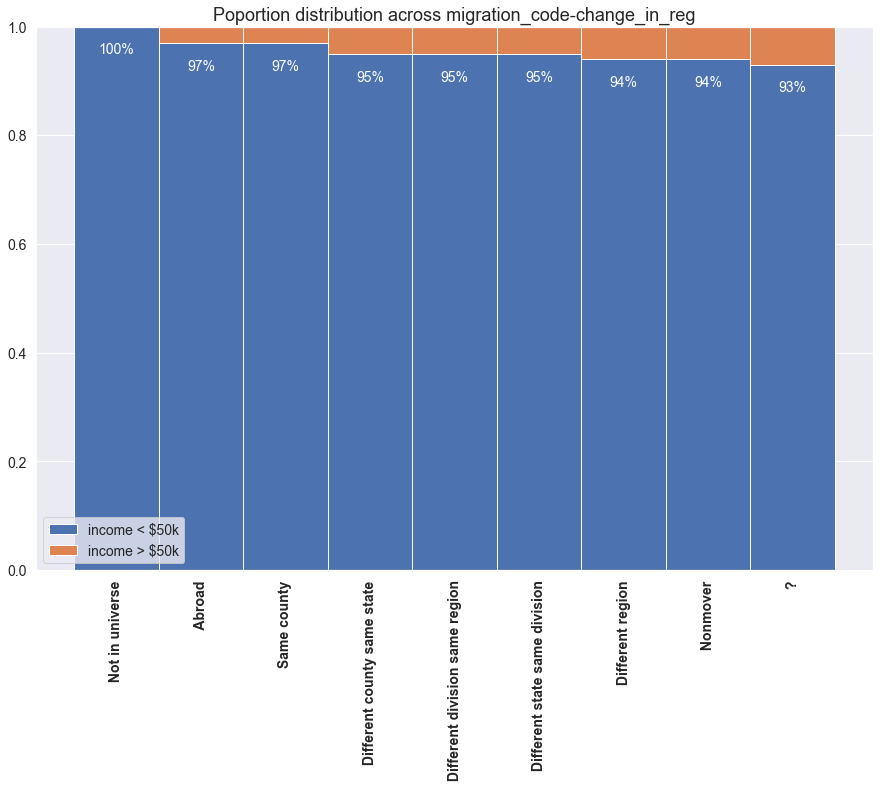

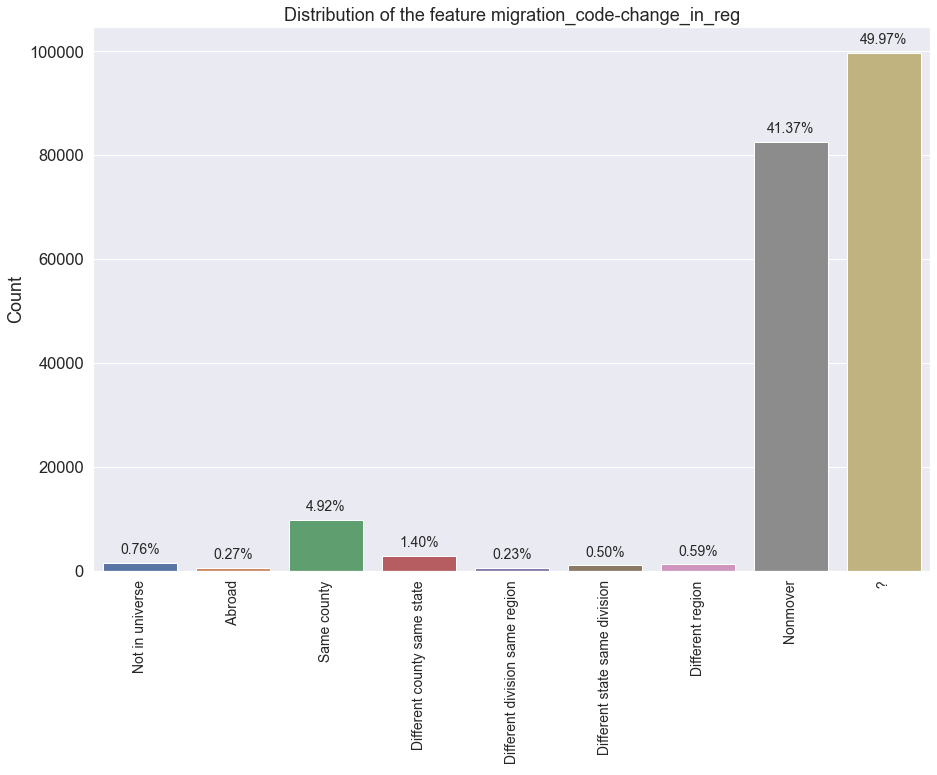

In [51]:
printmd('#### 1.3.21 migration_code-change_in_reg')
printmd('##### Comments: \n \
Carries very similar information to the MSA feature analysed before')
chart_driver(data_learn, 'migration_code-change_in_reg')

#### 1.3.22 migration_code-move_within_reg

##### Comments: 
 About 50% of the sample, as for the two previous features, did not understand the question

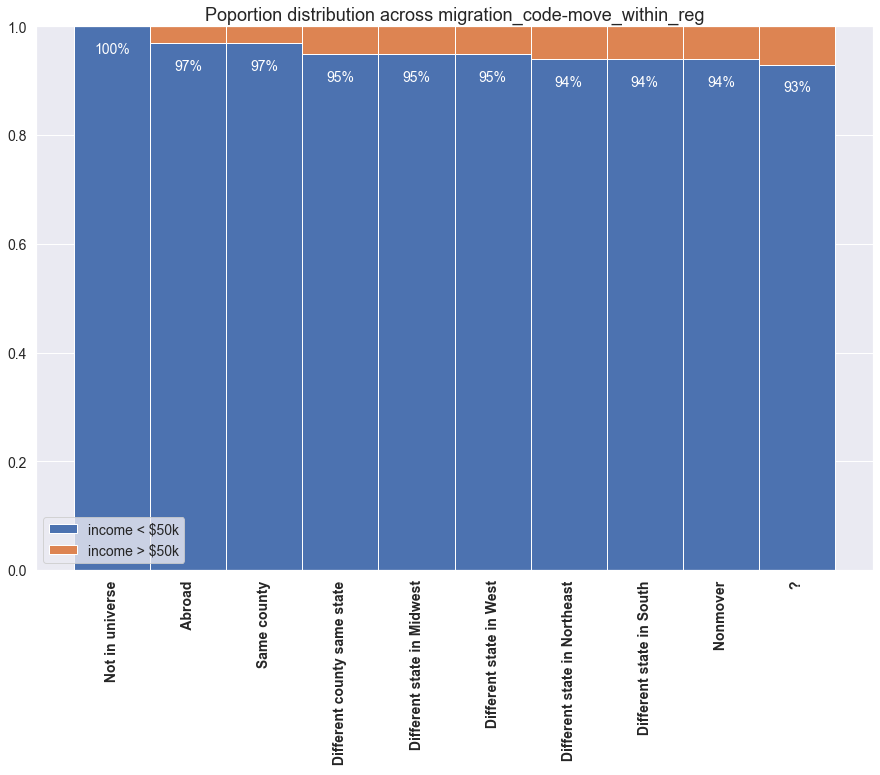

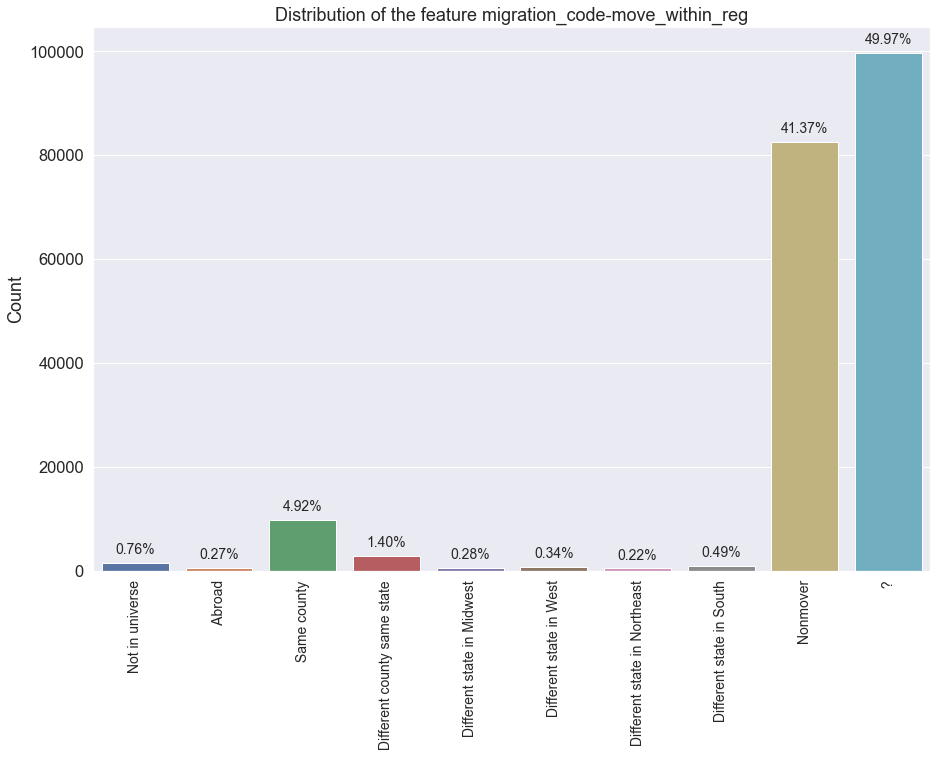

In [52]:
printmd('#### 1.3.22 migration_code-move_within_reg')
printmd('##### Comments: \n \
About 50% of the sample, as for the two previous features, did not \
understand the question')
chart_driver(data_learn, 'migration_code-move_within_reg')

#### 1.3.23 live_in_this_house_1_year_ago

##### Comments: 
 50.72% of the population hae been living in their current house for over a year. 41.36% since more than 1 year. The share of high income earners is very similar for both (4-6%)

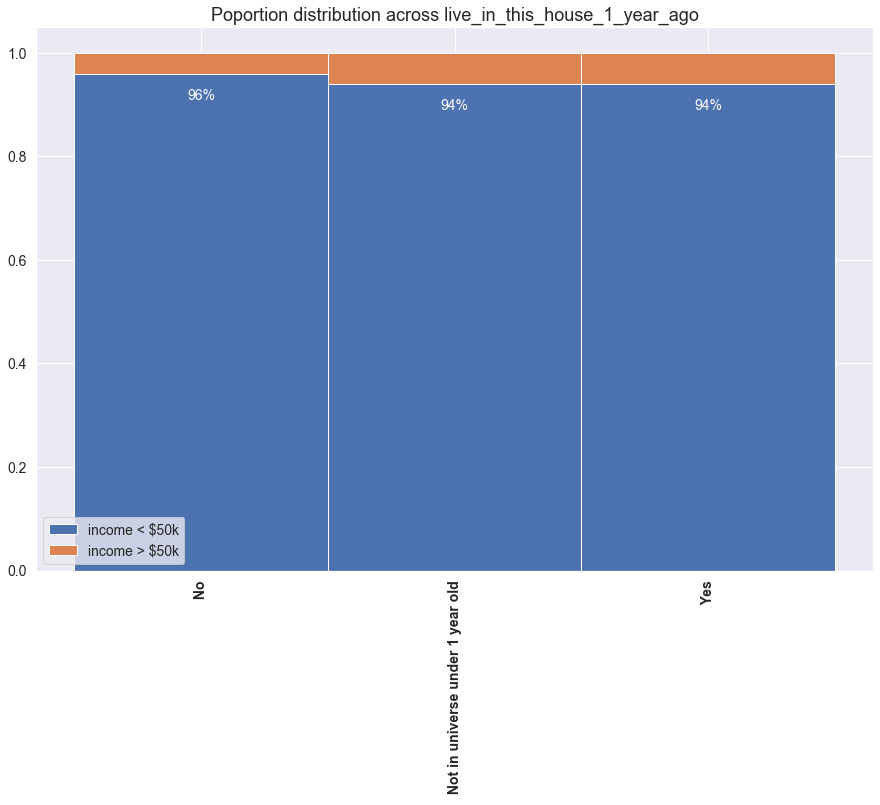

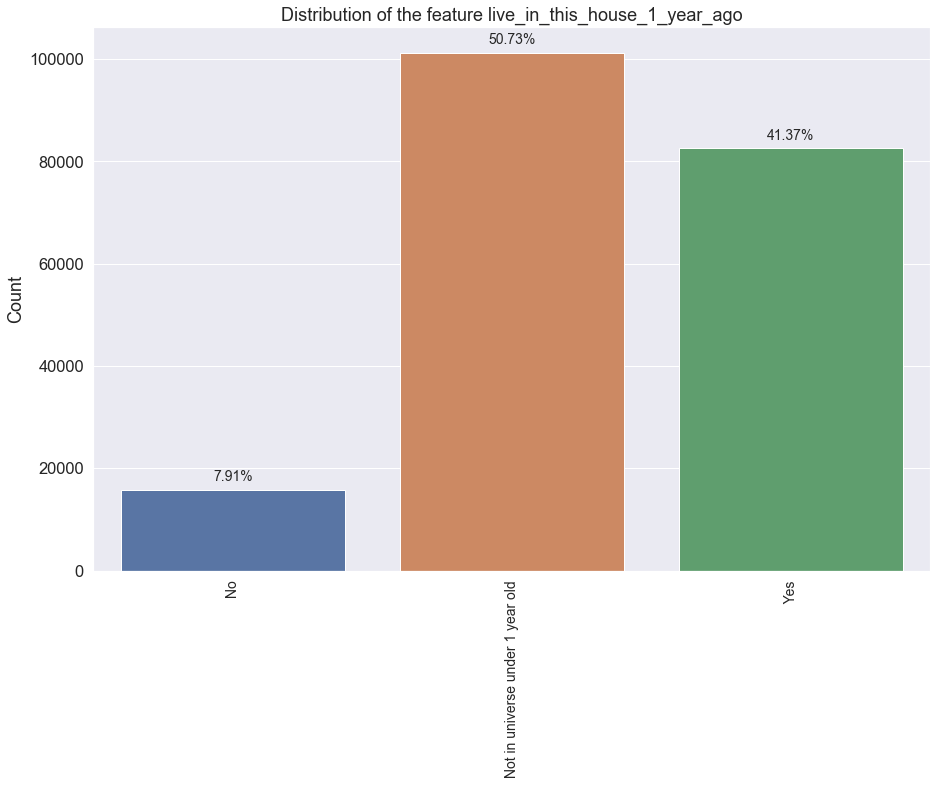

In [53]:
printmd('#### 1.3.23 live_in_this_house_1_year_ago')
printmd('##### Comments: \n \
50.72% of the population hae been living in their current house for over a year. \
41.36% since more than 1 year. The share of high income earners is very \
similar for both (4-6%)')
chart_driver(data_learn, 'live_in_this_house_1_year_ago')

#### 1.3.24 migration_prev_res_in_sunbelt

##### Comments: 
 Only 8% of the sample responded to this question. No large differences in incomes

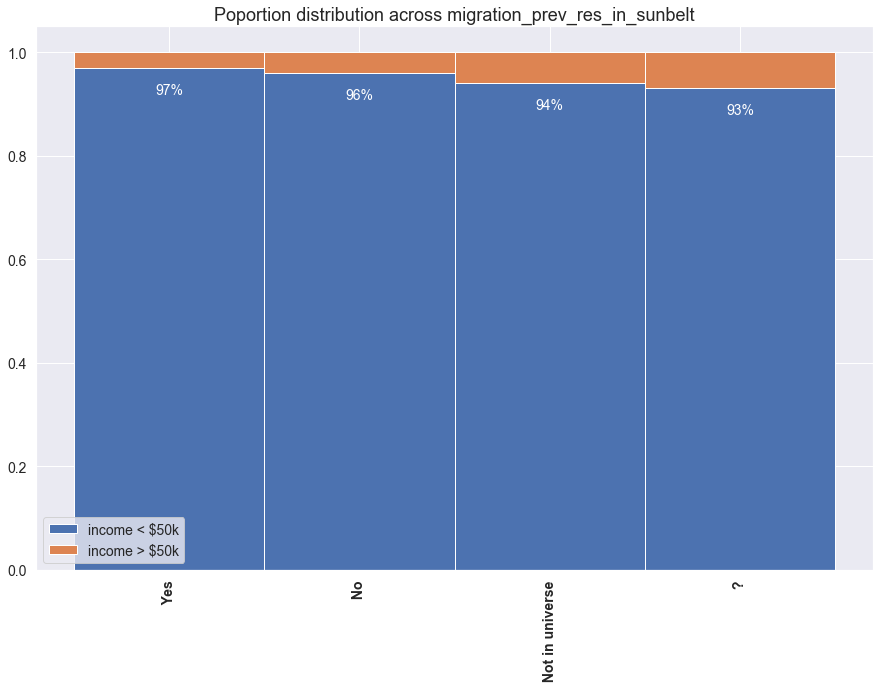

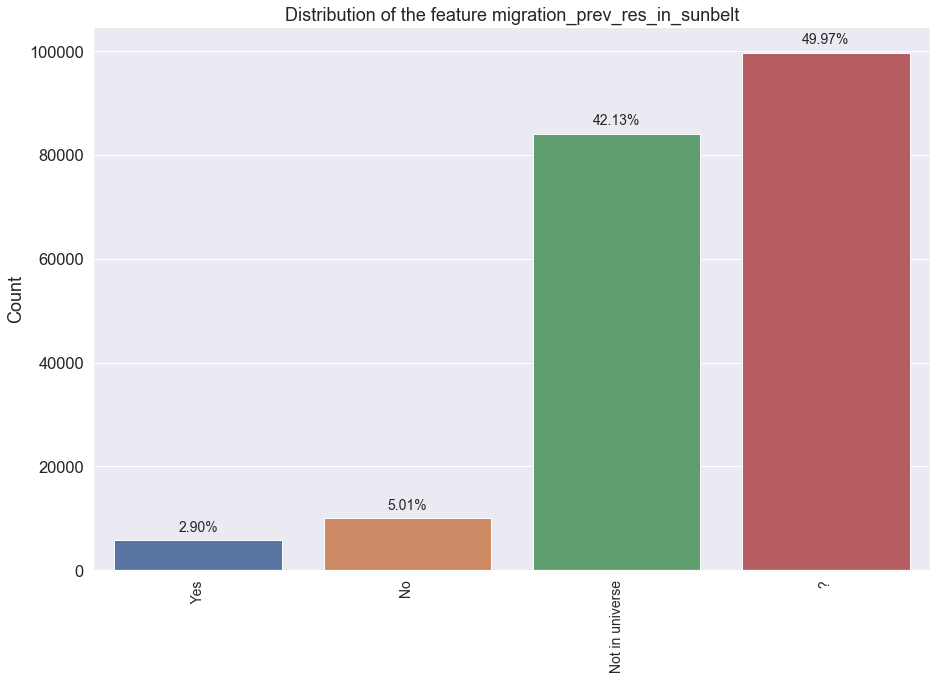

In [54]:
printmd('#### 1.3.24 migration_prev_res_in_sunbelt')
printmd('##### Comments: \n \
Only 8% of the sample responded to this question. No large differences \
in incomes')
chart_driver(data_learn, 'migration_prev_res_in_sunbelt')

#### 1.3.25 family_members_under_18

##### Comments: 
 Only the "not in universe" category has individuals in the high income category

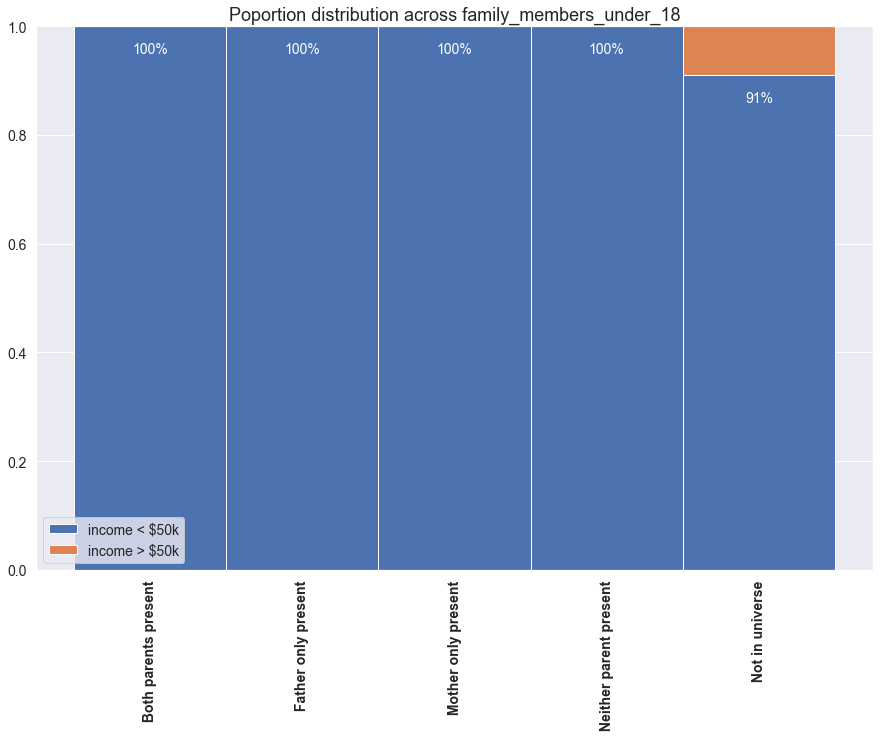

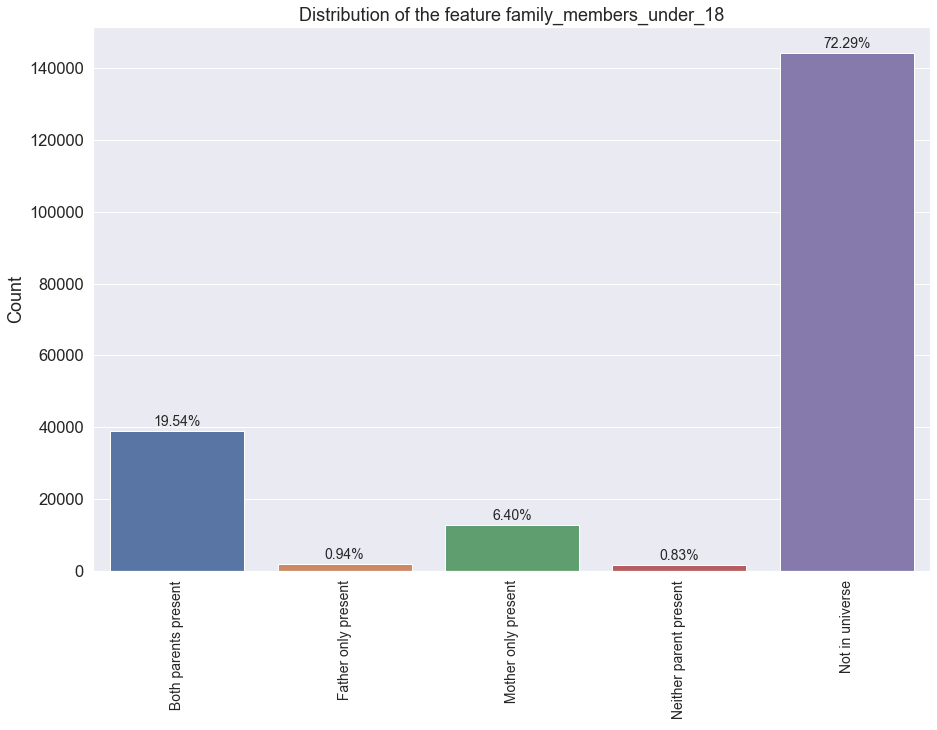

In [55]:
printmd('#### 1.3.25 family_members_under_18')
printmd('##### Comments: \n \
Only the "not in universe" category has individuals in the high income \
category')
chart_driver(data_learn, 'family_members_under_18')

#### 1.3.26 country_of_birth_father

##### Comments: 
 For 80% of the population, the father was born in the USA. We also note that except for Mexico (5%), each of the remaining countries of the fathers birth, represents less than 1% of the population. We may as well drop this feature

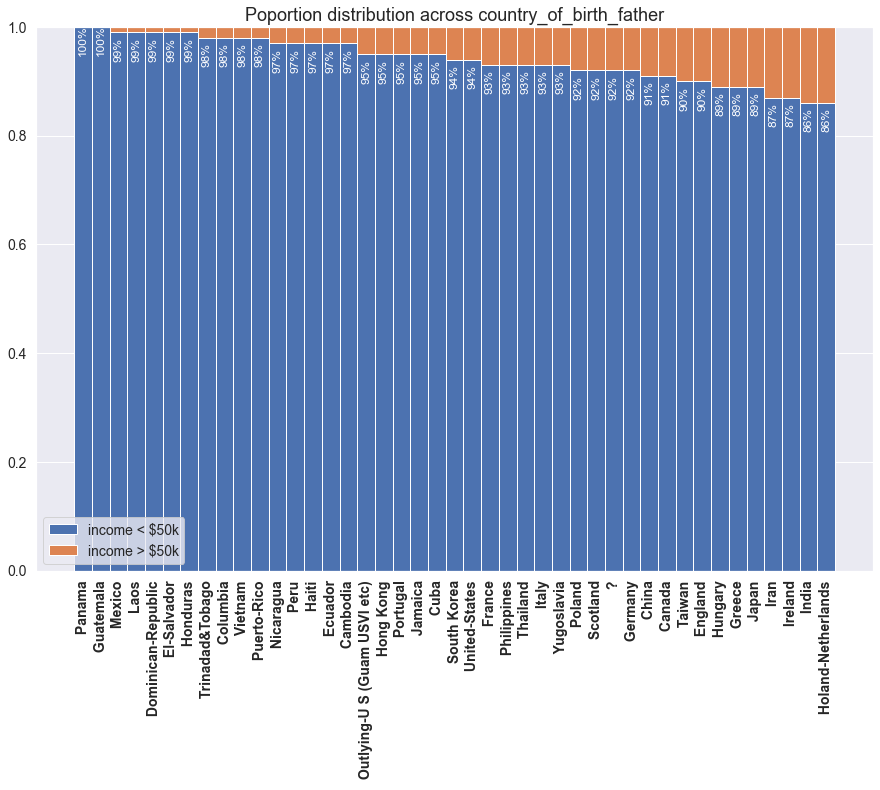

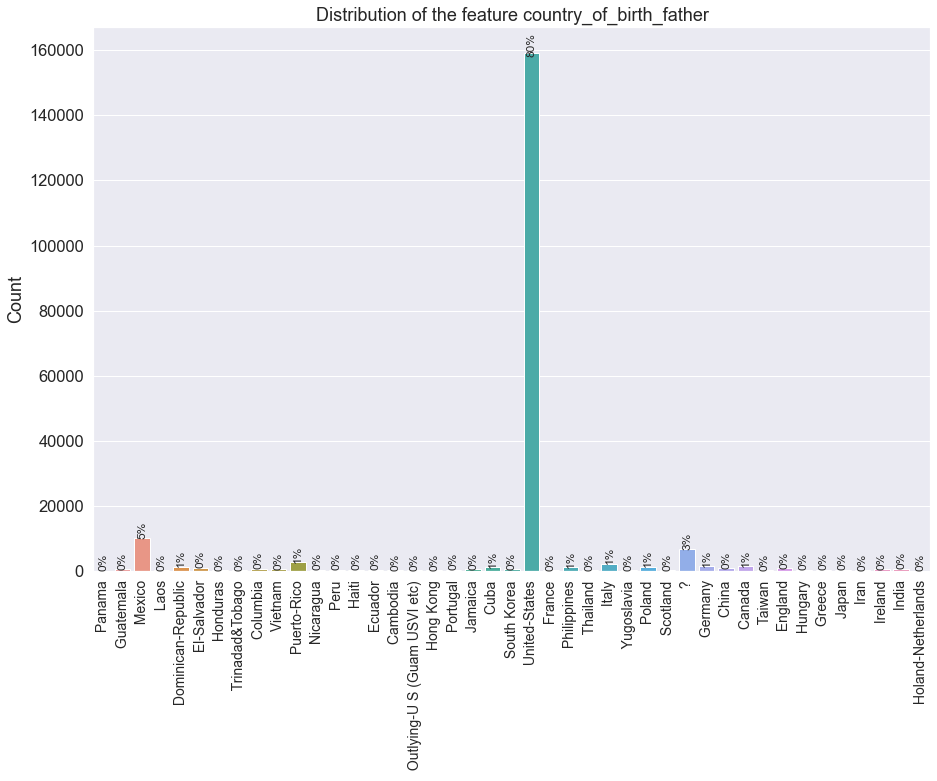

In [56]:
printmd('#### 1.3.26 country_of_birth_father')
printmd('##### Comments: \n \
For 80% of the population, the father was born in the USA. We also note \
that except for Mexico (5%), each of the remaining countries of the fathers birth, \
represents less than 1% of the population. We may as well drop this feature')
chart_driver(data_learn, 'country_of_birth_father')

#### 1.3.27 country_of_birth_mother

##### Comments: 
 The country_of_birth_mother feature follows a very similar distribution to country_of_birth_father

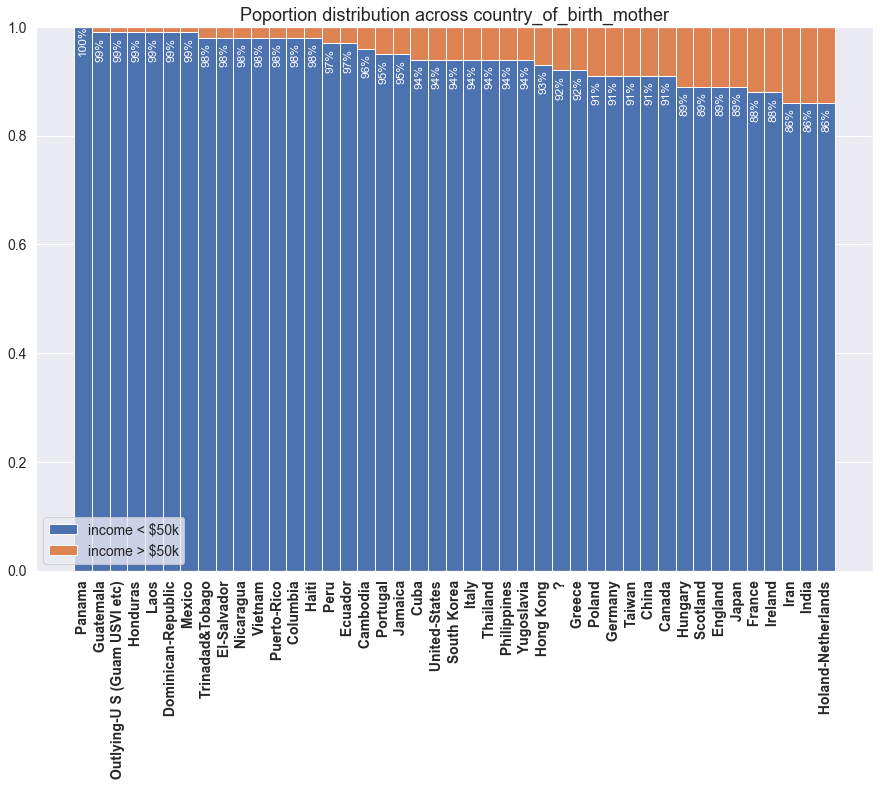

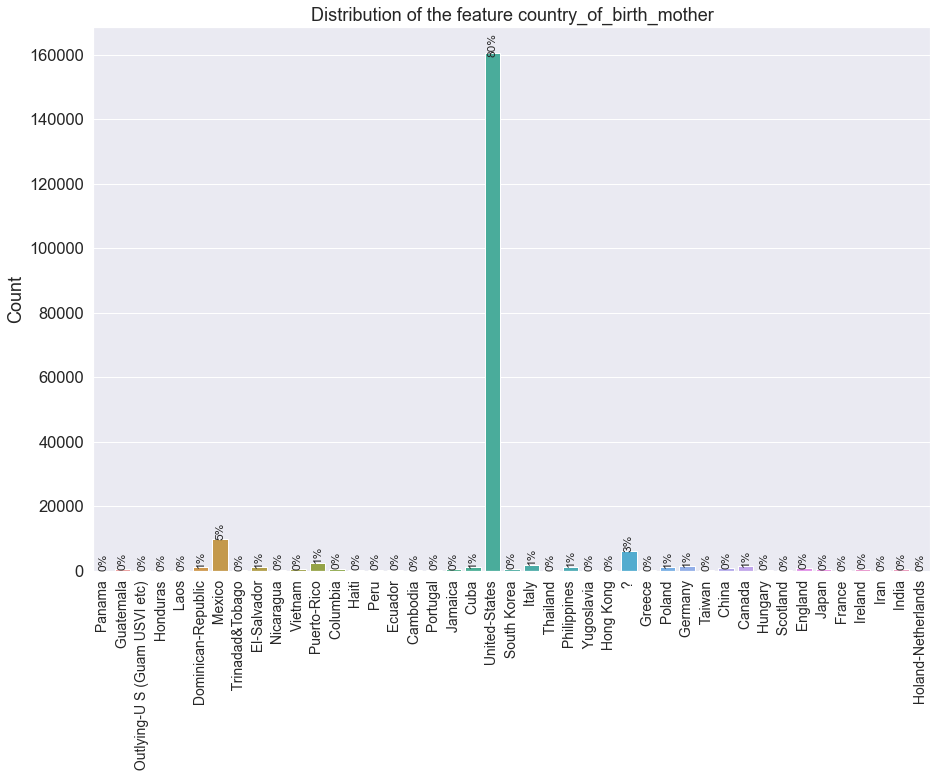

In [57]:
printmd('#### 1.3.27 country_of_birth_mother')
printmd('##### Comments: \n \
The country_of_birth_mother feature follows a very similar distribution to country_of_birth_father')
chart_driver(data_learn, 'country_of_birth_mother')

#### 1.3.28 country_of_birth_self

##### Comments: 
 89% of the surveyd population was born in the USA. Except for Mexico (3%)the rest of countries of origin each account for less than 1% of the sample

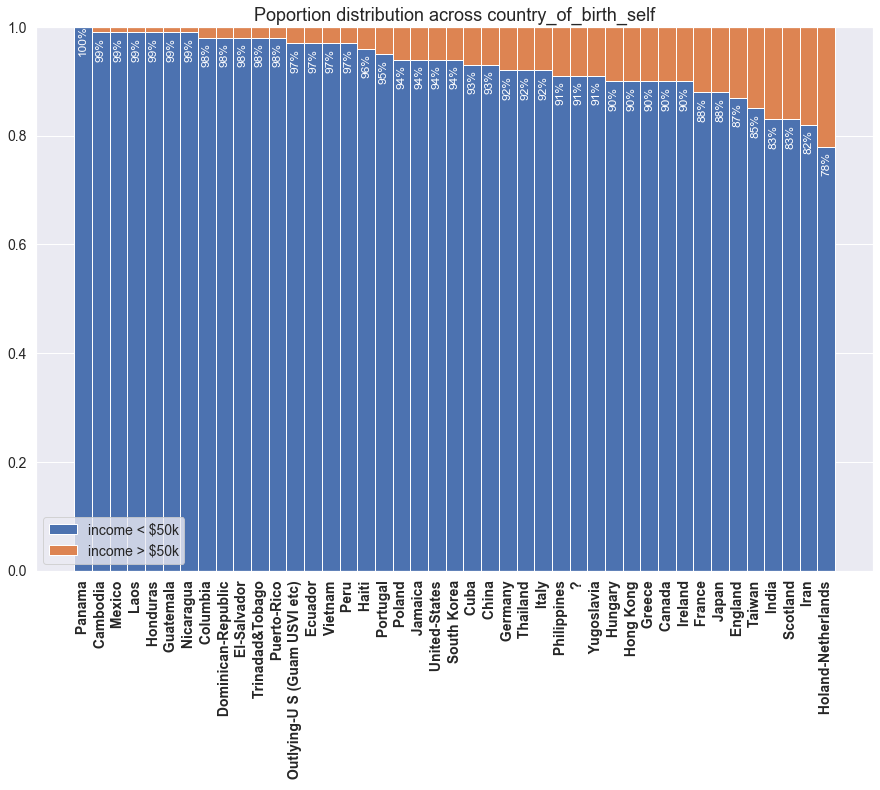

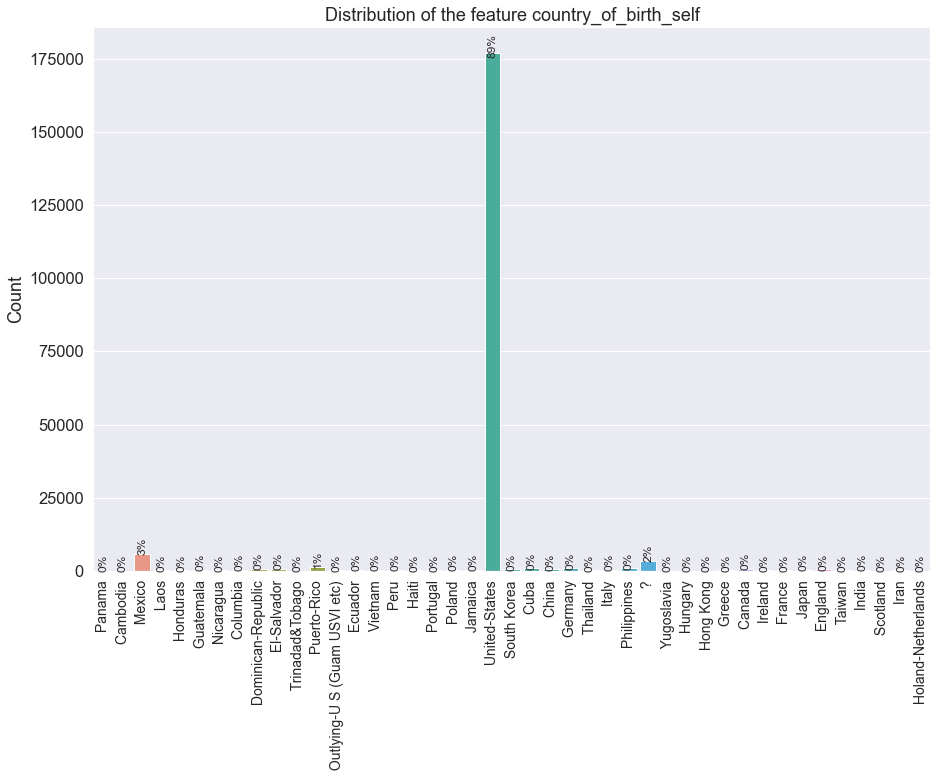

In [58]:
printmd('#### 1.3.28 country_of_birth_self')
printmd('##### Comments: \n \
89% of the surveyd population was born in the USA. Except for Mexico (3%)\
the rest of countries of origin each account for less than 1% of the sample')
chart_driver(data_learn, 'country_of_birth_self')

#### 1.3.29 citizenship

##### Comments: 
 89% of the population is native born in the US. Though the distribution of high income earners is similar across citizenships, foreign-born US citizens by naturalisation have about 10% of high income earners.

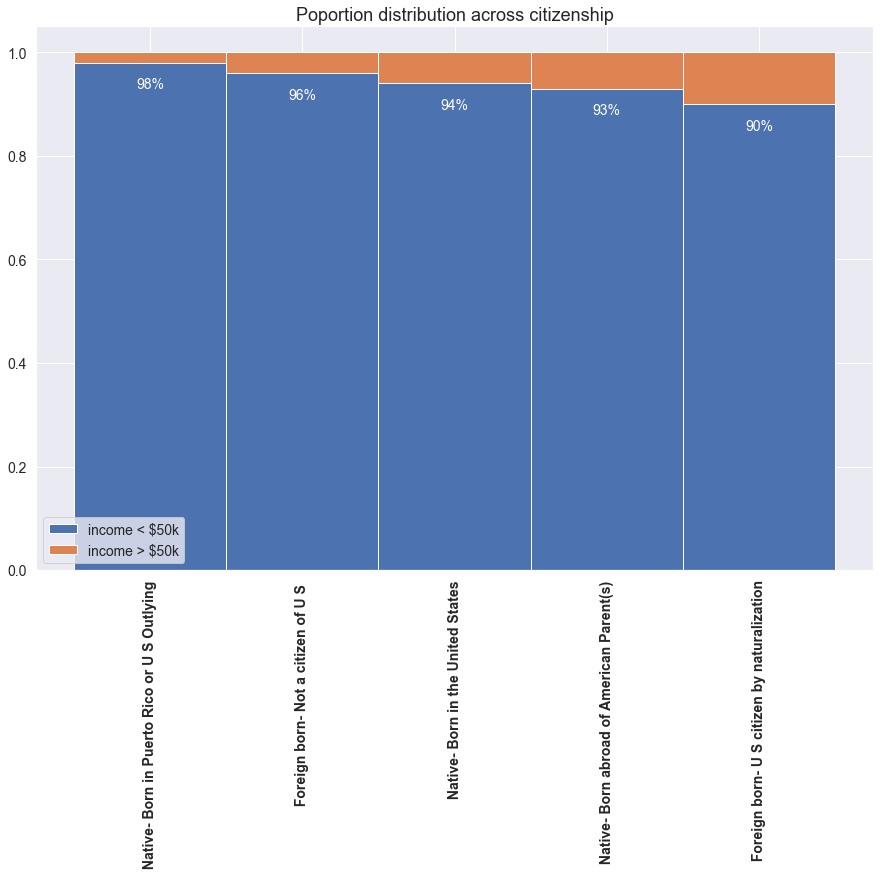

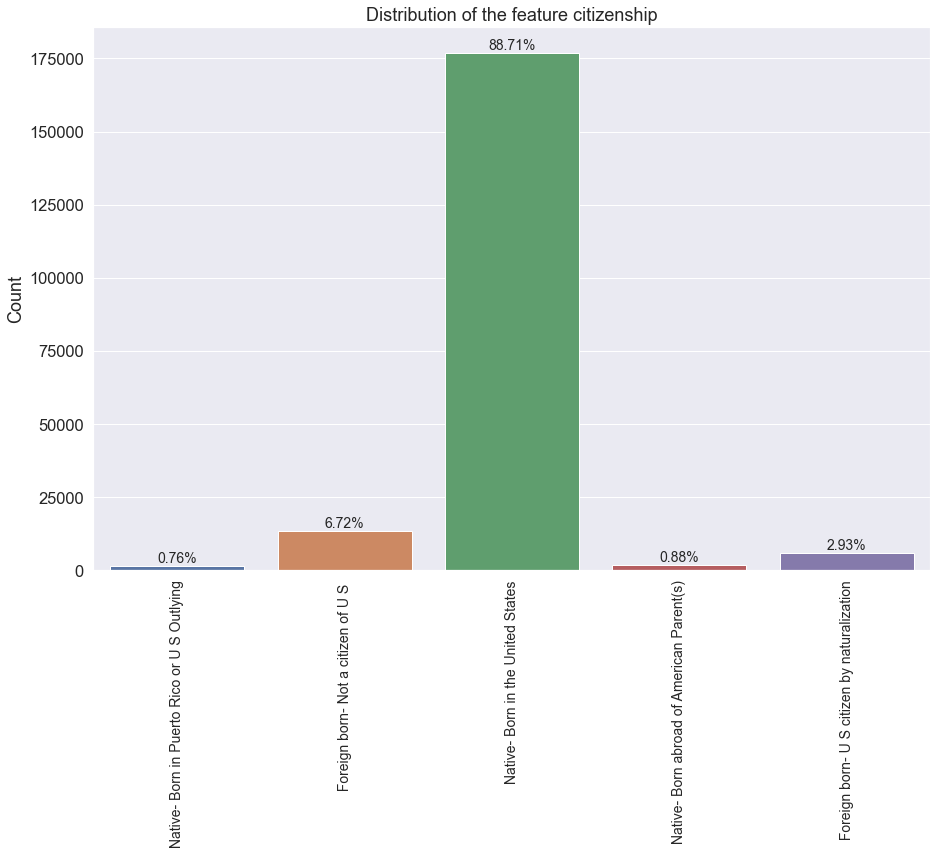

In [59]:
printmd('#### 1.3.29 citizenship')
printmd('##### Comments: \n \
89% of the population is native born in the US. Though the distribution \
of high income earners is similar across citizenships, foreign-born US \
citizens by naturalisation have about 10% of high income earners.')
chart_driver(data_learn, 'citizenship')

#### 1.3.30 own_business_or_self_employed

##### Comments: 
 We cannot tell what 0, 1 and 2 correspond to. The code 2 is only assignedto 1.35% of the population, yet more than 33% of these indivuduals are high income earners

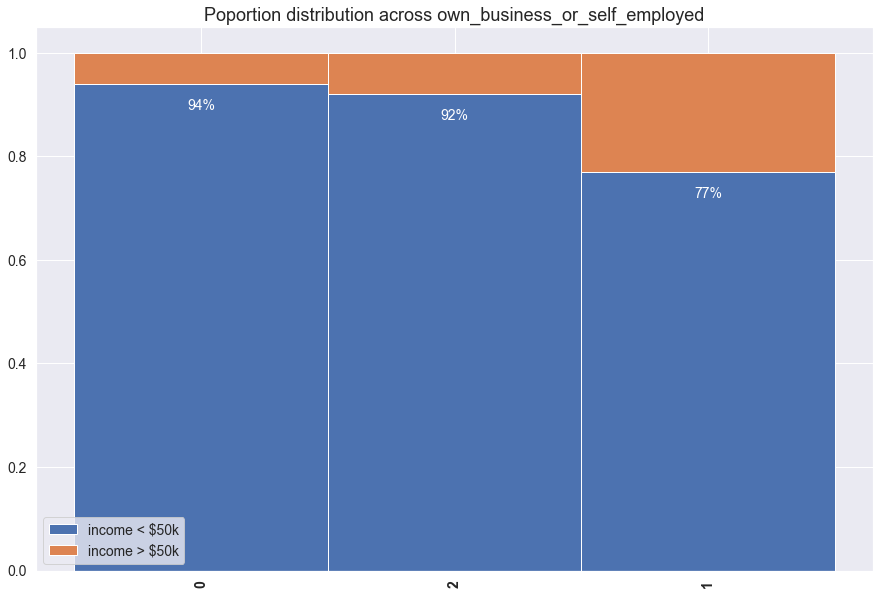

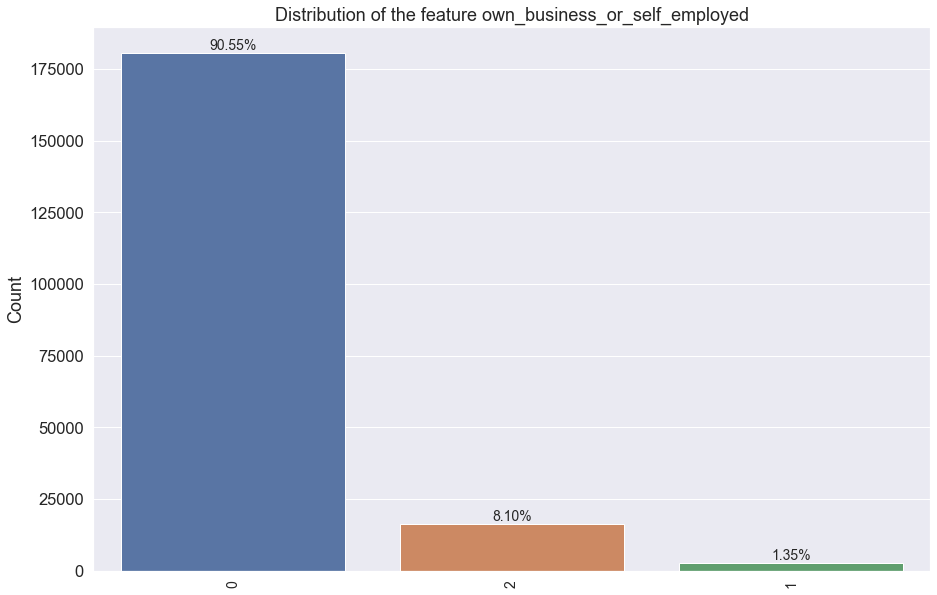

In [60]:
printmd('#### 1.3.30 own_business_or_self_employed')
printmd('##### Comments: \n \
We cannot tell what 0, 1 and 2 correspond to. The code 2 is only assigned\
to 1.35% of the population, yet more than 33% of these indivuduals are high \
income earners')
chart_driver(data_learn, 'own_business_or_self_employed')

#### 1.3.31 fill_inc_questionnaire_for_veteran's_admin

##### Comments: 
 99% of the population are not filling veteran questionnaires

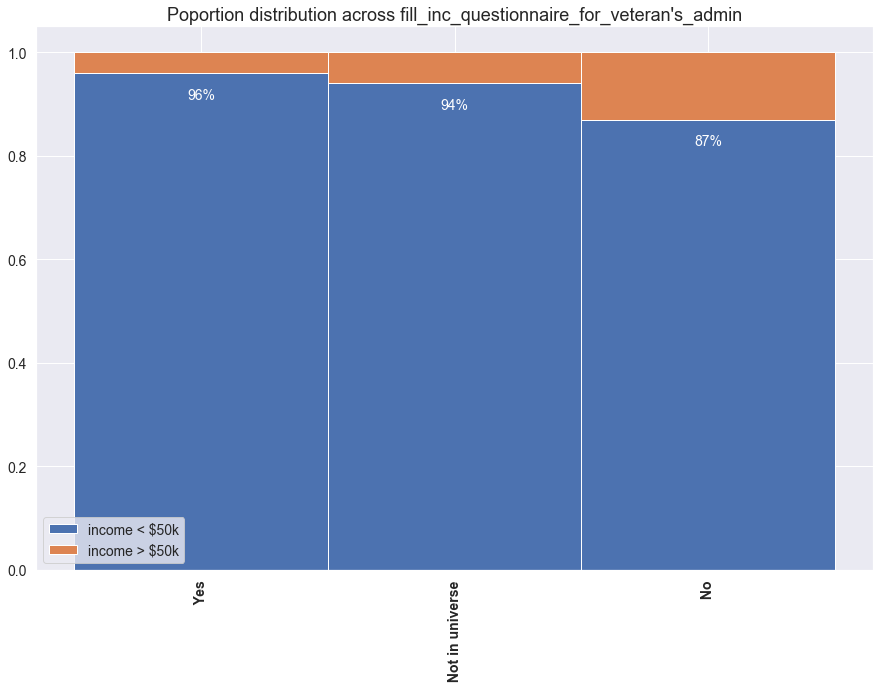

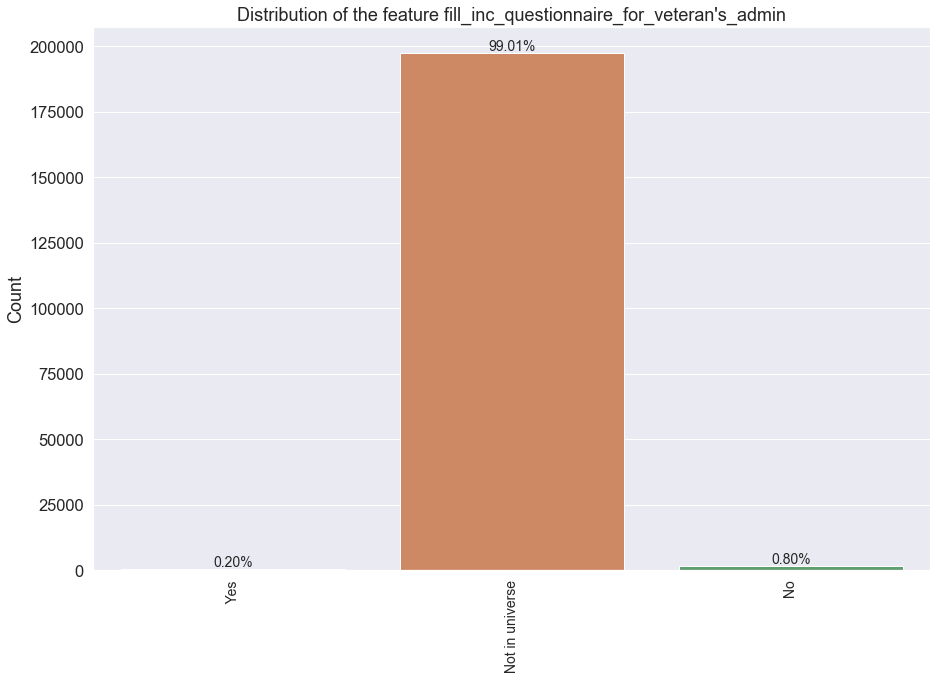

In [61]:
printmd("#### 1.3.31 fill_inc_questionnaire_for_veteran's_admin")
printmd('##### Comments: \n \
99% of the population are not filling veteran questionnaires')
chart_driver(data_learn, "fill_inc_questionnaire_for_veteran's_admin")

#### 1.3.32 veterans_benefits

##### Comments: 
 75.24% of the population fall in category 2, with 8% of high income earnersIn category 0, 100% are low income earners while accounting for 23.76% ofthe population. The largest share of high income earners is 12% for category 1though it represents less than 1% of the sample

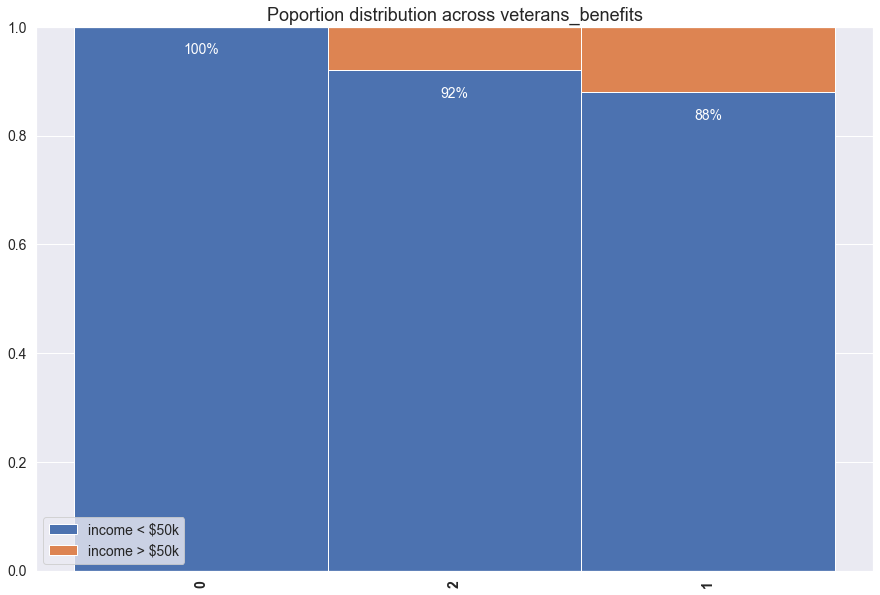

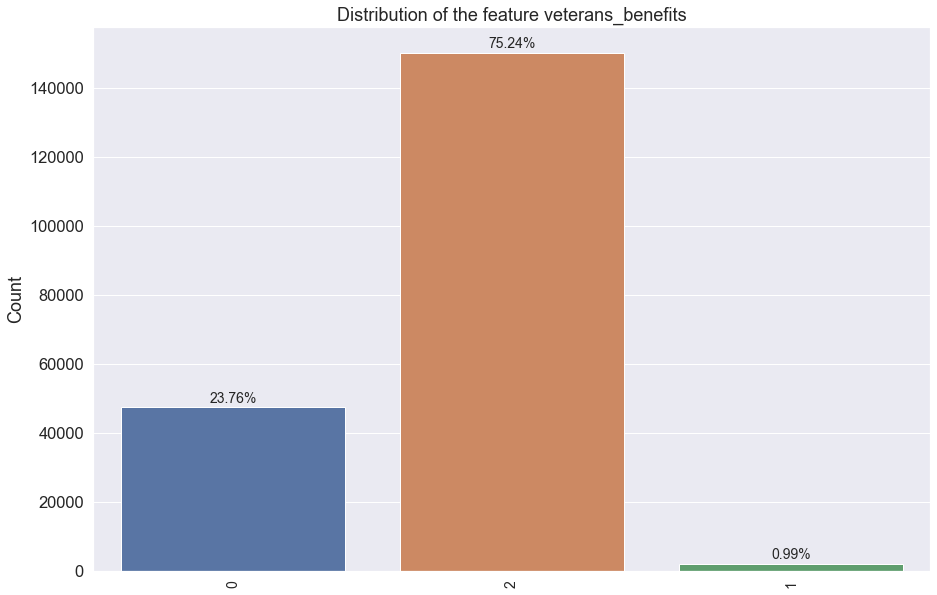

In [62]:
printmd("#### 1.3.32 veterans_benefits")
printmd('##### Comments: \n \
75.24% of the population fall in category 2, with 8% of high income earners\
In category 0, 100% are low income earners while accounting for 23.76% of\
the population. The largest share of high income earners is 12% for category 1\
though it represents less than 1% of the sample')
chart_driver(data_learn, "veterans_benefits")

#### 1.3.33 year

##### Comments: 
 Both years, 94 and 95, have very similar income distributions

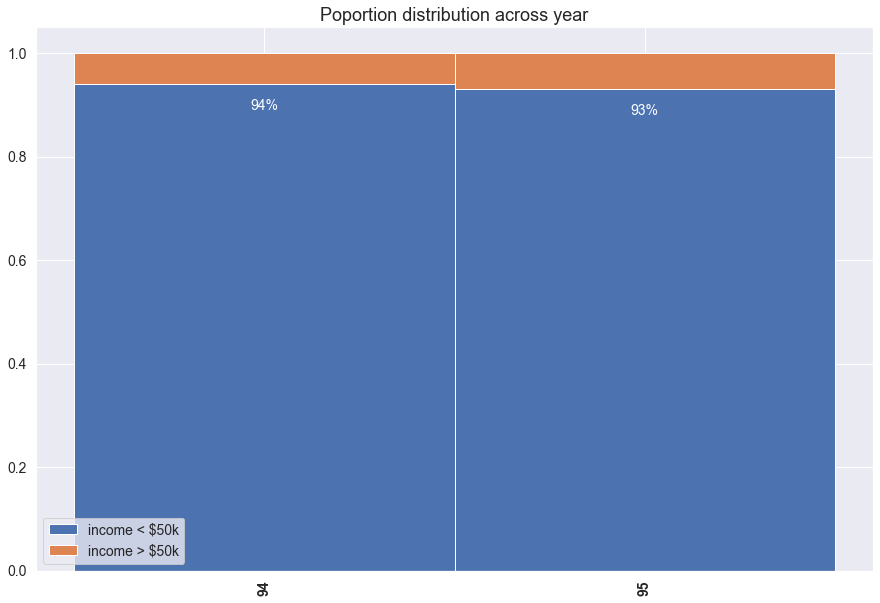

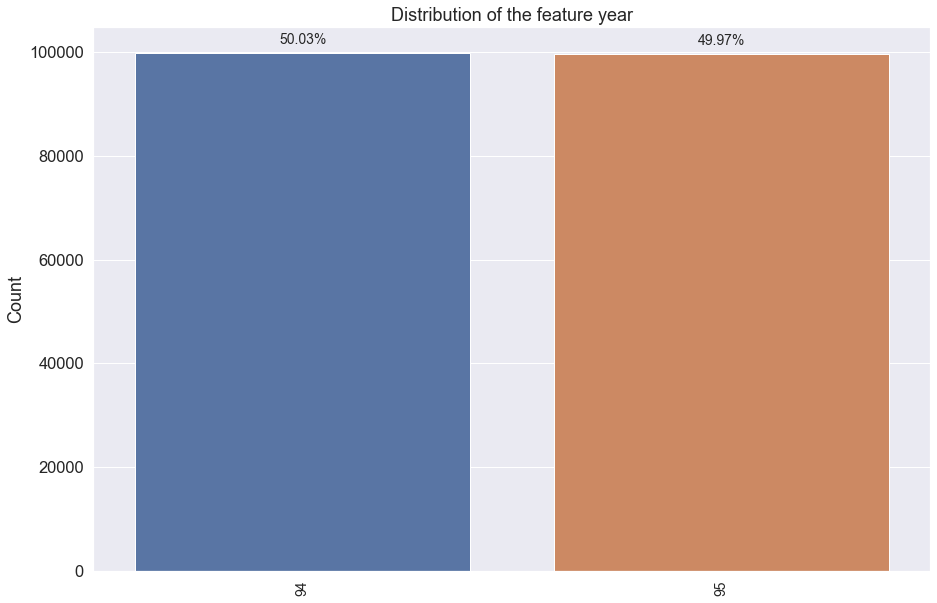

In [63]:
printmd("#### 1.3.33 year")
printmd('##### Comments: \n \
Both years, 94 and 95, have very similar income distributions')
chart_driver(data_learn, "year")

In [64]:
data_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class_of_worker                             199523 non-null  object 
 2   detailed_industry_recode                    199523 non-null  int64  
 3   detailed_occupation_recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage_per_hour                               199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  199523 non-null  object 
 7   marital_stat                                199523 non-null  object 
 8   major_industry_code                         199523 non-null  object 
 9   major_occupation_code                       199523 non-null  object 
 

## 2. Data preparation

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithm performance is enhance as opposed to ordinal encodin

I use one-hot encoding to represent all the categorical features in the dataset.

Here we could explore some feature engineering, like creating variables that are known to correlate well with 
income, such as age squared. Though we may leave this for a later iteration for the sake of time

### 2.1 One-hot encoding

In [65]:
# prepare training and test sets
def prepare_data_models(raw_data, cols_to_drop, numerical_cols):
    # drop columns
    X = raw_data.drop(cols_to_drop, axis = 1)
    # split features from target
    y, X = X['income'], X.drop(columns = ['income'])
    # one-hot encoding
    X_pending = X[[i for i in X.columns if i not in numerical_cols]]
    X_pending = pd.get_dummies(X_pending)
    # merge categorical and numerical
    X_pending = pd.concat([X_pending, X[numerical_cols]], axis=1, join='inner')
    return X_pending, y

In [66]:
to_drop = ['instance_weight']
# training set
X_train, y_train = prepare_data_models(data_learn, to_drop, numerical_cols)
# test set
X_test, y_test = prepare_data_models(data_test, to_drop, numerical_cols)


In [67]:
# I check that the labels are the same between the training and the test set
assert(list(X_train.columns) == list(X_test.columns))

AssertionError: 

In [68]:
# let's see what labels are missing
print([i for i in X_train.columns if i not in X_test.columns])
print([i for i in X_test.columns if i not in X_train.columns])

['detailed_household_and_family_stat_ Grandchild <18 ever marr not in subfamily']
[]


In [69]:
# We observe that the category 'Grandchild <18 ever marr not in subfamily' 
# from feature detailed_household_and_family_stat_ is only observed in the training set
# Let's omit it since not present in the test set

X_train = X_train[list(X_test.columns)]
assert(list(X_train.columns) == list(X_test.columns))

### 2.2 Normalisation

In [70]:
# Normalization
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(X_train)  
X_train_norm = scaler.transform(X_train)  

# Applying same transformation to test data
X_test_norm = scaler.transform(X_test)

In [75]:
pd.DataFrame(X_train_norm).describe()

0             1             2             3             4    \
count  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05   
mean  -5.641259e-15  2.654960e-15  2.873737e-15  5.081219e-15  1.250261e-14   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -8.497398e-01 -7.822350e-01 -3.168514e-01 -1.779077e+00 -9.993436e-01   
25%   -8.497398e-01 -7.822350e-01 -3.168514e-01  5.697986e-01 -9.993436e-01   
50%   -8.497398e-01 -7.822350e-01 -3.168514e-01  5.697986e-01 -9.993436e-01   
75%    9.767863e-01  1.016554e+00 -3.168514e-01  5.697986e-01  1.000657e+00   
max    1.973073e+00  2.400238e+00  3.295258e+00  5.697986e-01  1.000657e+00   

                5             6             7             8             9    \
count  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05   
mean  -1.328629e-15 -3.761796e-15  3.394039e-15 -1.021261e-14 -2.709955e-15   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -1.219757e-01 -2.014866e-01 -4.695849e-02 -1.004858e+00 -7.516300e-01   
25%   -1.219757e-01 -2.014866e-01 -4.695849e-02 -1.004858e+00 -7.516300e-01   
50%   -1.219757e-01 -2.014866e-01 -4.695849e-02  9.951651e-01 -7.516300e-01   
75%   -1.219757e-01 -2.014866e-01 -4.695849e-02  9.951651e-01  1.330442e+00   
max    8.198353e+00  4.963109e+00  2.129541e+01  9.951651e-01  1.330442e+00   

       ...           397           398           399           400  \
count  ...  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05   
mean   ...  4.950722e-16 -2.097556e-15 -1.848573e-15  2.350059e-16   
std    ...  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min    ... -8.971232e-02 -9.978278e+00 -4.431164e-02 -1.546074e+00   
25%    ... -8.971232e-02  1.002177e-01 -4.431164e-02 -8.737546e-01   
50%    ... -8.971232e-02  1.002177e-01 -4.431164e-02 -6.697187e-02   
75%    ... -8.971232e-02  1.002177e-01 -4.431164e-02  6.949896e-01   
max    ...  1.114674e+01  1.002177e-01  2.256743e+01  2.487840e+00   

                401           402           403           404           405  \
count  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05  1.995230e+05   
mean  -3.944554e-15  3.079189e-15  2.825678e-15 -3.971290e-15  4.013210e-15   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -2.016288e-01 -9.254224e-02 -1.372356e-01 -9.955329e-02 -8.270958e-01   
25%   -2.016288e-01 -9.254224e-02 -1.372356e-01 -9.955329e-02 -8.270958e-01   
50%   -2.016288e-01 -9.254224e-02 -1.372356e-01 -9.955329e-02 -4.042842e-01   
75%   -2.016288e-01 -9.254224e-02 -1.372356e-01 -9.955329e-02  8.641506e-01   
max    3.617216e+01  2.119508e+01  1.681044e+01  5.029914e+01  1.709774e+00   

                406  
count  1.995230e+05  
mean  -2.645495e-15  
std    1.000003e+00  
min   -9.493463e-01  
25%   -9.493463e-01  
50%   -6.216309e-01  
75%    1.180804e+00  
max    1.180804e+00  

[8 rows x 407 columns]

## 3. Feature selection

There are many ways to reduce the dimensionality of the data, keeping only the most relevant features in
explaimning the target variable:
* Correlation
* ANOVA f-measure
* PCA analysis
* Lasso regression

I'll undertake a correlation based selection. This will select the features that have the largest correlation
to the outcome variable. I'll keep all features with an absolute correlation higher than 0.05

In [71]:
cor =pd.DataFrame(np.column_stack((y_train, X_train_norm))).corr()

In [73]:
# Let's understand better the correlation between the features andd target variable
cor.iloc[:,0]

0      1.000000
1      0.196190
2      0.013414
3      0.040473
4      0.140930
         ...   
403    0.240725
404    0.147417
405    0.175779
406    0.222684
407    0.262316
Name: 0, Length: 408, dtype: float64

We note that 50% of the features have a correlation between -0.009541 and 0.008829. In other words, many features
may bring little explanatory power. Let's restirct the explanatory features to those with a correlation 
coefficient above 5% (in absolute terms).

In [76]:
mask=list(abs(cor.iloc[1:,0])>0.05)

In [77]:
X_train_norm, X_test_norm = X_train_norm[:,mask], X_test_norm[:,mask]

In [78]:
assert(X_test_norm.shape[1] == X_train_norm.shape[1])

## 4. Model development

Let's train 5 different models on the training data:
* Random Forest
* Adaboost
* Logistic regression
* K Nearest neighbours
* Neural Network (Multilayer Perceptron)


For each model, I perform a hyperparameter grid search, cross validate the search on 20% of the train data - separated from training for CV purposes. I use accuracy as the hyperparameter selection criteria.

The hyperparameters selected in this way are then used to make predictions from the test data.

### 4.1 Random Forest Classifier

For the RF, I experimented with the number of trees, splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. 

* Num estimators: 100, 200, 300
* Min samples required to split: 20%, 50%, 70%
* Max Depth: 50, 200
* Max features: all, log2, sqrt

In [79]:
rf  = model_selection.GridSearchCV(RandomForestClassifier(),
                                      {'n_estimators':[100, 200, 300],
                                       'max_features':[ 'auto', 'log2', 'sqrt'],
                                       'max_depth':[50, 120],
                                       'max_samples':[0.2, 0.5, 0.7]},
                                      cv = 5,
                                      scoring = 'accuracy')

In [80]:
#We fit the grid search RF classifiers :
start_time = time.time()
rf.fit(X_train_norm, y_train)
print("--- %s seconds to fit the rf model---" % (time.time() - start_time))

--- 6700.817704916 seconds to fit the rf model---


In [84]:
rf.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'max_samples': 0.2,
 'n_estimators': 300}

### 4.2 Adaboost

An AdaBoost is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

* Num estimators: 10, 50, 100, 500

In [87]:
ada  = model_selection.GridSearchCV(AdaBoostClassifier(),
                                      {'n_estimators':[10, 50, 100, 500]},
                                      cv = 5,
                                      scoring = 'accuracy')


In [88]:
#We fit the grid search Adaboost :
start_time = time.time()
ada.fit(X_train_norm, y_train)
print("--- %s seconds to fit the adadboost model---" % (time.time() - start_time))

--- 1041.0994412899017 seconds to fit the adadboost model---


In [89]:
ada.best_params_

{'n_estimators': 500}

### 4.3 Logistic regression

I tinker with regularisation type and weight:
* Penalty: none and L2 regularisation
* Inverse of regularisation strength: 0.1, 0.5, 1, 5

In [95]:
lr  = model_selection.GridSearchCV(LogisticRegression(),
                                      {'penalty':['none','l2'],
                                       'C':[0.1, 0.5, 1, 5]},
                                       cv = 5,
                                       scoring = 'accuracy')

In [96]:
#We fit the grid search LR :
start_time = time.time()
lr.fit(X_train_norm, y_train)
print("--- %s seconds to fit the linear regression model---" % (time.time() - start_time))

/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: 

/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

--- 81.31629800796509 seconds to fit the linear regression model---


/Users/pablo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
lr.best_params_

{'C': 1, 'penalty': 'l2'}

### 4.4 K-Nearest neighbours
Classifier implementing the k-nearest neighbors vote.

* N neighbours: 5, 10, 50, 100
* weights: uniform weights. All points in each neighborhood are weighted equally vs distance weights. weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [100]:
knn  = model_selection.GridSearchCV(KNeighborsClassifier(),
                                      {'weights':['uniform', 'distance'],
                                       'n_neighbors':[5, 10]},
                                       cv = 5,
                                       scoring = 'accuracy')

In [101]:
#We fit the grid search LR :
start_time = time.time()
knn.fit(X_train_norm, y_train)
print("--- %s seconds to fit the KNN model---" % (time.time() - start_time))

--- 3905.877913236618 seconds to fit the KNN model---


In [102]:
knn.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

### 4.5 Neural Network
Multi-layer Perceptron classifier. This model optimizes the log-loss function using stochastic gradient descent.

* Activation: 'relu' and 'logistic'
* Learning Rate: 'invscaling' (Gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'.)
* NN architecture: (10, 10, 5, 2), (10, 2), (5,2)

In [108]:
nn = model_selection.GridSearchCV(MLPClassifier(),
                                      {'activation':['relu', 'logistic'],
                                       'hidden_layer_sizes':[(10, 2),
                                                             (10, 10, 2),
                                                             (10, 20, 8, 2),
                                                             (20, 10, 5, 2)]},
                                       cv = 5,
                                       scoring = 'accuracy')


In [109]:
#We fit the grid search LR :
start_time = time.time()
nn.fit(X_train_norm, y_train)
print("--- %s seconds to fit the nerual network model---" % (time.time() - start_time))

--- 1908.3410198688507 seconds to fit the nerual network model---


In [110]:
nn.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (20, 10, 5, 2)}

### 4.6 SVM

In [158]:
clf_svm  = model_selection.GridSearchCV(svm.SVC(),
                                      {'kernel':['linear', 'rbf'],
                                       'C':[0.5, 1 ]},
                                      cv = 5,
                                      scoring = 'accuracy')

In [ ]:
#We fit the grid search SVM classifiers :
start_time = time.time()
clf_svm.fit(X_train_norm, y_train)
print("--- %s seconds to fit the rf model---" % (time.time() - start_time))

In [321]:
clf_svm.best_params_

{'C': 1, 'kernel': 'linear'}

## 5. Model assessment
I now use each of the five fitted models to predict incomes on the test set. For each, I restrict the comparison to the model resulting with the highest accuracy from the the hyperparameter grid search.

### 5.1 Metrics

In [144]:

def evaluate_model(actual, pred):
    """
    Given actual and predicted labels, produces measures of accuracy, precision,
    recall, f-measure, sensitivty and the error rate
    
    Parameters
    ----------
    actual : pd.DataFrame or np.array
        actual labels.
    pred : pd.DataFrame or np.array 
        predicted labels.
        
    Returns
    -------
    A dictionary of performance metrics.
    """
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc[1,0]
    TN = confusion.loc[0,0]
    FP = confusion.loc[0,1]
    FN = confusion.loc[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

In [133]:
# predict on the test set
rf_hat = rf.predict(X_test_norm)
ada_hat = ada.predict(X_test_norm)
lr_hat = lr.predict(X_test_norm)
knn_hat = knn.predict(X_test_norm)
nn_hat = nn.predict(X_test_norm)

In [153]:
# Create a table displaying all model metrics:
printmd('\n\n\n We see that the Random Forest model has the highest F-measure (0.624), precision (0.83)\
 and accuracy (0.956). It is to note that recall is 0.5 across models. i.e. for all models,\
 of the total number of high income earners identifiedd, only 50% are truly income earners, all\
 displaying quite a high proportion of False Positives.')

metrics = []
labels =[]
models = {'Random_forest': rf_hat,
          'Adaboost' : ada_hat, 
          'Linear_regression': lr_hat,
          'KNN': knn_hat,
          'NN': nn_hat}
for clf in models:
    metrics.append(evaluate_model(y_test,models[clf]))
    labels.append(clf)

table_metrics = round(pd.DataFrame(metrics, index=labels),3)
table_metrics.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)
display(table_metrics)








 We see that the Random Forest model has the highest F-measure (0.624), precision (0.83) and accuracy (0.956). It is to note that recall is 0.5 across models. i.e. for all models, of the total number of high income earners identifiedd, only 50% are truly income earners, all displaying quite a high proportion of False Positives.

accuracy  precision  recall  f_measure  specificity  \
Random_forest         0.956      0.830     0.5      0.624        0.992   
Linear_regression     0.953      0.818     0.5      0.621        0.991   
Adaboost              0.956      0.808     0.5      0.618        0.991   
NN                    0.955      0.783     0.5      0.610        0.989   
KNN                   0.947      0.720     0.5      0.590        0.984   

                   error_rate  
Random_forest           0.044  
Linear_regression       0.047  
Adaboost                0.044  
NN                      0.045  
KNN                     0.053

### Confusion Matrices

In [178]:
for clf in models:
    print('\n'+clf)
    print(pd.crosstab(y_test, models[clf], rownames=['Actual'], colnames=['Predicted']))
    


Random_forest
Predicted      0     1
Actual                
0          92815   761
1           3722  2464

Adaboost
Predicted      0     1
Actual                
0          92719   857
1           3609  2577

Linear_regression
Predicted      0     1
Actual                
0          92702   874
1           3918  2268

KNN
Predicted      0     1
Actual                
0          92069  1507
1           3881  2305

NN
Predicted      0     1
Actual                
0          92583   993
1           3586  2600


### 5.2 ROC - Area Under the Curve (AUC)

The plot below shows the receiver operating characteristic curve for the 5 trained models: Random Forest, Adaboost, logistic regression, KNN and a neural network. I chose to plot only the top 5 models as the ROC curves of most  of the models overlap and the it is not easy to interpret the curve.  

 From the figure, we can see that the ROC curve of the Neural Network model has the highest lift and is closest   to the top left corner (TPR of 1 and FPR of 0) of the plot. It is closely followed by the Random Forest curve.  However, both models ROC curves seem to cross each other at low levels of FPR 

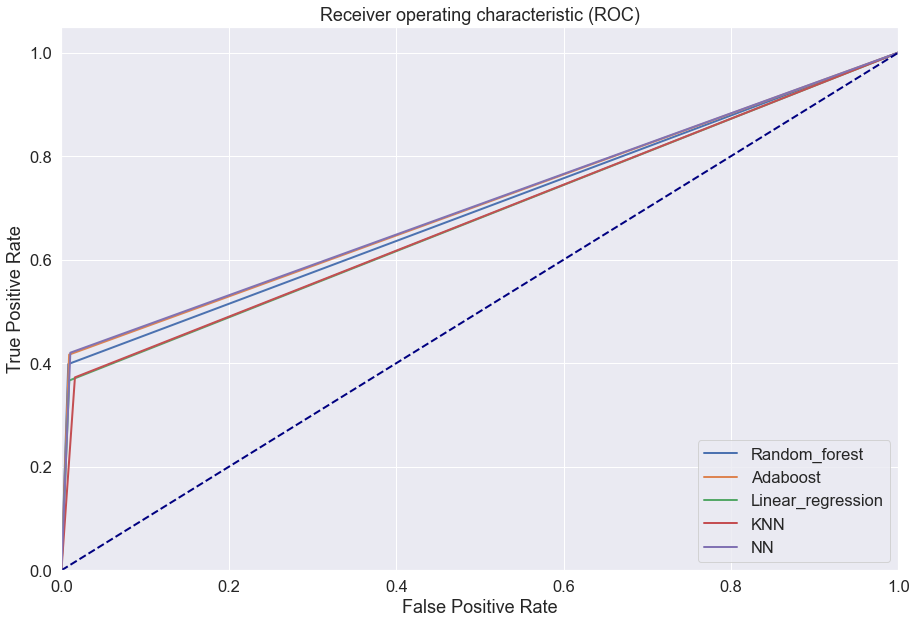

In [165]:
# Produce the ROC curve for each of our classifiers

printmd('The plot below shows the receiver operating characteristic curve for the 5 trained models: Random Forest, \
Adaboost, logistic regression, KNN and a neural network. I chose to plot only the top 5 models as the ROC curves of most\
  of the models overlap and the it is not easy to interpret the curve.\
  \n\n From the figure, we can see that the ROC curve of the Neural Network model has the highest lift and is closest \
  to the top left corner (TPR of 1 and FPR of 0) of the plot. It is closely followed by the Random Forest curve.\
  However, both models ROC curves seem to cross each other at low levels of FPR ')

plt.figure(figsize = (15,10))
for i in models:
    y_score = models[i]
    fpr, tpr, thres = metrics.roc_curve(y_test.ravel(),y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label=i)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 6. Results


The Random Forest classifier performed best to estimate to estimate whether an individual earns more than $50k or less. The RF model displays the best performance across indicators. One reason could be that RF is less affected by the imbalance nature of the data, and we have not accounted for it properly when fitting the NN and linear regression. 

To improve the models:
* enhance feature selection (PCA, lasso regression, features crosses)
* refine hyperparameters more
* balance dataset (SMOTE)
